In [20]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

In [22]:
np.random.seed(0)

# 2.a.1. Draw Exercise Boundary for American Put Option

In [23]:
# basic 
T = 1
S0 = 10
mu = 0.05
sigma = 0.2
r = 0.02
# r = 0.04
# r = 0.001
# r = 0.
# r = 0.000000001
N = 5000
# N = 100
K = 10


## Using B as a numeraire 

In [24]:
def asset_n_option_tree_B_numeraire(T, S0, sigma, r, N, K):
    timeStep = T / N
    u = np.exp(r * timeStep + sigma * np.sqrt(timeStep))  # one-step asset increase under P 
    d = np.exp(r * timeStep - sigma * np.sqrt(timeStep))  # one-step asset increase under P
    # risk neutral probability
    Qu = 0.5 * (1 - 0.5 * sigma * np.sqrt(timeStep))  # see answers in Q1
    Qd = 1 - Qu
    # asset tree
    asset_tree = np.full((N + 1, N + 1), np.nan)
    # initiate with current price
    asset_tree[0, 0] = S0
    for i in range(1, N + 1):
        # we only use the top diagonal of the tree
        asset_tree[0:i, i] = asset_tree[0:i, i - 1] * u
        asset_tree[i, i] = asset_tree[i - 1, i - 1] * d
    # Calculate the option value
    Q_option_tree = np.full((N + 1, N + 1), np.nan)
    Q_option_tree[:, -1] = np.maximum(K - asset_tree[:, -1], 0)
    for i in range(N - 1, -1, -1):
        previous_numeraire = np.exp(r * (i + 1) / N)
        current_numeraire = np.exp(r * i / N)

        Q_option_tree[0:i + 1, i] = (Qu * Q_option_tree[0:i + 1, i + 1] / previous_numeraire + Qd * Q_option_tree[
                                                                                                    1:i + 2,
                                                                                                    i + 1] / previous_numeraire) * current_numeraire
        # because this is an american option, we consider the early exercise possibility
        Q_option_tree[0:i + 1, i] = np.maximum(K - asset_tree[0:i + 1, i], Q_option_tree[0:i + 1, i])
    return asset_tree, Q_option_tree

## Demonstrate that by using A as numeraire, the option price is the same

In [25]:
def asset_n_option_tree_S_numeraire(T, S0, sigma, r, N, K):
    timeStep = T / N
    u = np.exp(r * timeStep + sigma * np.sqrt(timeStep))  # one-step asset increase under P 
    d = np.exp(r * timeStep - sigma * np.sqrt(timeStep))  # one-step asset increase under P
    # risk neutral probability
    Qsu = 0.5 * (1 + 0.5 * sigma * np.sqrt(timeStep))  # see answers in Q1
    Qsd = 1 - Qsu
    # asset tree is the same because it is under P, not Q
    asset_tree = np.full((N + 1, N + 1), np.nan)
    # initiate with current price
    asset_tree[0, 0] = S0
    for i in range(1, N + 1):
        # we only use the top diagonal of the tree
        asset_tree[0:i, i] = asset_tree[0:i, i - 1] * u
        asset_tree[i, i] = asset_tree[i - 1, i - 1] * d
    # calculate the option value
    Qs_option_tree = np.full((N + 1, N + 1), np.nan)
    Qs_option_tree[:, -1] = np.maximum(K - asset_tree[:, -1], 0)
    for i in range(N - 1, -1, -1):
        previous_u_numeraire = asset_tree[0:i + 1, i + 1]
        previous_d_numeraire = asset_tree[1:i + 2, i + 1]
        current_numeraire = asset_tree[0:i + 1, i]
        # previous_B = np.exp(r * (i + 1) / N)
        Qs_option_tree[0:i + 1, i] = (Qsu * Qs_option_tree[0:i + 1,
                                            i + 1] / previous_u_numeraire + Qsd * Qs_option_tree[
                                                                                  1:i + 2,
                                                                                  i + 1] / previous_d_numeraire) * current_numeraire
        # consider american option early exercise
        Qs_option_tree[0:i + 1, i] = np.maximum(K - asset_tree[0:i + 1, i], Qs_option_tree[0:i + 1, i])

    return asset_tree, Qs_option_tree


In [26]:
asset_tree, Q_option_tree = asset_n_option_tree_B_numeraire(T, S0, sigma, r, N, K)
asset_tree_S, Qs_option_tree = asset_n_option_tree_S_numeraire(T, S0, sigma, r, N, K)

plot note: figure out a way of demonstrating this. maybe plot the first few prices?

In [27]:
asset_tree[:10, :10]

array([[10.        , 10.02836442, 10.0568093 , 10.08533486, 10.11394133,
        10.14262894, 10.17139792, 10.2002485 , 10.22918092, 10.2581954 ],
       [        nan,  9.97179558, 10.00008   , 10.02844465, 10.05688975,
        10.08541554, 10.11402224, 10.14271008, 10.17147929, 10.2003301 ],
       [        nan,         nan,  9.94367071,  9.97187535, 10.00016   ,
        10.02852488, 10.05697021, 10.08549622, 10.11410315, 10.14279122],
       [        nan,         nan,         nan,  9.91562516,  9.94375025,
         9.97195513, 10.00024   , 10.02860511, 10.05705067, 10.08557691],
       [        nan,         nan,         nan,         nan,  9.88765871,
         9.91570448,  9.94382981,  9.9720349 , 10.00032001, 10.02868534],
       [        nan,         nan,         nan,         nan,         nan,
         9.85977114,  9.88773781,  9.91578381,  9.94390936,  9.97211468],
       [        nan,         nan,         nan,         nan,         nan,
                nan,  9.83196223,  9.85985002

In [28]:
Q_option_tree[:10, :10]

array([[0.71112048, 0.69878289, 0.68657669, 0.67450213, 0.66255939,
        0.65074866, 0.63907007, 0.62752373, 0.61610973, 0.60482811],
       [       nan, 0.72342891, 0.71096019, 0.69862264, 0.68641652,
        0.67434206, 0.66239946, 0.6505889 , 0.63891051, 0.62736441],
       [       nan,        nan, 0.7358682 , 0.72326857, 0.71079986,
        0.69846236, 0.68625631, 0.67418196, 0.6622395 , 0.65042911],
       [       nan,        nan,        nan, 0.74843811, 0.73570785,
        0.7231082 , 0.71063951, 0.69830204, 0.68609607, 0.67402183],
       [       nan,        nan,        nan,        nan, 0.76113841,
        0.74827778, 0.73554746, 0.7229478 , 0.71047911, 0.6981417 ],
       [       nan,        nan,        nan,        nan,        nan,
        0.77396879, 0.76097812, 0.74811741, 0.73538704, 0.72278736],
       [       nan,        nan,        nan,        nan,        nan,
               nan, 0.78692895, 0.77380858, 0.7608178 , 0.74795701],
       [       nan,        nan,        na

In [29]:
Qs_option_tree[:10, :10]

array([[0.71112039, 0.69878279, 0.6865766 , 0.67450203, 0.6625593 ,
        0.65074857, 0.63906998, 0.62752364, 0.61610964, 0.60482802],
       [       nan, 0.72342882, 0.71096009, 0.69862254, 0.68641642,
        0.67434197, 0.66239937, 0.65058881, 0.63891042, 0.62736431],
       [       nan,        nan, 0.7358681 , 0.72326848, 0.71079977,
        0.69846226, 0.68625622, 0.67418187, 0.66223941, 0.65042902],
       [       nan,        nan,        nan, 0.74843802, 0.73570775,
        0.72310811, 0.71063941, 0.69830195, 0.68609598, 0.67402174],
       [       nan,        nan,        nan,        nan, 0.76113831,
        0.74827768, 0.73554736, 0.7229477 , 0.71047902, 0.6981416 ],
       [       nan,        nan,        nan,        nan,        nan,
        0.77396869, 0.76097802, 0.74811731, 0.73538694, 0.72278727],
       [       nan,        nan,        nan,        nan,        nan,
               nan, 0.78692885, 0.77380848, 0.7608177 , 0.74795691],
       [       nan,        nan,        na

In [30]:
def execution_boundary_calculation(K, asset_tree, Q_option_tree):
    def np_groupby(data, key):
        # helper function for numpy to do groupby 
        unique_keys = np.unique(key)
        grouped_data = {unique_key: [] for unique_key in unique_keys}
        for i in range(len(data)):
            grouped_data[key[i]].append(data[i])
        return grouped_data

    grouped_timestamp = np_groupby(*np.where((K - asset_tree - Q_option_tree) == 0))
    grouped_timestamp = np.vstack([[min(item) for item in grouped_timestamp.values()], list(grouped_timestamp.keys())])
    execution_boundary = asset_tree[grouped_timestamp[0], grouped_timestamp[1]]
    return grouped_timestamp, execution_boundary

In [31]:
grouped_timestamp_B, execution_boundary_B = execution_boundary_calculation(K, asset_tree, Q_option_tree)
grouped_timestamp_S, execution_boundary_S = execution_boundary_calculation(K, asset_tree, Qs_option_tree)

Note for plot: give title, change this to black, add legend, add axis name

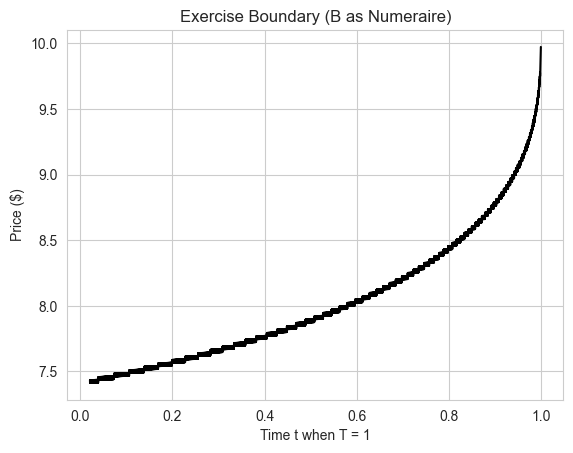

In [32]:
plt.plot(grouped_timestamp_B[1] / N, execution_boundary_B, color='black')
plt.xlabel('Time t when T = 1')
plt.ylabel('Price ($)')
plt.title('Exercise Boundary (B as Numeraire)')
plt.show()

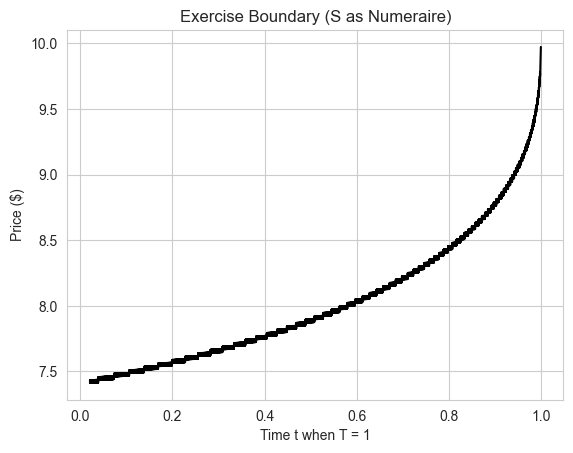

In [33]:
plt.plot(grouped_timestamp_S[1] / N, execution_boundary_S, color='black')
plt.xlabel('Time t when T = 1')
plt.ylabel('Price ($)')
plt.title('Exercise Boundary (S as Numeraire)')
plt.show()

# 2.a.2. Path Simulation

In [34]:
def sample_path(S0, T, N, r, mu, sigma):
    timeStep = T / N
    prob_epsilon_up = 0.5 * (1 + ((mu - r) - 0.5 * sigma ** 2) / sigma * np.sqrt(timeStep))
    Ntrials = 10_000
    total_path = np.empty((Ntrials, N + 1))
    total_path[:, 0] = S0
    for i in range(N):
        U = np.random.rand(Ntrials)
        epsilon = 1 * (U < prob_epsilon_up) + (-1) * (U >= prob_epsilon_up)  # realization of epsilon
        total_path[:, i + 1] = total_path[:, i] * np.exp(r * timeStep + sigma * np.sqrt(timeStep) * epsilon)
    return total_path

In [35]:
total_path = sample_path(S0, T, N, r, mu, sigma)

note for plot:
add title, axis name, legend name more details

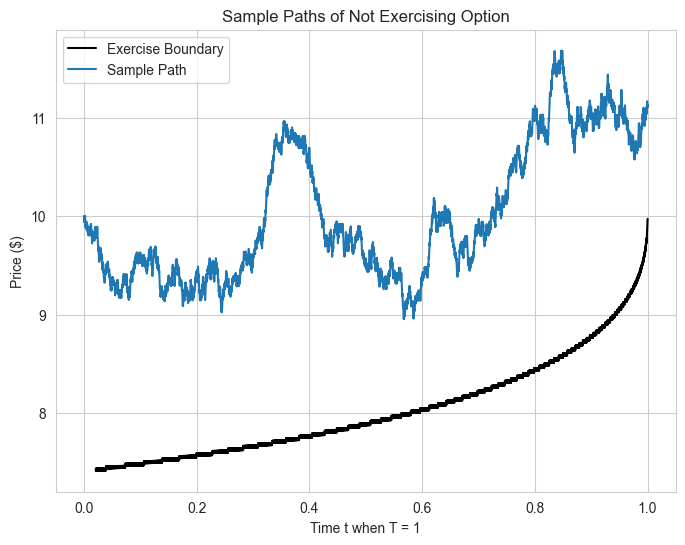

In [36]:
t_array = np.arange(0, 5001)
plt.figure(figsize=(8, 6))
plt.plot(grouped_timestamp_B[1] / N, execution_boundary_B, label='Exercise Boundary', color='black')
plt.plot(t_array / N, total_path[0, :].T, label='Sample Path')
plt.legend()
#plt.grid(True)
# Add x and y axes
plt.xlabel('Time t when T = 1')
plt.ylabel('Price ($)')
# Add a title
plt.title('Sample Paths of Not Exercising Option')
# Show the plot
plt.show()

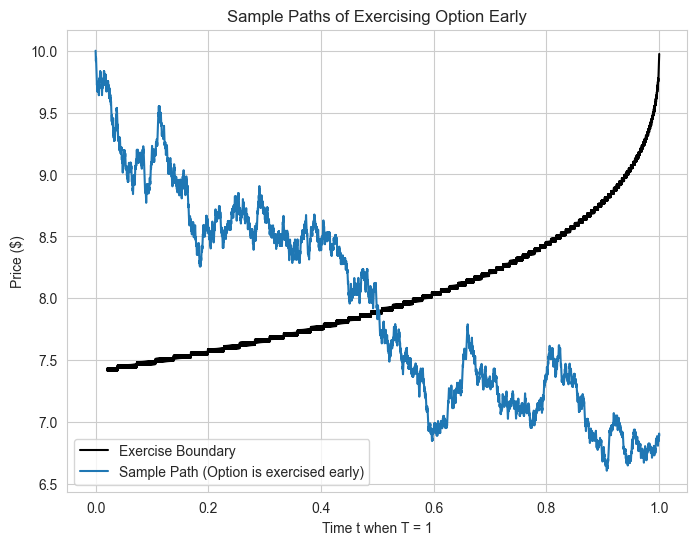

In [37]:
t_array = np.arange(0, 5001)
plt.figure(figsize=(8, 6))
plt.plot(grouped_timestamp_B[1] / N, execution_boundary_B, label='Exercise Boundary', color='black')
plt.plot(t_array / N, total_path[38, :].T, label='Sample Path (Option is exercised early)')
plt.legend()
# Add x and y axes
plt.xlabel('Time t when T = 1')
plt.ylabel('Price ($)')
# Add a title
plt.title('Sample Paths of Exercising Option Early')
# Show the plot
plt.show()

# 2.a.3. Option Hedge Strategy

In [38]:
def generate_hedge_strategy(asset_tree, Q_option_tree, path, N, r):
    alpha = []
    beta = []
    for idx, price in enumerate(path[:-1]):
        # time = idx+1
        time = idx
        location = np.where(np.abs(price - asset_tree[:, time]) < 0.0001)[0][
            0]  # the tolerance is because memory accuracy
        option_up = Q_option_tree[location, time + 1]
        option_down = Q_option_tree[location + 1, time + 1]
        asset_price_up = asset_tree[location, time + 1]
        asset_price_down = asset_tree[location + 1, time + 1]
        alpha_i = (option_up - option_down) / (asset_price_up - asset_price_down)
        B = np.exp(r * ((time + 1) / N))
        beta_i = (option_up - alpha_i * asset_price_up) / B
        # beta_i = (option_up - alpha_i * asset_price_up)
        alpha.append(alpha_i)
        beta.append(beta_i)
    return alpha, beta

In [39]:
alpha, beta = generate_hedge_strategy(asset_tree, Q_option_tree, total_path[0], N, r)
alpha_early, beta_early = generate_hedge_strategy(asset_tree, Q_option_tree, total_path[38], N, r)

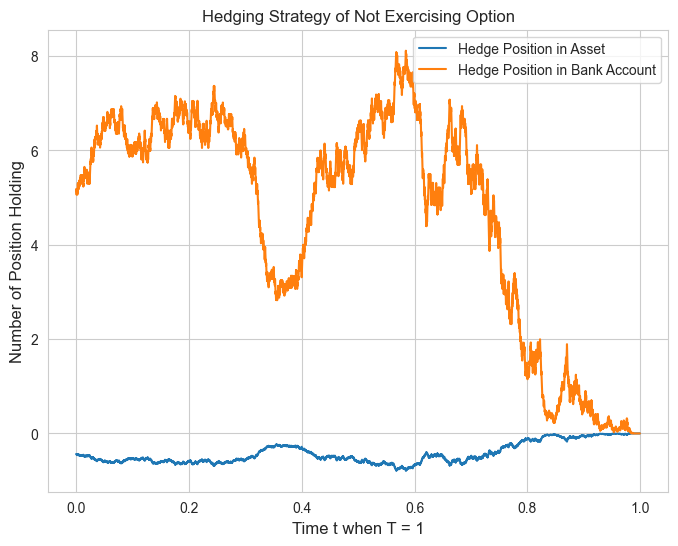

In [40]:
t_array = np.arange(0, 5000)
plt.figure(figsize=(8, 6))
plt.plot(t_array / N, alpha, label='Hedge Position in Asset')
plt.plot(t_array / N, beta, label='Hedge Position in Bank Account')
plt.legend()
# Add x and y axes
plt.xlabel('Time t when T = 1', fontsize=12)
plt.ylabel('Number of Position Holding', fontsize=12)
# Add a title
plt.title('Hedging Strategy of Not Exercising Option')
# Show the plot
plt.show()

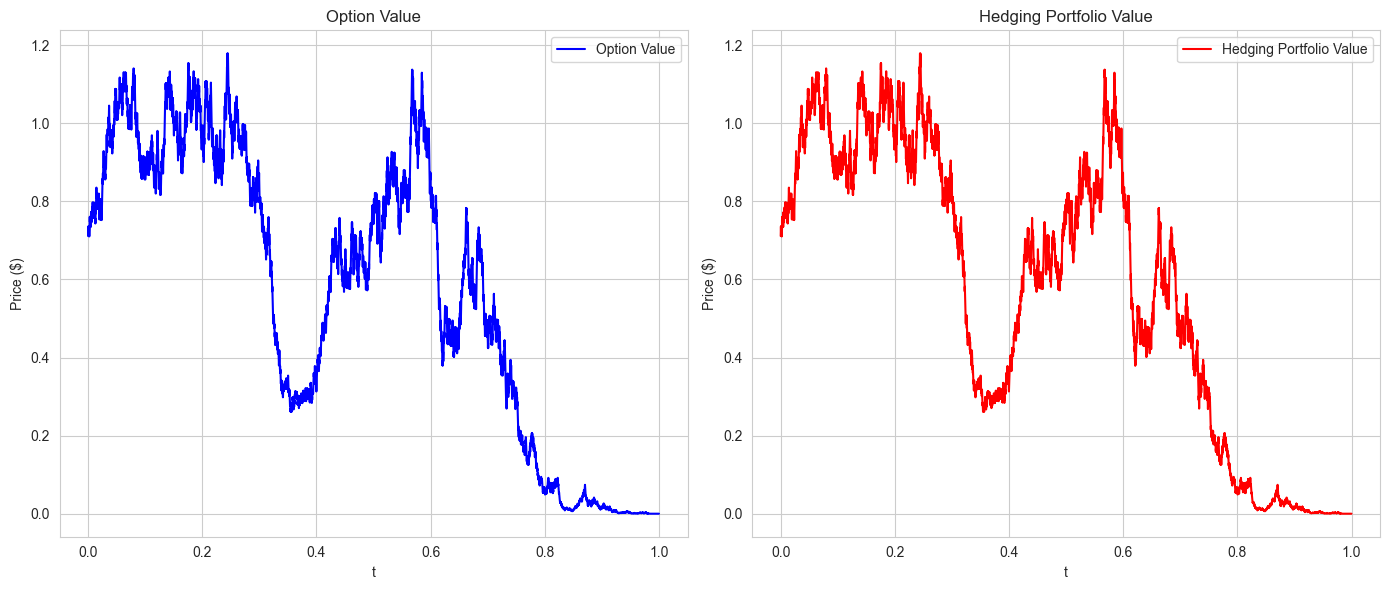

In [41]:
t_array = np.arange(0, 5001)
option_price_path = []
for time, price in enumerate(total_path[0, :]):
    location = np.where(np.abs(price - asset_tree[:, time]) < 0.0001)[0]  # the tolerance is because memory accuracy
    option_price_path.append(Q_option_tree[location, time][0])
hedge_portfolio = np.array(alpha) * total_path[0, :-1] + np.array(beta) * np.exp(r * np.arange(0, 1, 1 / N))

# Create a figure and add two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))  # Create a 1x2 grid

# Plot data on the first subplot (ax1)
ax1.plot(t_array / N, option_price_path, label='Option Value', color='blue')
ax1.set_title('Option Value')
ax1.set_xlabel('t')
ax1.set_ylabel('Price ($)')
ax1.legend()

t_array = np.arange(0, 5000)
# Plot data on the second subplot (ax2)
ax2.plot(t_array / N, hedge_portfolio, label='Hedging Portfolio Value', color='red')
ax2.set_title('Hedging Portfolio Value')
ax2.set_xlabel('t')
ax2.set_ylabel('Price ($)')
ax2.legend()

# Adjust spacing between subplots
plt.tight_layout()

# Show the figure with the two subplots
plt.show()

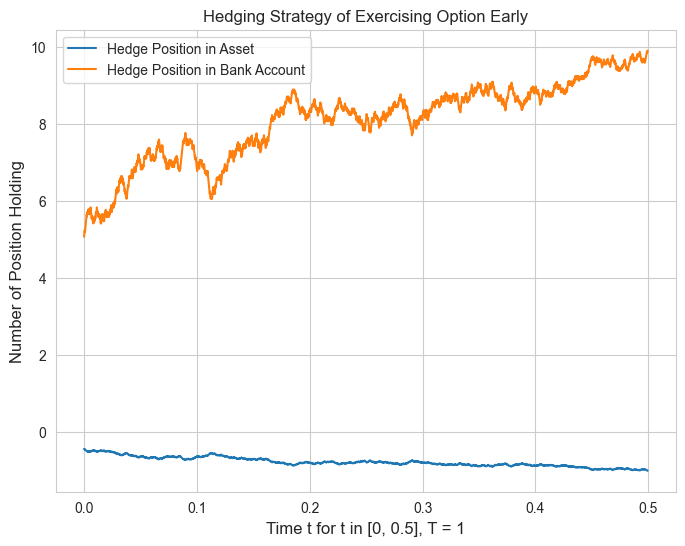

In [42]:
t_array = np.arange(0, 5000)
plt.figure(figsize=(8, 6))
location = np.where(np.array(alpha_early) == -1)[0][0]
plt.plot(t_array[:location] / N, alpha_early[:location], label='Hedge Position in Asset')
plt.plot(t_array[:location] / N, beta_early[:location], label='Hedge Position in Bank Account')
plt.legend()
# Add x and y axes
plt.xlabel('Time t for t in [0, 0.5], T = 1', fontsize=12)
plt.ylabel('Number of Position Holding', fontsize=12)
# Add a title
plt.title('Hedging Strategy of Exercising Option Early')
# Show the plot
plt.show()

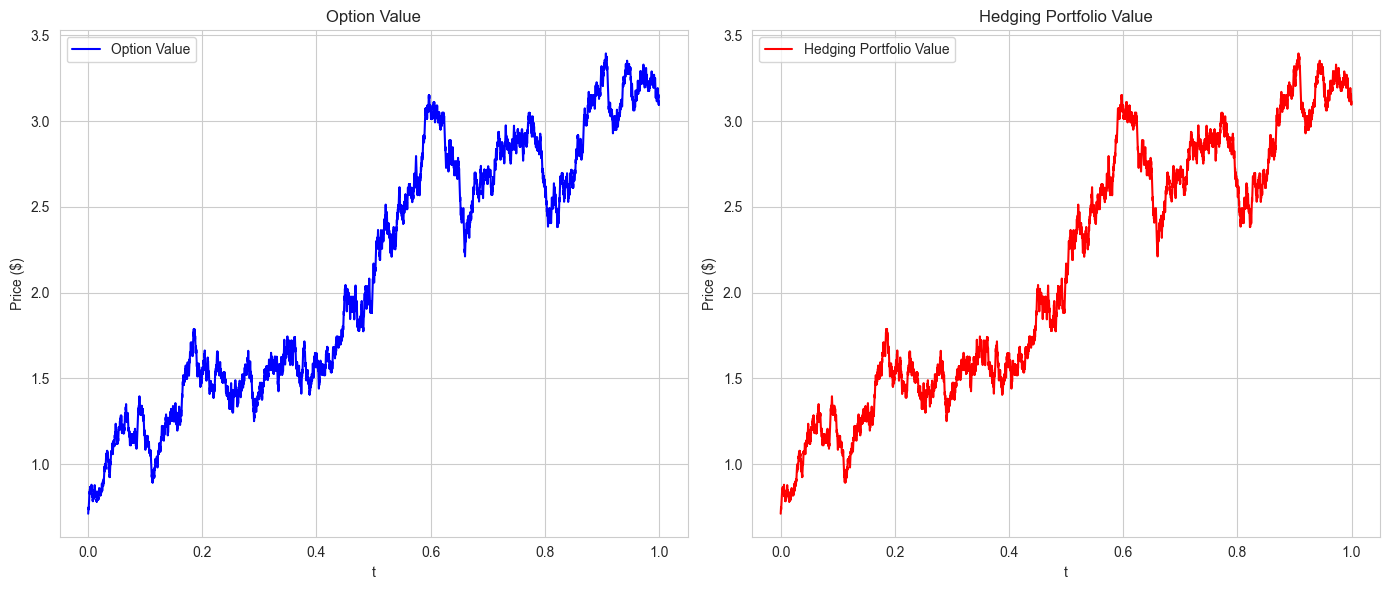

In [43]:
t_array = np.arange(0, 5001)
option_price_path = []
for time, price in enumerate(total_path[38, :]):
    location = np.where(np.abs(price - asset_tree[:, time]) < 0.0001)[0]  # the tolerance is because memory accuracy
    option_price_path.append(Q_option_tree[location, time][0])
hedge_portfolio = np.array(alpha_early) * total_path[38, :-1] + np.array(beta_early) * np.exp(
    r * np.arange(0, 1, 1 / N))

# Create a figure and add two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))  # Create a 1x2 grid

# Plot data on the first subplot (ax1)
ax1.plot(t_array / N, option_price_path, label='Option Value', color='blue')
ax1.set_title('Option Value')
ax1.set_xlabel('t')
ax1.set_ylabel('Price ($)')
ax1.legend()

t_array = np.arange(0, 5000)
# Plot data on the second subplot (ax2)
ax2.plot(t_array / N, hedge_portfolio, label='Hedging Portfolio Value', color='red')
ax2.set_title('Hedging Portfolio Value')
ax2.set_xlabel('t')
ax2.set_ylabel('Price ($)')
ax2.legend()

plt.tight_layout()
plt.show()

# 2.a.4 Analysis with different sigma and r

### exercise boundary

In [44]:
lst_sigma = [0.1, 0.2, 0.3]
lst_r = [0, 0.02, 0.04]
asset_tree = {}
Q_option_tree = {}
grouped_timestamp = {}
exercise_boundary = {}

for sigma in lst_sigma:
    for r in lst_r:
        _asset_tree, _Q_option_tree = asset_n_option_tree_B_numeraire(T, S0, sigma, r, N, K)
        grouped_timestamp_B, execution_boundary_B = execution_boundary_calculation(K, _asset_tree, _Q_option_tree)

        asset_tree[(sigma, r)] = _asset_tree
        Q_option_tree[(sigma, r)] = _Q_option_tree
        exercise_boundary[(sigma, r)] = execution_boundary_B
        grouped_timestamp[(sigma, r)] = grouped_timestamp_B
        exercise_boundary[(sigma, r)] = execution_boundary_B

exercise_boundary

{(0.1, 0): array([0.01602667, 9.97175569]),
 (0.1,
  0.02): array([8.88289177, 8.87037382, 8.88296283, ..., 9.94551056, 9.95962542,
        9.97376032]),
 (0.1,
  0.04): array([9.17797017, 9.16507305, 9.17811702, ..., 9.94743032, 9.96158776,
        9.97576534]),
 (0.2,
  0): array([1.87069396e-04, 1.87069396e-04, 1.87069396e-04, ...,
        4.53401179e-04, 8.51940413e-04, 1.00000000e+01]),
 (0.2,
  0.02): array([7.4336742 , 7.41270795, 7.43373367, ..., 9.91742015, 9.94555034,
        9.97376032]),
 (0.2,
  0.04): array([7.93521198, 7.91286283, 7.93533895, ..., 9.89131802, 9.91941385,
        9.94758948]),
 (0.3,
  0): array([7.05042005e-05, 7.05042005e-05, 7.05042005e-05, ...,
        1.23433292e-04, 1.97676919e-04, 9.91550617e+00]),
 (0.3,
  0.02): array([6.11596627, 6.09009775, 6.1160152 , ..., 9.86147713, 9.90344432,
        9.94559012]),
 (0.3,
  0.04): array([6.71624265, 6.68786191, 6.71635011, ..., 9.89131802, 9.93345194,
        9.97576534])}

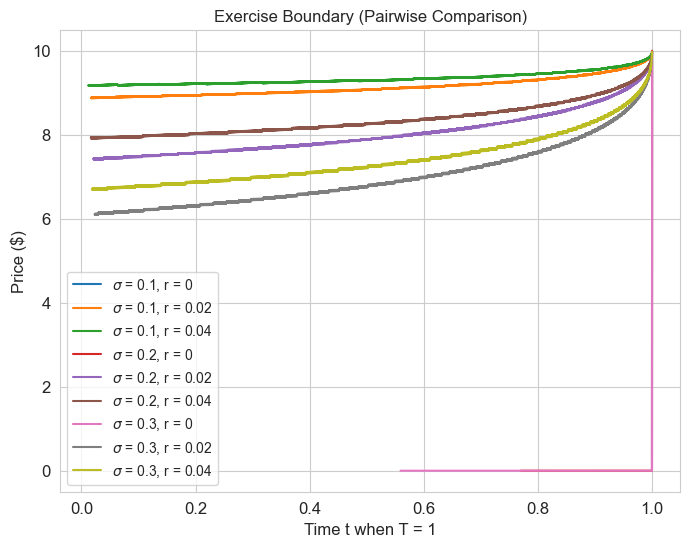

In [45]:
plt.figure(figsize=(8, 6))
for key in list(exercise_boundary.keys()):
    plt.plot(grouped_timestamp.get(key)[1] / N, exercise_boundary.get(key),
             label=r'$\sigma$ = ' + str(key[0]) + ', r = ' + str(key[1]))
plt.xlabel('Time t when T = 1', fontsize=12)
plt.ylabel('Price ($)', fontsize=12)
plt.legend()
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)
plt.title('Exercise Boundary (Pairwise Comparison)')
plt.show()

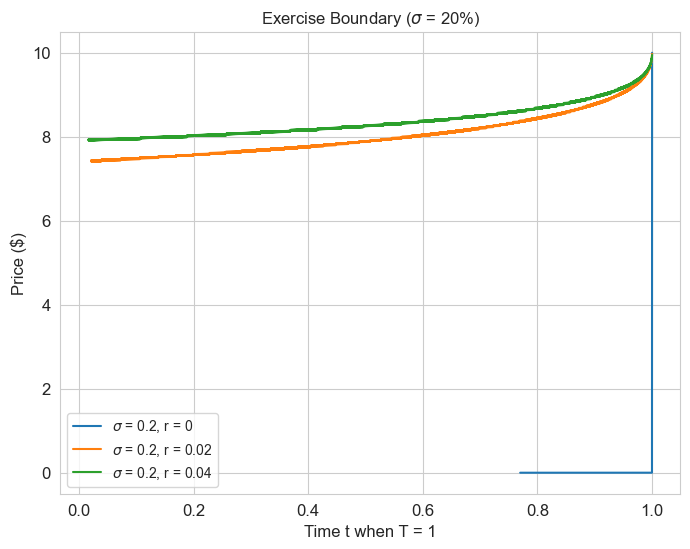

In [46]:
plt.figure(figsize=(8, 6))
for key in list(exercise_boundary.keys()):
    if key[0] == 0.2:
        plt.plot(grouped_timestamp.get(key)[1] / N, exercise_boundary.get(key),
                 label=r'$\sigma$ = ' + str(key[0]) + ', r = ' + str(key[1]))
plt.xlabel('Time t when T = 1', fontsize=12)
plt.ylabel('Price ($)', fontsize=12)
plt.legend(loc='lower left')
plt.title('Exercise Boundary (' + r'$\sigma$ = 20%)')
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)
plt.show()

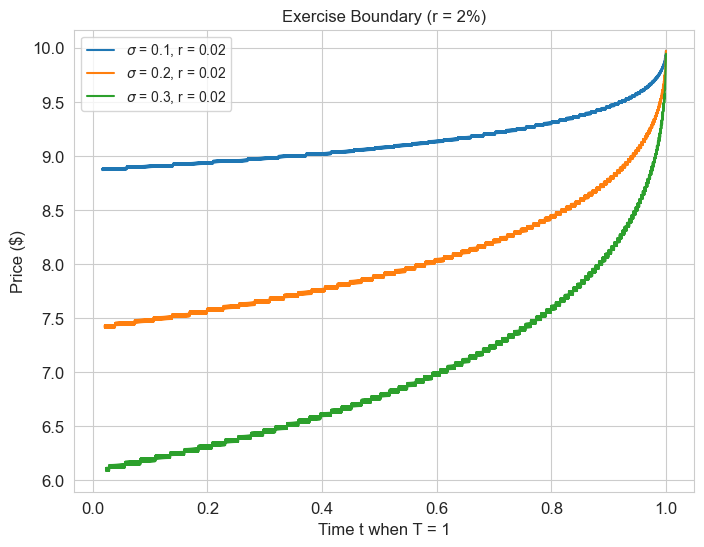

In [47]:
plt.figure(figsize=(8, 6))
for key in list(exercise_boundary.keys()):
    if key[1] == 0.02:
        plt.plot(grouped_timestamp.get(key)[1] / N, exercise_boundary.get(key),
                 label=r'$\sigma$ = ' + str(key[0]) + ', r = ' + str(key[1]))
plt.xlabel('Time t when T = 1', fontsize=12)
plt.ylabel('Price ($)', fontsize=12)
plt.legend()
plt.title('Exercise Boundary (r = 2%)')
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)
plt.show()

### not exercise, fixed sigma

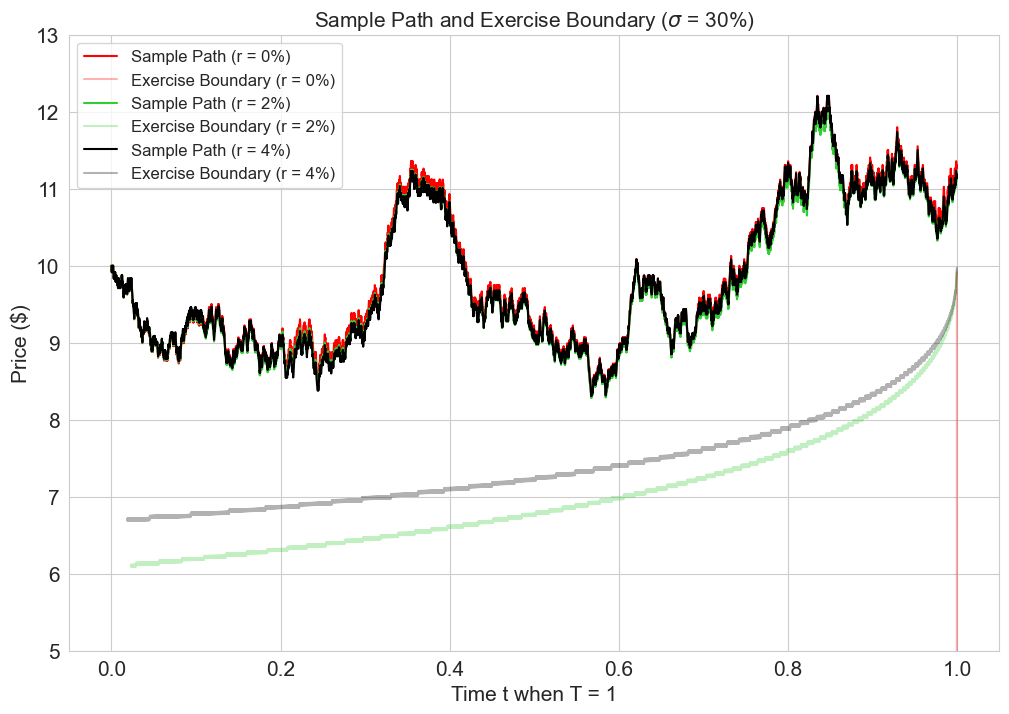

In [48]:
path = {(0.1, 0): [0, 60], (0.2, 0): [0, 60], (0.3, 0): [0, 60],
        (0.1, 0.02): [0, 60], (0.2, 0.02): [0, 60], (0.3, 0.02): [0, 60],
        (0.1, 0.04): [0, 60], (0.2, 0.04): [0, 60], (0.3, 0.04): [0, 60]}
Color = ['red', 'limegreen', 'black']
plt.figure(figsize=(12, 8))
i = 0
for key in list(exercise_boundary.keys()):
    if key[0] == 0.3:
        np.random.seed(0)
        total_path = sample_path(S0, T, N, key[1], mu, key[0])
        t_array = np.arange(0, 5001)
        plt.plot(t_array / N, total_path[path.get(key)[0], :].T, color=Color[i],
                 label='Sample Path (r = ' + str(int(key[1] * 100)) + '%)')
        plt.plot(grouped_timestamp.get(key)[1] / N, exercise_boundary.get(key), color=Color[i], alpha=0.3,
                 label='Exercise Boundary (r = ' + str(int(key[1] * 100)) + '%)')
        i += 1
plt.xlabel('Time t when T = 1', fontsize=15)
plt.ylabel('Price ($)', fontsize=15)
plt.ylim(5, 13)
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)
plt.legend(loc='best', fontsize=12)
plt.title('Sample Path and Exercise Boundary (' + r'$\sigma$ = 30%)', fontsize=15)
plt.show()

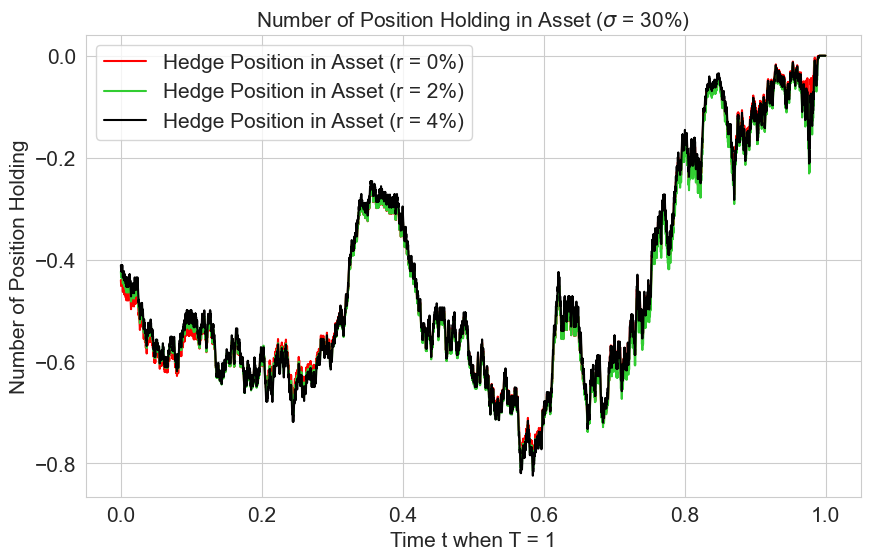

In [49]:
path = {(0.1, 0): [0, 60], (0.2, 0): [0, 60], (0.3, 0): [0, 60],
        (0.1, 0.02): [0, 60], (0.2, 0.02): [0, 60], (0.3, 0.02): [0, 60],
        (0.1, 0.04): [0, 60], (0.2, 0.04): [0, 60], (0.3, 0.04): [0, 60]}
Color = ['red', 'limegreen', 'black']
plt.figure(figsize=(10, 6))
i = 0
for key in list(exercise_boundary.keys()):
    if key[0] == 0.3:
        np.random.seed(0)
        total_path = sample_path(S0, T, N, key[1], mu, key[0])
        alpha, beta = generate_hedge_strategy(asset_tree.get(key), Q_option_tree.get(key), total_path[path.get(key)[0]],
                                              N, key[1])
        t_array = np.arange(0, 5000)
        plt.plot(t_array / N, alpha, color=Color[i],
                 label='Hedge Position in Asset (r = ' + str(int(key[1] * 100)) + '%)')
        i += 1
plt.xlabel('Time t when T = 1', fontsize=15)
plt.ylabel('Number of Position Holding', fontsize=15)
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)
plt.legend(fontsize=15)
plt.title('Number of Position Holding in Asset (' + r'$\sigma$ = 30%)', fontsize=15)
plt.show()

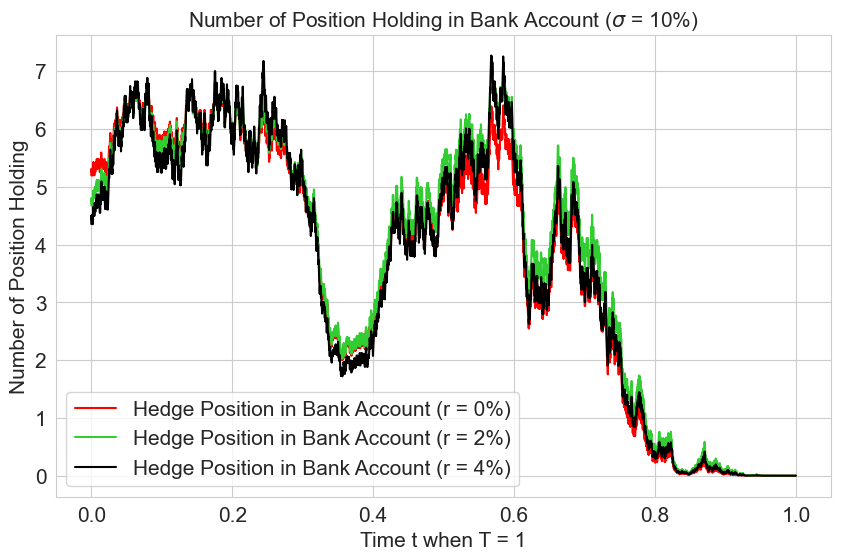

In [50]:
path = {(0.1, 0): [0, 60], (0.2, 0): [0, 60], (0.3, 0): [0, 60],
        (0.1, 0.02): [0, 60], (0.2, 0.02): [0, 60], (0.3, 0.02): [0, 60],
        (0.1, 0.04): [0, 60], (0.2, 0.04): [0, 60], (0.3, 0.04): [0, 60]}
Color = ['red', 'limegreen', 'black']
plt.figure(figsize=(10, 6))
i = 0
for key in list(exercise_boundary.keys()):
    if key[0] == 0.1:
        np.random.seed(0)
        total_path = sample_path(S0, T, N, key[1], mu, key[0])
        alpha, beta = generate_hedge_strategy(asset_tree.get(key), Q_option_tree.get(key), total_path[path.get(key)[0]],
                                              N, key[1])
        t_array = np.arange(0, 5000)
        plt.plot(t_array / N, beta, color=Color[i],
                 label='Hedge Position in Bank Account (r = ' + str(int(key[1] * 100)) + '%)')
        i += 1
plt.xlabel('Time t when T = 1', fontsize=15)
plt.ylabel('Number of Position Holding', fontsize=15)
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)
plt.legend(fontsize=15)
plt.title('Number of Position Holding in Bank Account (' + r'$\sigma$ = 10%)', fontsize=15)
plt.show()

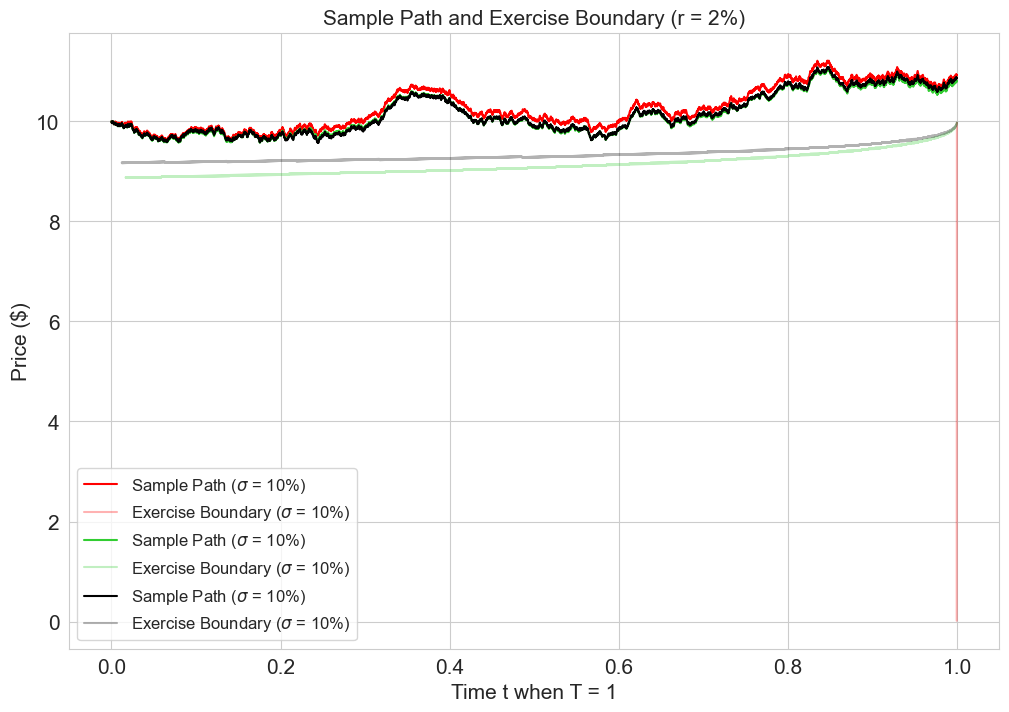

In [51]:
path = {(0.1, 0): [0, 60], (0.2, 0): [0, 60], (0.3, 0): [0, 60],
        (0.1, 0.02): [0, 60], (0.2, 0.02): [0, 60], (0.3, 0.02): [0, 60],
        (0.1, 0.04): [0, 60], (0.2, 0.04): [0, 60], (0.3, 0.04): [0, 60]}
Color = ['red', 'limegreen', 'black']
plt.figure(figsize=(12, 8))
i = 0
for key in list(exercise_boundary.keys()):
    if key[0] == 0.1:
        np.random.seed(0)
        total_path = sample_path(S0, T, N, key[1], mu, key[0])
        t_array = np.arange(0, 5001)
        plt.plot(t_array / N, total_path[path.get(key)[0], :].T, color=Color[i],
                 label='Sample Path (' + r'$\sigma$ = ' + str(int(key[0] * 100)) + '%)')
        plt.plot(grouped_timestamp.get(key)[1] / N, exercise_boundary.get(key), color=Color[i], alpha=0.3,
                 label='Exercise Boundary (' + r'$\sigma$ = ' + str(int(key[0] * 100)) + '%)')
        i += 1
plt.xlabel('Time t when T = 1', fontsize=15)
plt.ylabel('Price ($)', fontsize=15)
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)
plt.legend(loc='best', fontsize=12)
plt.title('Sample Path and Exercise Boundary (r = 2%)', fontsize=15)
plt.show()

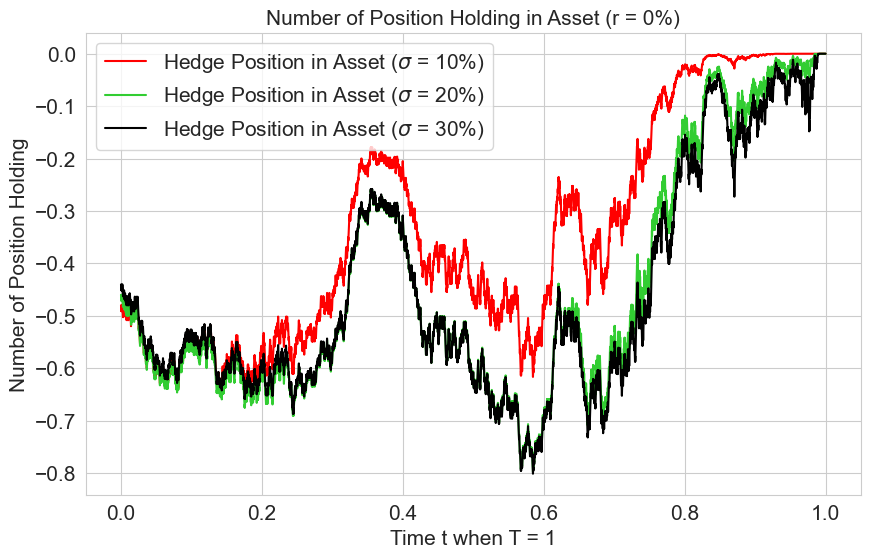

In [52]:
path = {(0.1, 0): [0, 60], (0.2, 0): [0, 60], (0.3, 0): [0, 60],
        (0.1, 0.02): [0, 60], (0.2, 0.02): [0, 60], (0.3, 0.02): [0, 60],
        (0.1, 0.04): [0, 60], (0.2, 0.04): [0, 60], (0.3, 0.04): [0, 60]}
Color = ['red', 'limegreen', 'black']
plt.figure(figsize=(10, 6))
i = 0
for key in list(exercise_boundary.keys()):
    if key[1] == 0:
        np.random.seed(0)
        total_path = sample_path(S0, T, N, key[1], mu, key[0])
        alpha, beta = generate_hedge_strategy(asset_tree.get(key), Q_option_tree.get(key), total_path[path.get(key)[0]],
                                              N, key[1])
        t_array = np.arange(0, 5000)
        plt.plot(t_array / N, alpha, color=Color[i],
                 label='Hedge Position in Asset (' + r'$\sigma$ = ' + str(int(key[0] * 100)) + '%)')
        i += 1
plt.xlabel('Time t when T = 1', fontsize=15)
plt.ylabel('Number of Position Holding', fontsize=15)
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)
plt.legend(fontsize=15)
plt.title('Number of Position Holding in Asset (r = 0%)', fontsize=15)
plt.show()

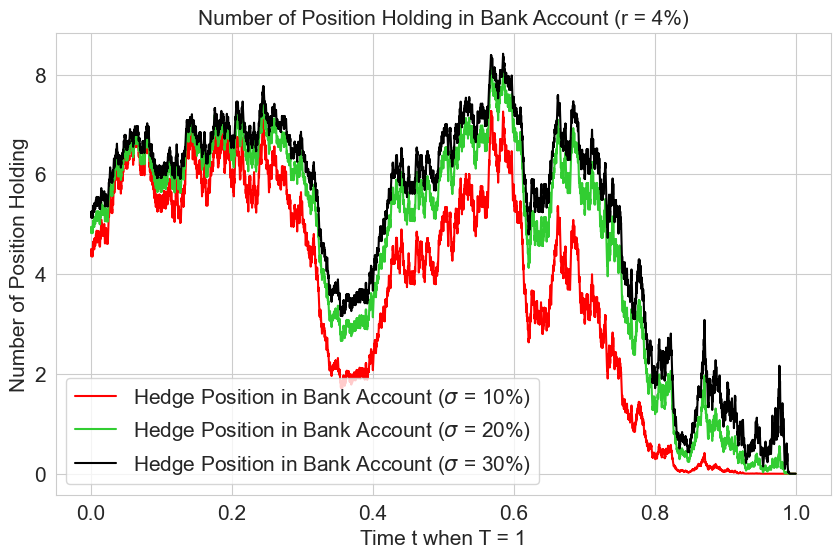

In [53]:
path = {(0.1, 0): [0, 60], (0.2, 0): [0, 60], (0.3, 0): [0, 60],
        (0.1, 0.02): [0, 60], (0.2, 0.02): [0, 60], (0.3, 0.02): [0, 60],
        (0.1, 0.04): [0, 60], (0.2, 0.04): [0, 60], (0.3, 0.04): [0, 60]}
Color = ['red', 'limegreen', 'black']
plt.figure(figsize=(10, 6))
i = 0
for key in list(exercise_boundary.keys()):
    if key[1] == 0.04:
        np.random.seed(0)
        total_path = sample_path(S0, T, N, key[1], mu, key[0])
        alpha, beta = generate_hedge_strategy(asset_tree.get(key), Q_option_tree.get(key), total_path[path.get(key)[0]],
                                              N, key[1])
        t_array = np.arange(0, 5000)
        plt.plot(t_array / N, beta, color=Color[i],
                 label='Hedge Position in Bank Account (' + r'$\sigma$ = ' + str(int(key[0] * 100)) + '%)')
        i += 1
plt.xlabel('Time t when T = 1', fontsize=15)
plt.ylabel('Number of Position Holding', fontsize=15)
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)
plt.legend(fontsize=15)
plt.title('Number of Position Holding in Bank Account (r = 4%)', fontsize=15)
plt.show()

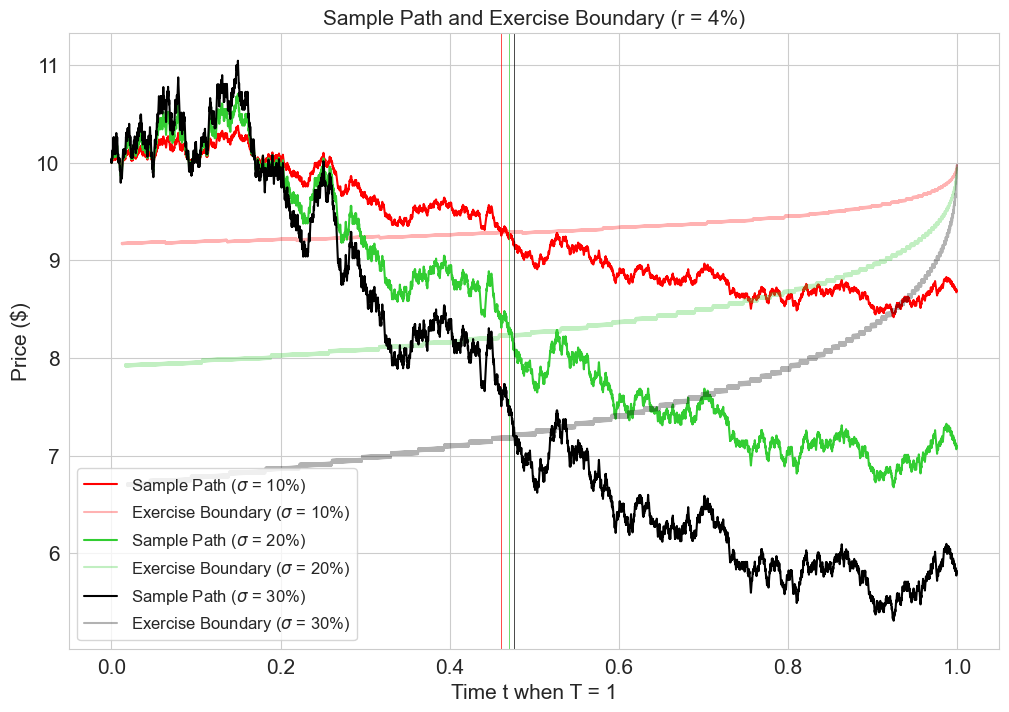

In [54]:
path = {(0.1, 0): [0, 60], (0.2, 0): [0, 60], (0.3, 0): [0, 60],
        (0.1, 0.02): [0, 60], (0.2, 0.02): [0, 60], (0.3, 0.02): [0, 60],
        (0.1, 0.04): [0, 60], (0.2, 0.04): [0, 60], (0.3, 0.04): [0, 60]}
Color = ['red', 'limegreen', 'black']
plt.figure(figsize=(12, 8))
i = 0
for key in list(exercise_boundary.keys()):
    if key[1] == 0.04:
        np.random.seed(0)
        total_path = sample_path(S0, T, N, key[1], mu, key[0])
        shape_diff = total_path[path.get(key)[1]].shape[0] - exercise_boundary.get(key).shape[0]
        diff = np.abs(total_path[path.get(key)[1]][shape_diff:] - exercise_boundary.get(key))
        equal_diff_indices = np.where(diff < 0.00001)[0][0]
        t_array = np.arange(0, 5001)
        plt.plot(t_array / N, total_path[path.get(key)[1], :].T, color=Color[i],
                 label='Sample Path (' + r'$\sigma$ = ' + str(int(key[0] * 100)) + '%)')
        plt.plot(grouped_timestamp.get(key)[1] / N, exercise_boundary.get(key), color=Color[i], alpha=0.3,
                 label='Exercise Boundary (' + r'$\sigma$ = ' + str(int(key[0] * 100)) + '%)')
        plt.axvline((equal_diff_indices + shape_diff) / N, color=Color[i], linewidth=0.5)
        i += 1
plt.xlabel('Time t when T = 1', fontsize=15)
plt.ylabel('Price ($)', fontsize=15)
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)
plt.legend(loc='lower left', fontsize=12)
plt.title('Sample Path and Exercise Boundary (r = 4%)', fontsize=15)
plt.show()

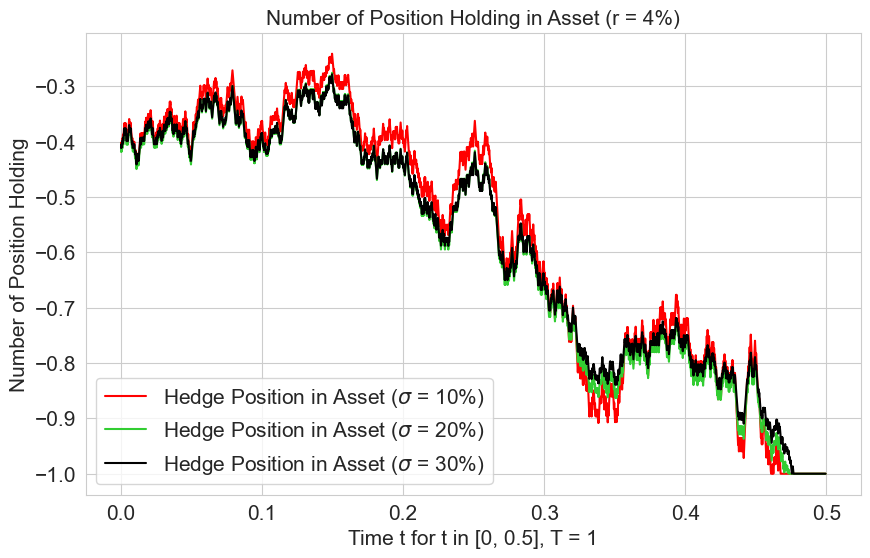

In [55]:
path = {(0.1, 0): [0, 60], (0.2, 0): [0, 60], (0.3, 0): [0, 60],
        (0.1, 0.02): [0, 60], (0.2, 0.02): [0, 60], (0.3, 0.02): [0, 60],
        (0.1, 0.04): [0, 60], (0.2, 0.04): [0, 60], (0.3, 0.04): [0, 60]}
Color = ['red', 'limegreen', 'black']
plt.figure(figsize=(10, 6))
i = 0
for key in list(exercise_boundary.keys()):
    if key[1] == 0.04:
        np.random.seed(0)
        total_path = sample_path(S0, T, N, key[1], mu, key[0])
        alpha, beta = generate_hedge_strategy(asset_tree.get(key), Q_option_tree.get(key), total_path[path.get(key)[1]],
                                              N, key[1])
        location = np.where(np.array(alpha_early) == -1)[0][0]
        t_array = np.arange(0, 5000)
        plt.plot(t_array[:location] / N, alpha[:location], color=Color[i],
                 label='Hedge Position in Asset (' + r'$\sigma$ = ' + str(int(key[0] * 100)) + '%)')
        i += 1
plt.xlabel('Time t for t in [0, 0.5], T = 1', fontsize=15)
plt.ylabel('Number of Position Holding', fontsize=15)
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)
plt.legend(fontsize=15)
plt.title('Number of Position Holding in Asset (r = 4%)', fontsize=15)
plt.show()

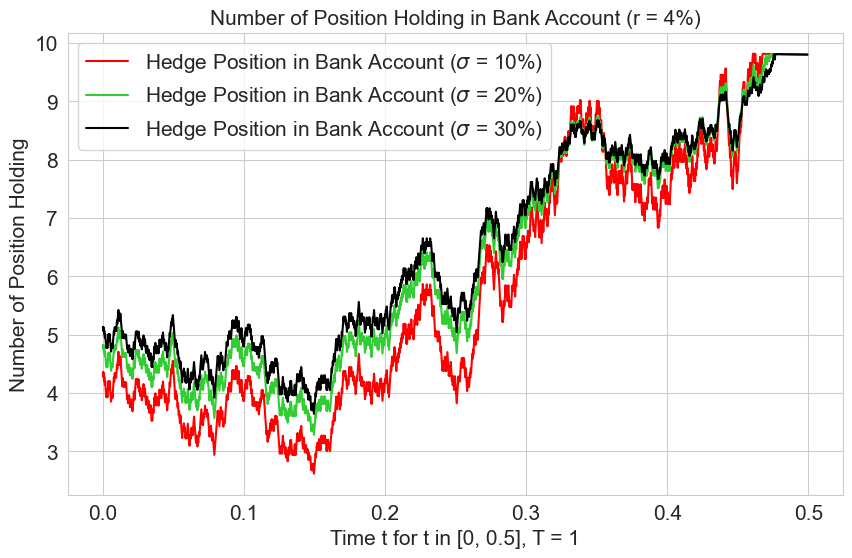

In [56]:
path = {(0.1, 0): [0, 60], (0.2, 0): [0, 60], (0.3, 0): [0, 60],
        (0.1, 0.02): [0, 60], (0.2, 0.02): [0, 60], (0.3, 0.02): [0, 60],
        (0.1, 0.04): [0, 60], (0.2, 0.04): [0, 60], (0.3, 0.04): [0, 60]}
Color = ['red', 'limegreen', 'black']
plt.figure(figsize=(10, 6))
i = 0
for key in list(exercise_boundary.keys()):
    if key[1] == 0.04:
        np.random.seed(0)
        total_path = sample_path(S0, T, N, key[1], mu, key[0])
        alpha, beta = generate_hedge_strategy(asset_tree.get(key), Q_option_tree.get(key), total_path[path.get(key)[1]],
                                              N, key[1])
        location = np.where(np.array(alpha_early) == -1)[0][0]
        t_array = np.arange(0, 5000)
        plt.plot(t_array[:location] / N, beta[:location], color=Color[i],
                 label='Hedge Position in Bank Account (' + r'$\sigma$ = ' + str(int(key[0] * 100)) + '%)')
        i += 1
plt.xlabel('Time t for t in [0, 0.5], T = 1', fontsize=15)
plt.ylabel('Number of Position Holding', fontsize=15)
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)
plt.legend(fontsize=15)
plt.title('Number of Position Holding in Bank Account (r = 4%)', fontsize=15)
plt.show()

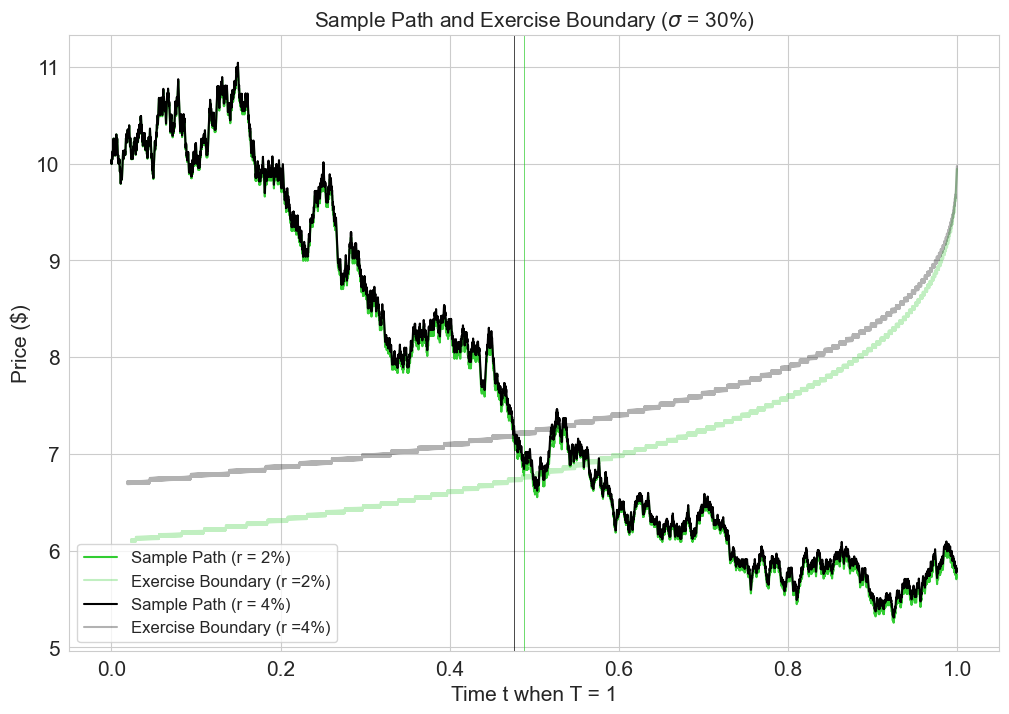

In [57]:
path = {(0.1, 0): [0, 60], (0.2, 0): [0, 60], (0.3, 0): [0, 60],
        (0.1, 0.02): [0, 60], (0.2, 0.02): [0, 60], (0.3, 0.02): [0, 60],
        (0.1, 0.04): [0, 60], (0.2, 0.04): [0, 60], (0.3, 0.04): [0, 60]}
Color = ['red', 'limegreen', 'black']
plt.figure(figsize=(12, 8))
i = 0
for key in list(exercise_boundary.keys()):
    if key[0] == 0.3:
        if key[1] != 0:
            np.random.seed(0)
            total_path = sample_path(S0, T, N, key[1], mu, key[0])
            shape_diff = total_path[path.get(key)[1]].shape[0] - exercise_boundary.get(key).shape[0]
            diff = np.abs(total_path[path.get(key)[1]][shape_diff:] - exercise_boundary.get(key))
            equal_diff_indices = np.where(diff < 0.00001)[0][0]
            t_array = np.arange(0, 5001)
            plt.plot(t_array / N, total_path[path.get(key)[1], :].T, color=Color[i + 1],
                     label='Sample Path (r = ' + str(int(key[1] * 100)) + '%)')
            plt.plot(grouped_timestamp.get(key)[1] / N, exercise_boundary.get(key), color=Color[i + 1], alpha=0.3,
                     label='Exercise Boundary (r =' + str(int(key[1] * 100)) + '%)')
            plt.axvline((equal_diff_indices + shape_diff) / N, color=Color[i + 1], linewidth=0.5)
            i += 1
plt.xlabel('Time t when T = 1', fontsize=15)
plt.ylabel('Price ($)', fontsize=15)
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)
plt.legend(loc='lower left', fontsize=12)
plt.title('Sample Path and Exercise Boundary (' + r'$\sigma$ = 30%)', fontsize=15)
plt.show()

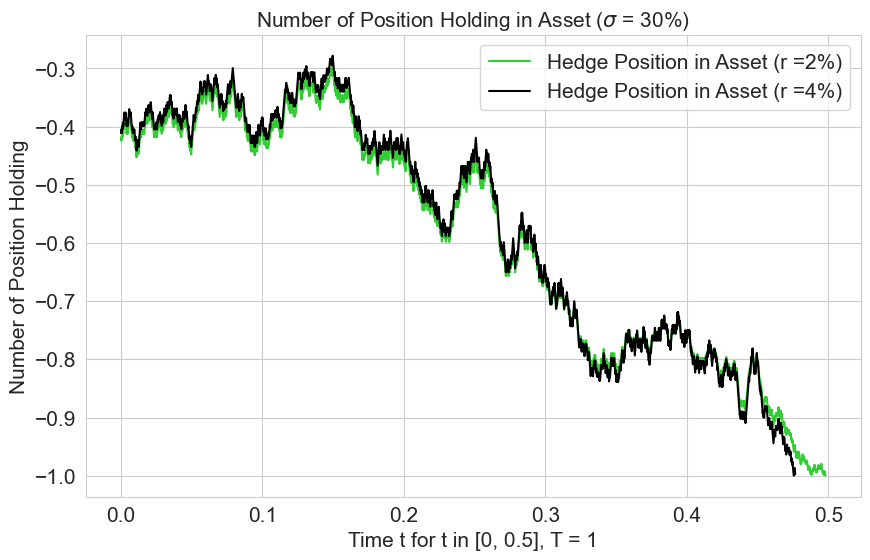

In [58]:
path = {(0.1, 0): [0, 60], (0.2, 0): [0, 60], (0.3, 0): [0, 60],
        (0.1, 0.02): [0, 60], (0.2, 0.02): [0, 60], (0.3, 0.02): [0, 60],
        (0.1, 0.04): [0, 60], (0.2, 0.04): [0, 60], (0.3, 0.04): [0, 60]}
Color = ['red', 'limegreen', 'black']
plt.figure(figsize=(10, 6))
i = 0
for key in list(exercise_boundary.keys()):
    if key[0] == 0.3:
        if key[1] != 0:
            np.random.seed(0)
            total_path = sample_path(S0, T, N, key[1], mu, key[0])
            alpha, beta = generate_hedge_strategy(asset_tree.get(key), Q_option_tree.get(key),
                                                  total_path[path.get(key)[1]], N, key[1])
            location = np.where(np.array(alpha) == -1)[0][0]
            t_array = np.arange(0, 5000)
            plt.plot(t_array[:location] / N, alpha[:location], color=Color[i + 1],
                     label='Hedge Position in Asset (r =' + str(int(key[1] * 100)) + '%)')
            i += 1
plt.xlabel('Time t for t in [0, 0.5], T = 1', fontsize=15)
plt.ylabel('Number of Position Holding', fontsize=15)
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)
plt.legend(fontsize=15)
plt.title('Number of Position Holding in Asset (' + r'$\sigma$ = 30%)', fontsize=15)
plt.show()

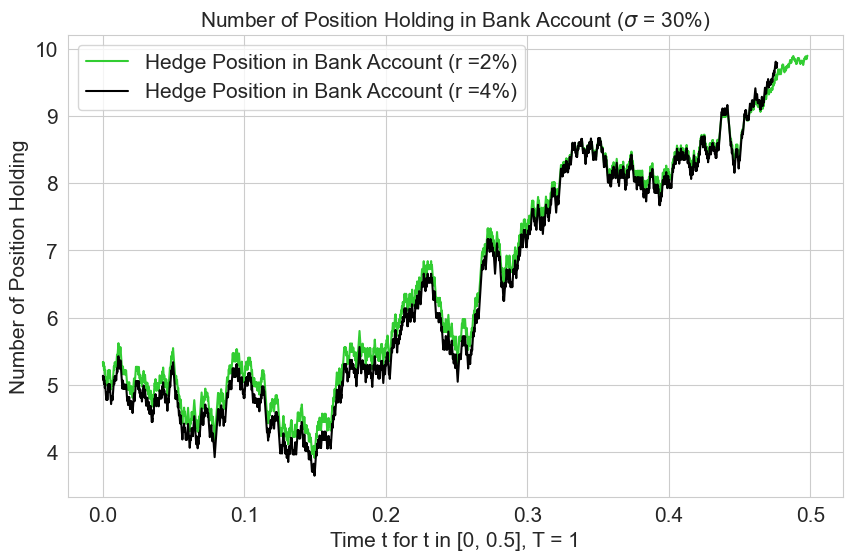

In [59]:
path = {(0.1, 0): [0, 60], (0.2, 0): [0, 60], (0.3, 0): [0, 60],
        (0.1, 0.02): [0, 60], (0.2, 0.02): [0, 60], (0.3, 0.02): [0, 60],
        (0.1, 0.04): [0, 60], (0.2, 0.04): [0, 60], (0.3, 0.04): [0, 60]}
Color = ['red', 'limegreen', 'black']
plt.figure(figsize=(10, 6))
i = 0
for key in list(exercise_boundary.keys()):
    if key[0] == 0.3:
        if key[1] != 0:
            np.random.seed(0)
            total_path = sample_path(S0, T, N, key[1], mu, key[0])
            alpha, beta = generate_hedge_strategy(asset_tree.get(key), Q_option_tree.get(key),
                                                  total_path[path.get(key)[1]], N, key[1])
            location = np.where(np.array(alpha) == -1)[0][0]
            t_array = np.arange(0, 5000)
            plt.plot(t_array[:location] / N, beta[:location], color=Color[i + 1],
                     label='Hedge Position in Bank Account (r =' + str(int(key[1] * 100)) + '%)')
            i += 1
plt.xlabel('Time t for t in [0, 0.5], T = 1', fontsize=15)
plt.ylabel('Number of Position Holding', fontsize=15)
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)
plt.legend(fontsize=15)
plt.title('Number of Position Holding in Bank Account (' + r'$\sigma$ = 30%)', fontsize=15)
plt.show()

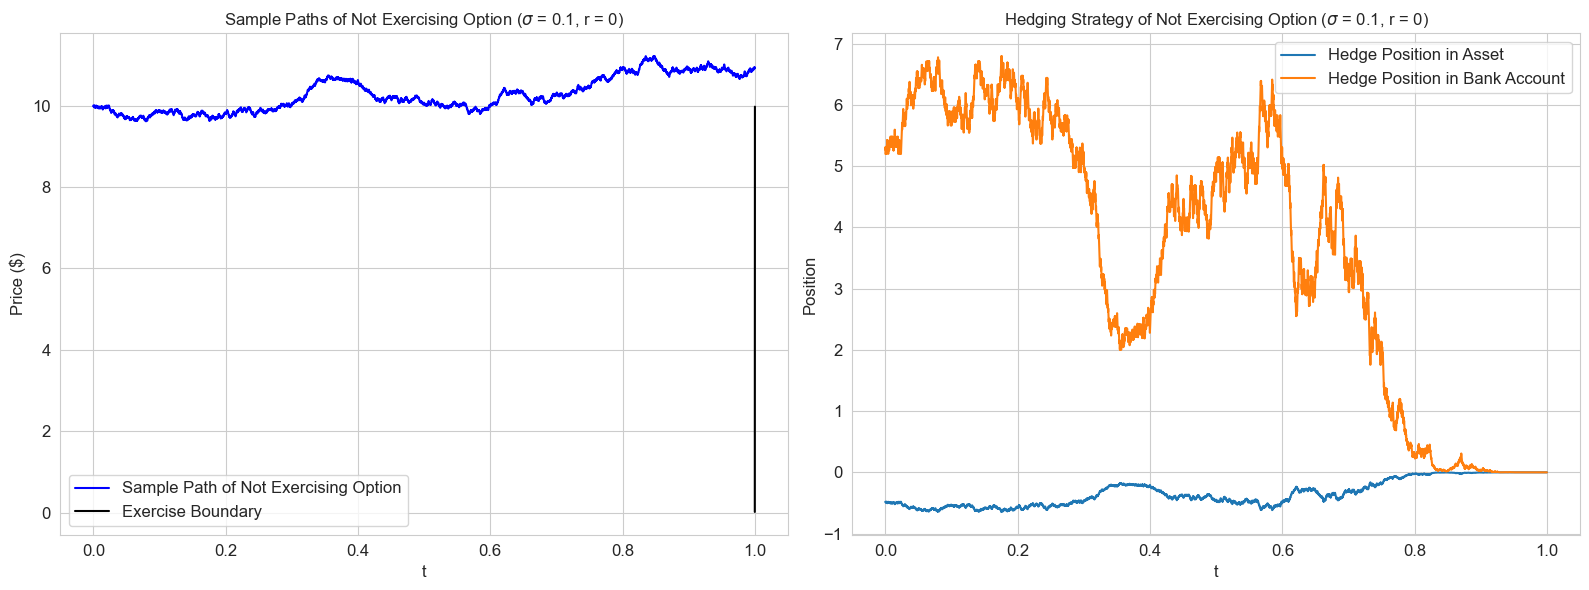

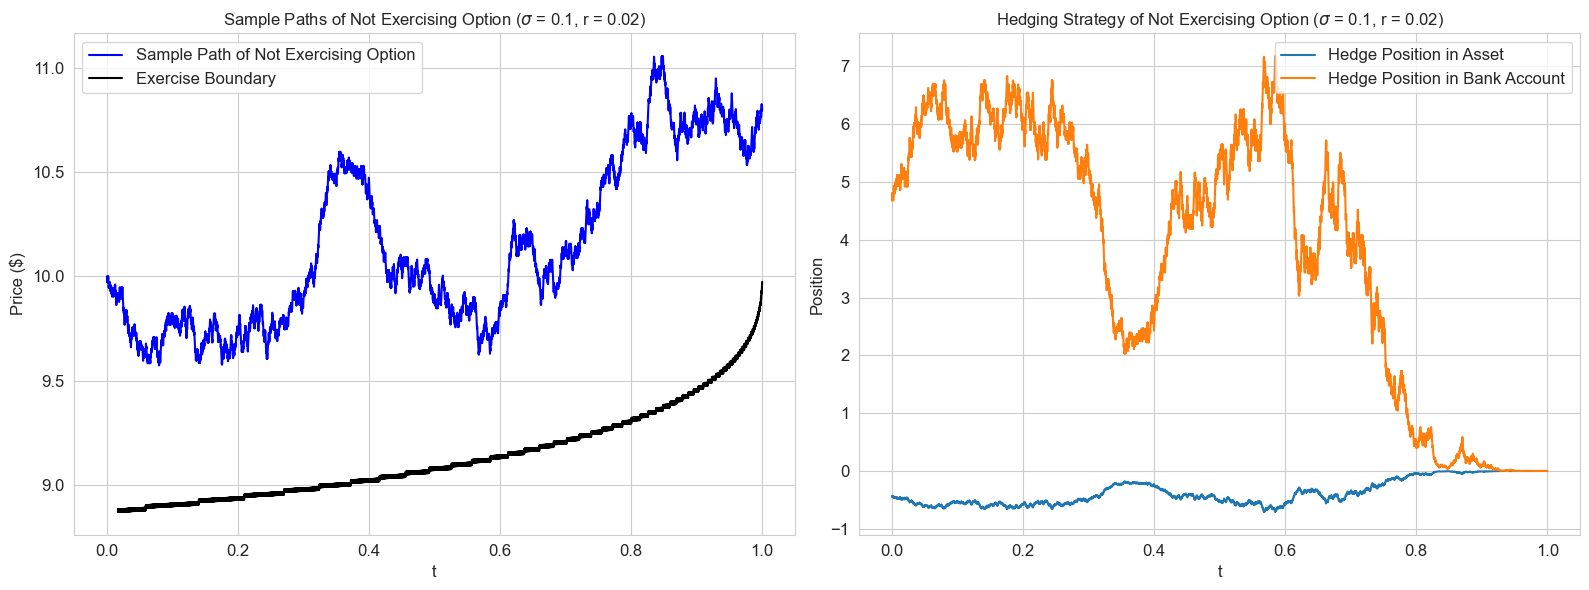

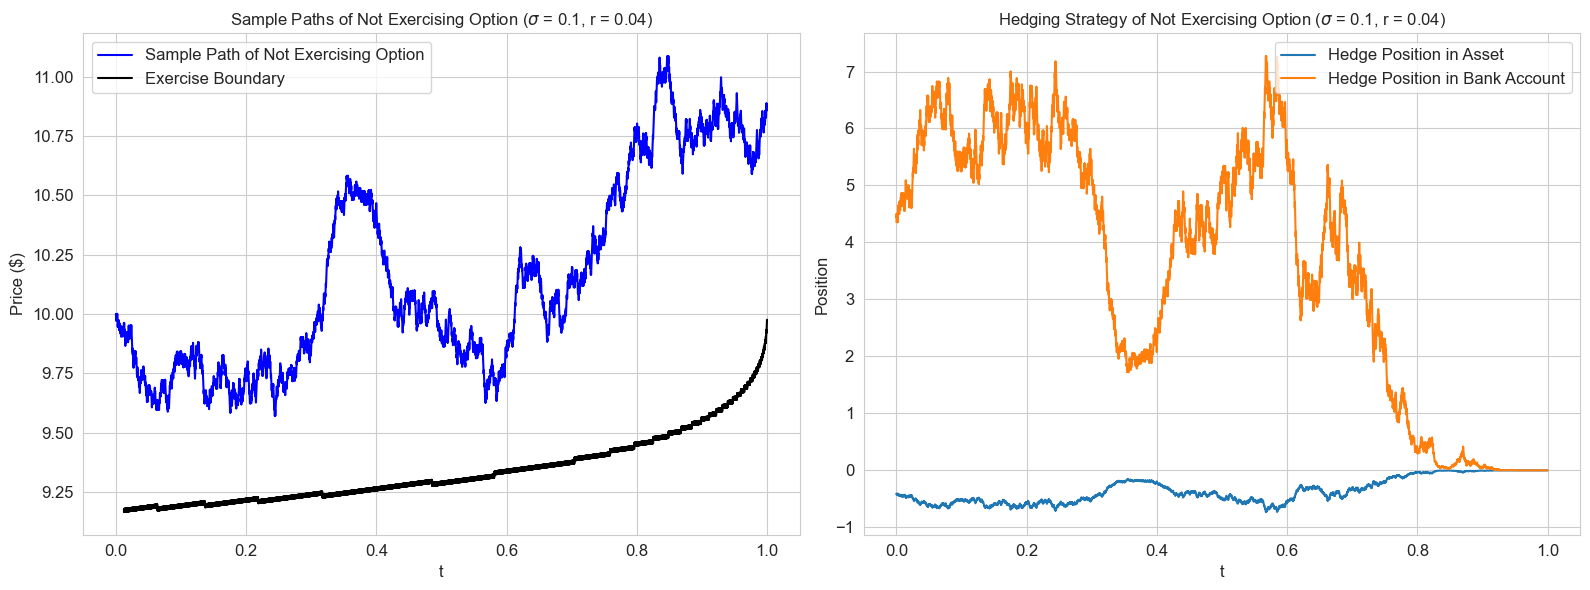

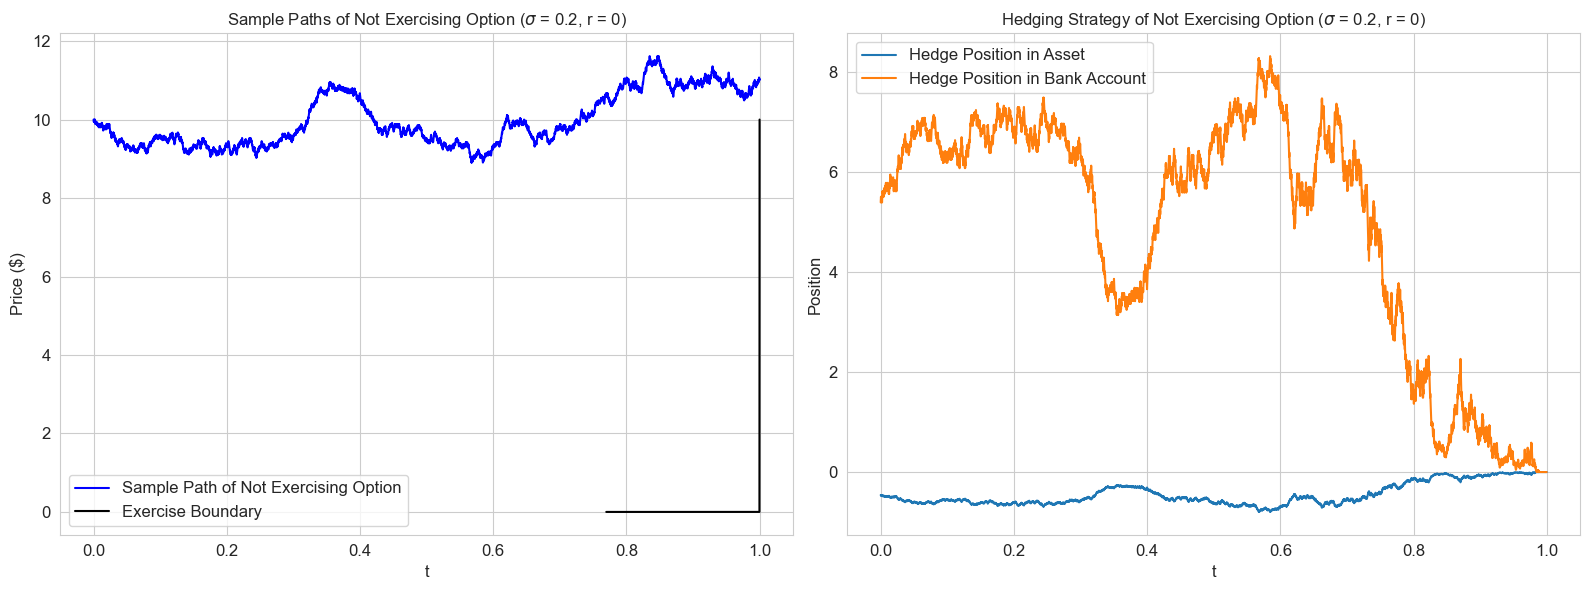

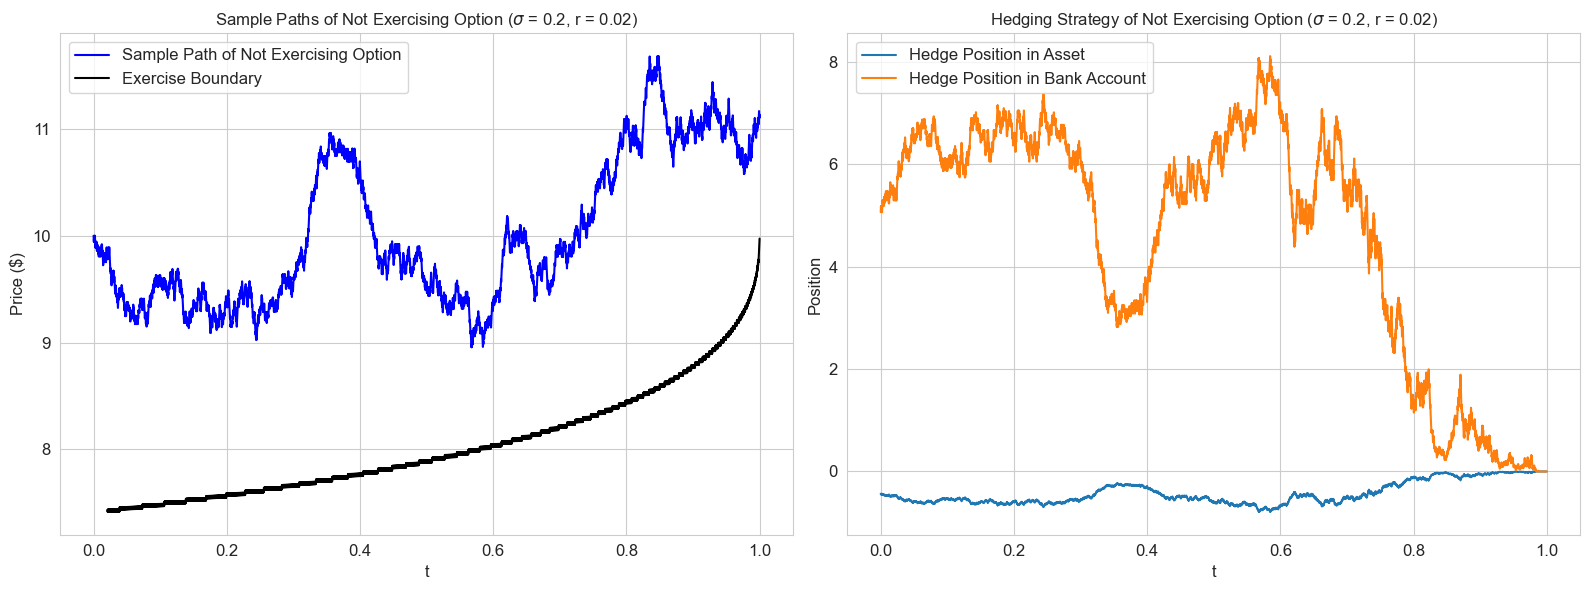

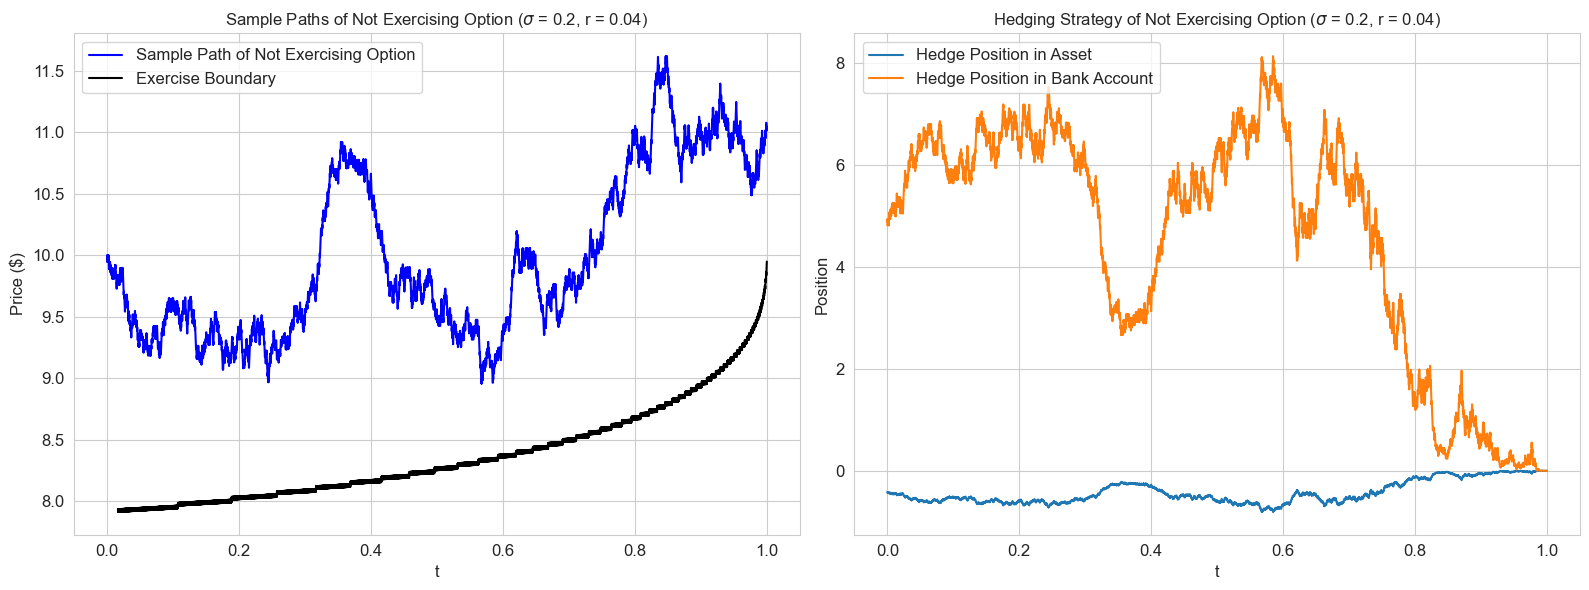

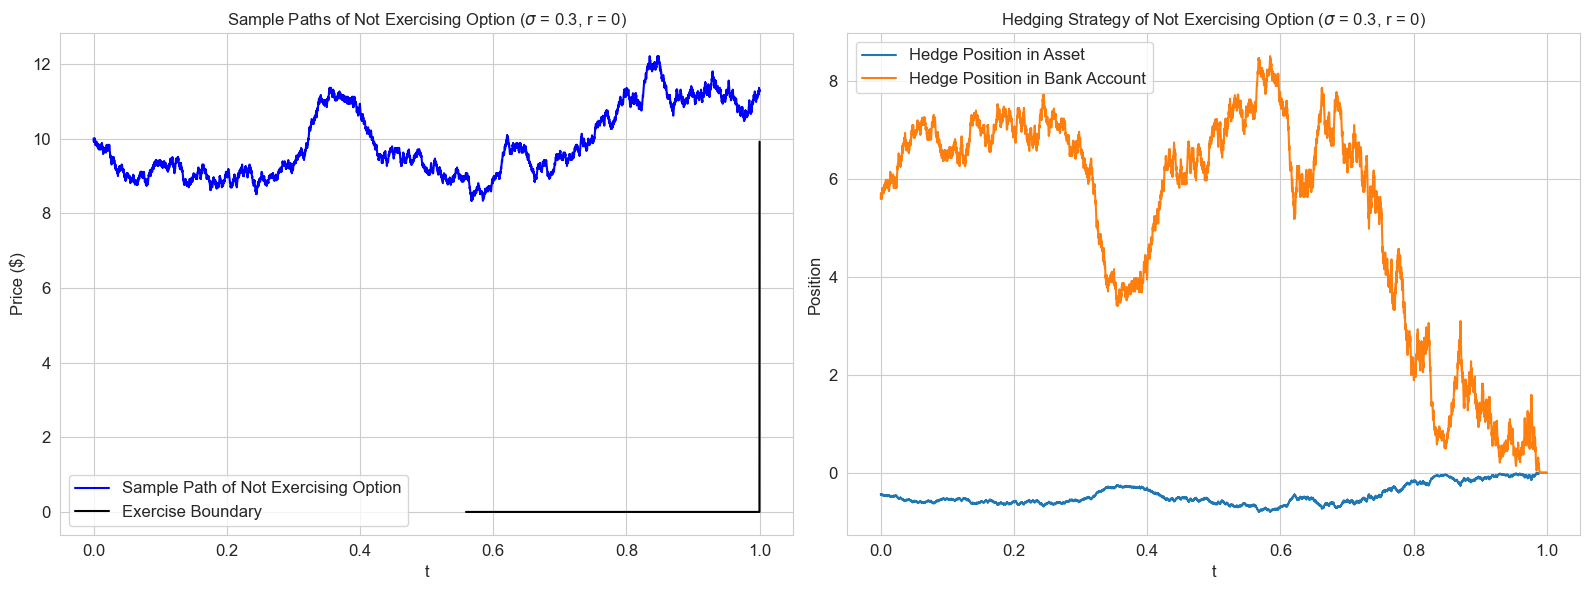

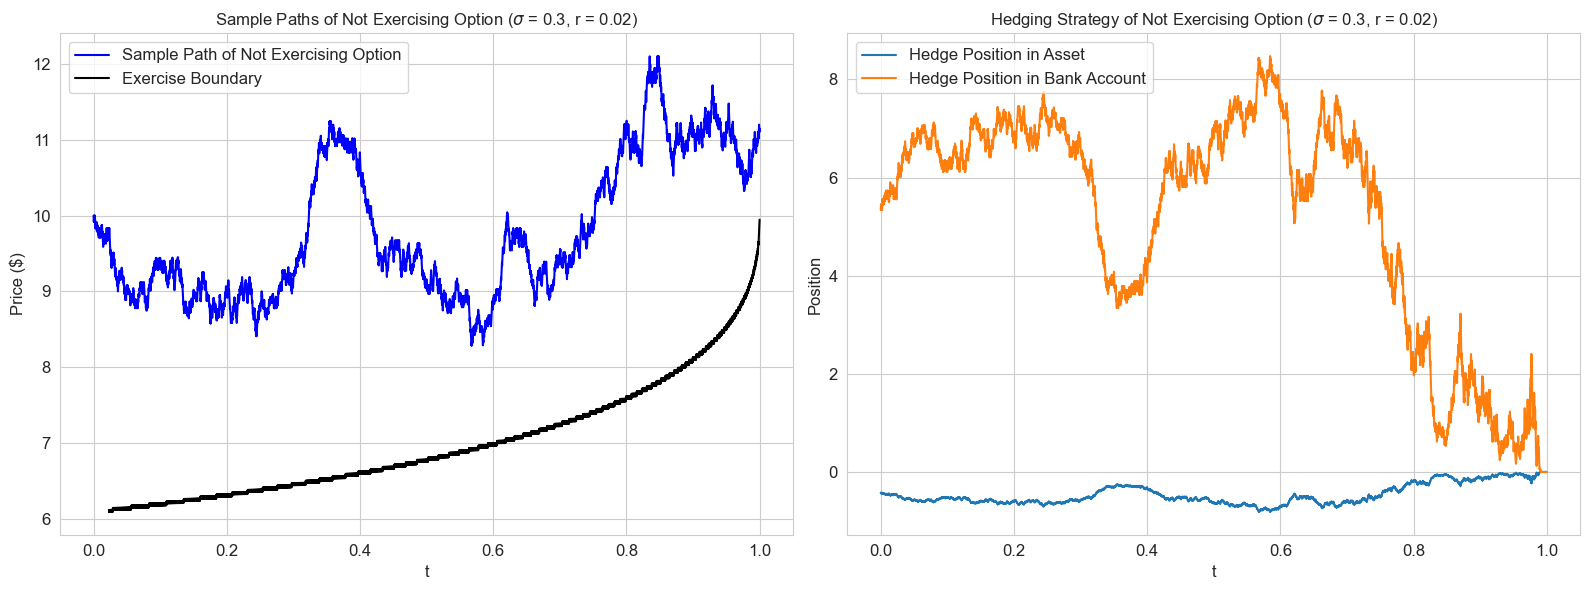

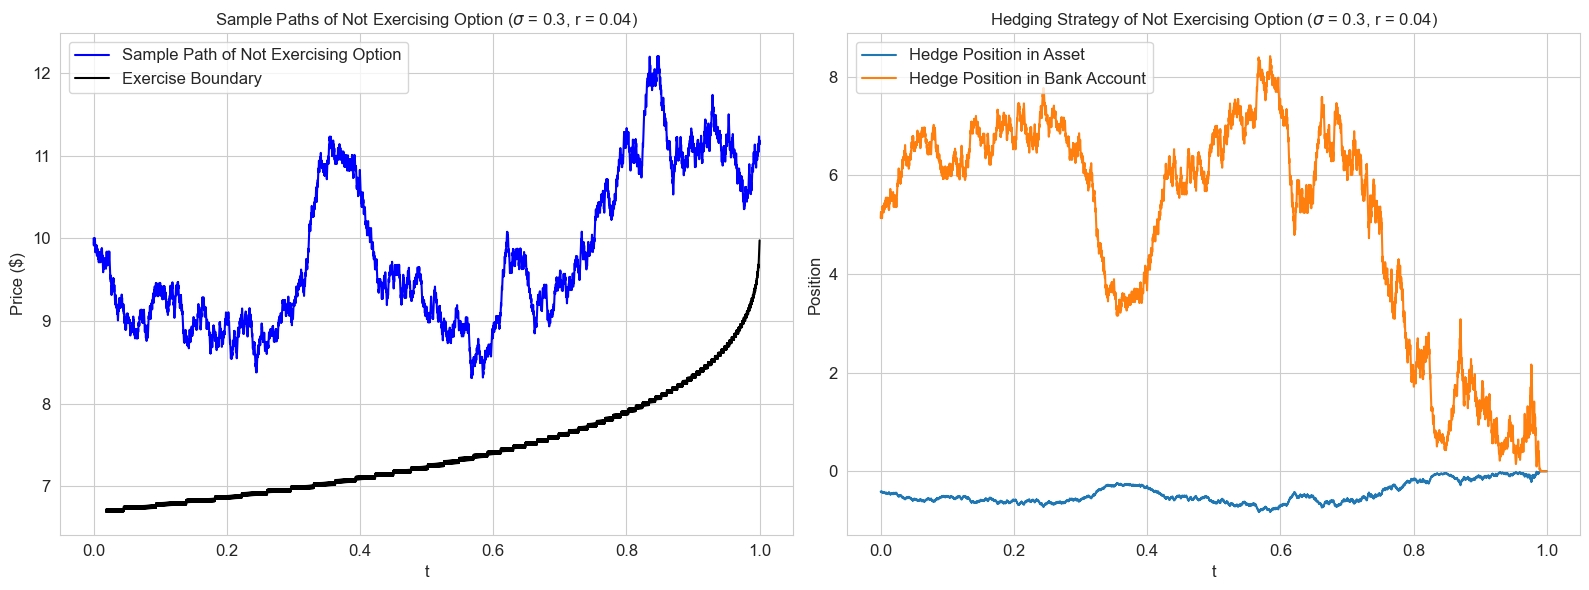

In [60]:
path = {(0.1, 0): [0, 60], (0.2, 0): [0, 60], (0.3, 0): [0, 60],
        (0.1, 0.02): [0, 60], (0.2, 0.02): [0, 60], (0.3, 0.02): [0, 60],
        (0.1, 0.04): [0, 60], (0.2, 0.04): [0, 60], (0.3, 0.04): [0, 60]}
lst_sigma = [0.1, 0.2, 0.3]
lst_r = [0, 0.02, 0.04]

for sigma in lst_sigma:
    for r in lst_r:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))  # Create a 1x2 grid

        np.random.seed(0)
        total_path = sample_path(S0, T, N, r, mu, sigma)
        t_array = np.arange(0, 5001)
        ax1.plot(t_array / N, total_path[path.get((sigma, r))[0], :].T, label='Sample Path of Not Exercising Option',
                 color='blue', )
        ax1.plot(grouped_timestamp.get((sigma, r))[1] / N, exercise_boundary.get((sigma, r)), label='Exercise Boundary',
                 color='black')
        ax1.set_title('Sample Paths of Not Exercising Option (' + r'$\sigma$ = ' + str(sigma) + ', r = ' + str(r) + ')')
        #ax1.set_ylim(0, 13)
        ax1.tick_params(axis='x', labelsize=12)
        ax1.tick_params(axis='y', labelsize=12)
        ax1.set_xlabel('t', fontsize=12)
        ax1.set_ylabel('Price ($)', fontsize=12)
        ax1.legend(fontsize=12)

        alpha, beta = generate_hedge_strategy(asset_tree.get((sigma, r)), Q_option_tree.get((sigma, r)),
                                              total_path[path.get((sigma, r))[0]], N, r)
        t_array = np.arange(0, 5000)
        ax2.plot(t_array / N, alpha, label='Hedge Position in Asset')
        ax2.plot(t_array / N, beta, label='Hedge Position in Bank Account')
        ax2.legend(fontsize=12)
        #ax2.set_ylim(-2, 10)
        ax2.tick_params(axis='x', labelsize=12)
        ax2.tick_params(axis='y', labelsize=12)
        ax2.set_xlabel('t', fontsize=12)
        ax2.set_ylabel('Position', fontsize=12)
        ax2.set_title(
            'Hedging Strategy of Not Exercising Option (' + r'$\sigma$ = ' + str(sigma) + ', r = ' + str(r) + ')')

        plt.tight_layout()
        plt.show()

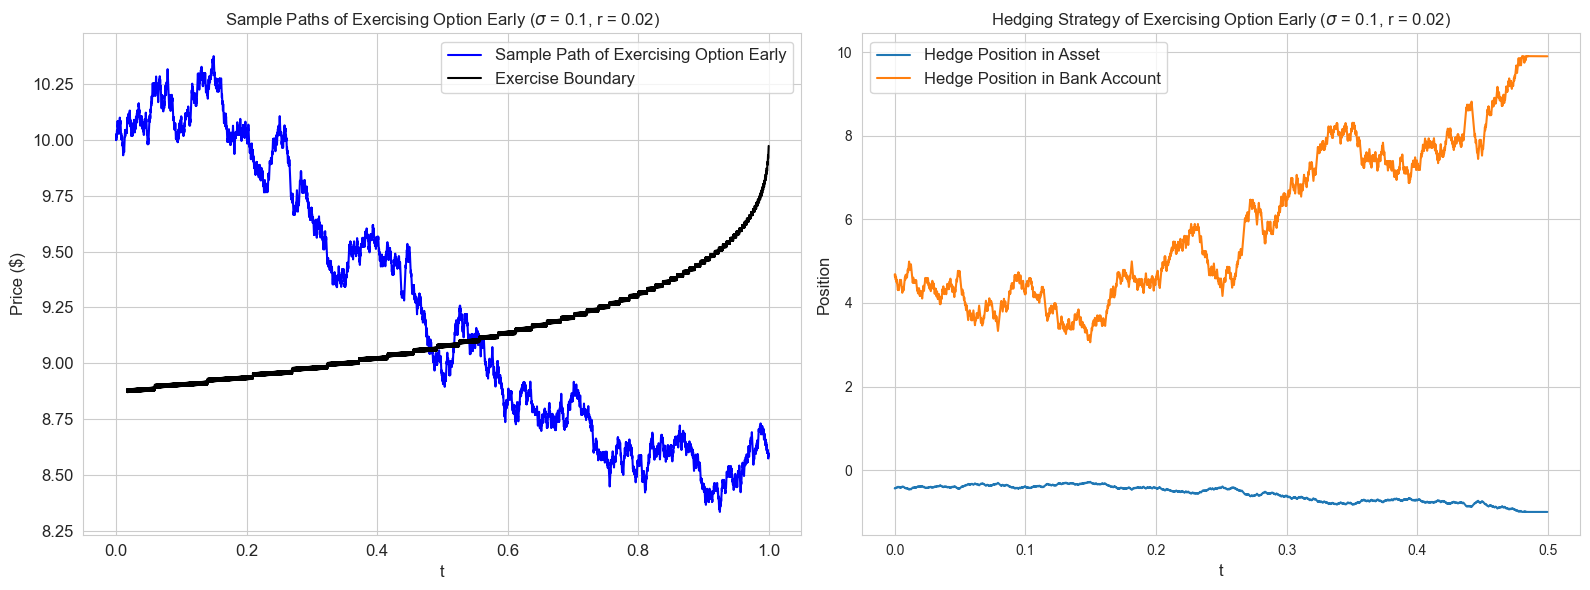

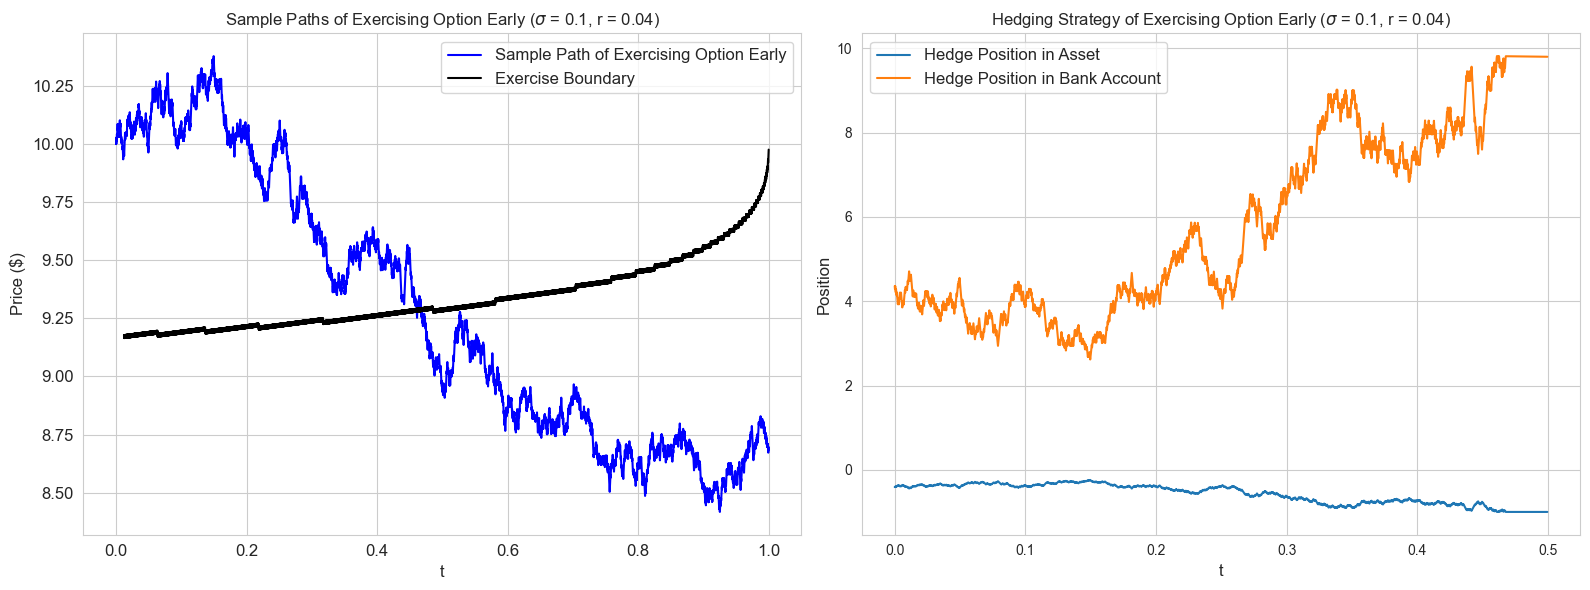

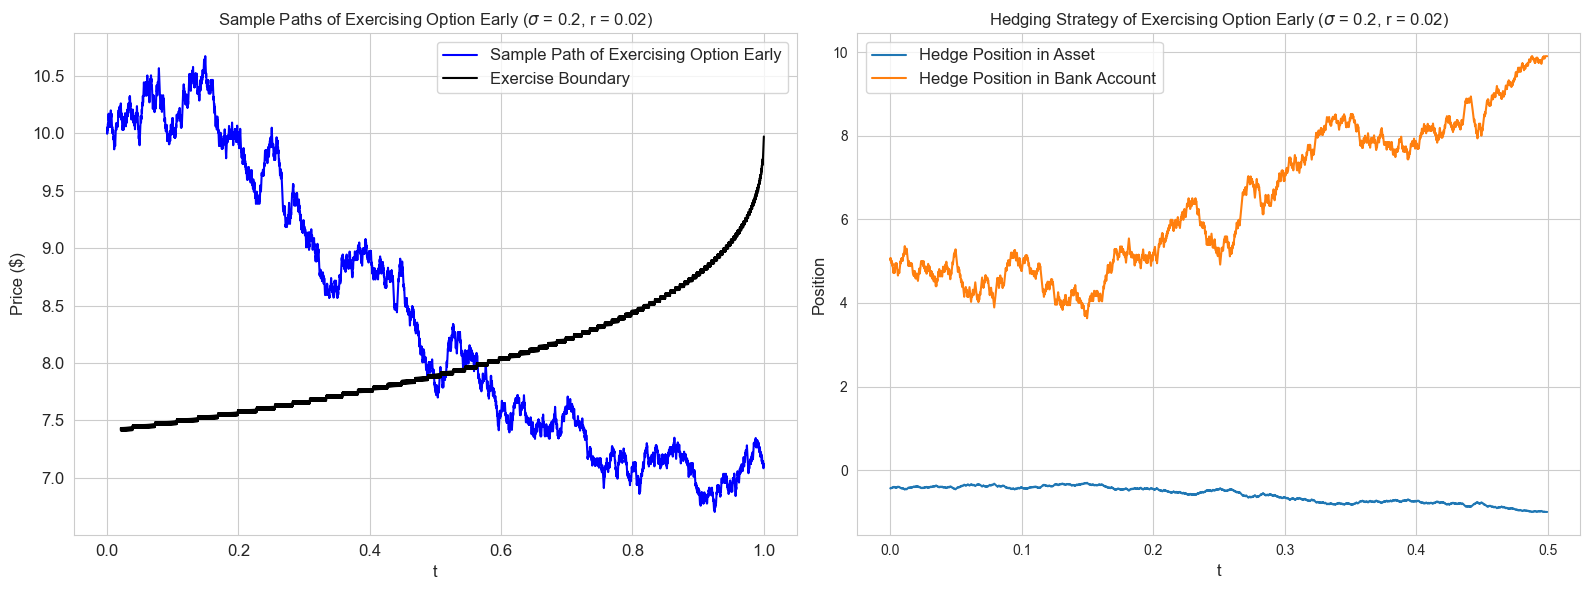

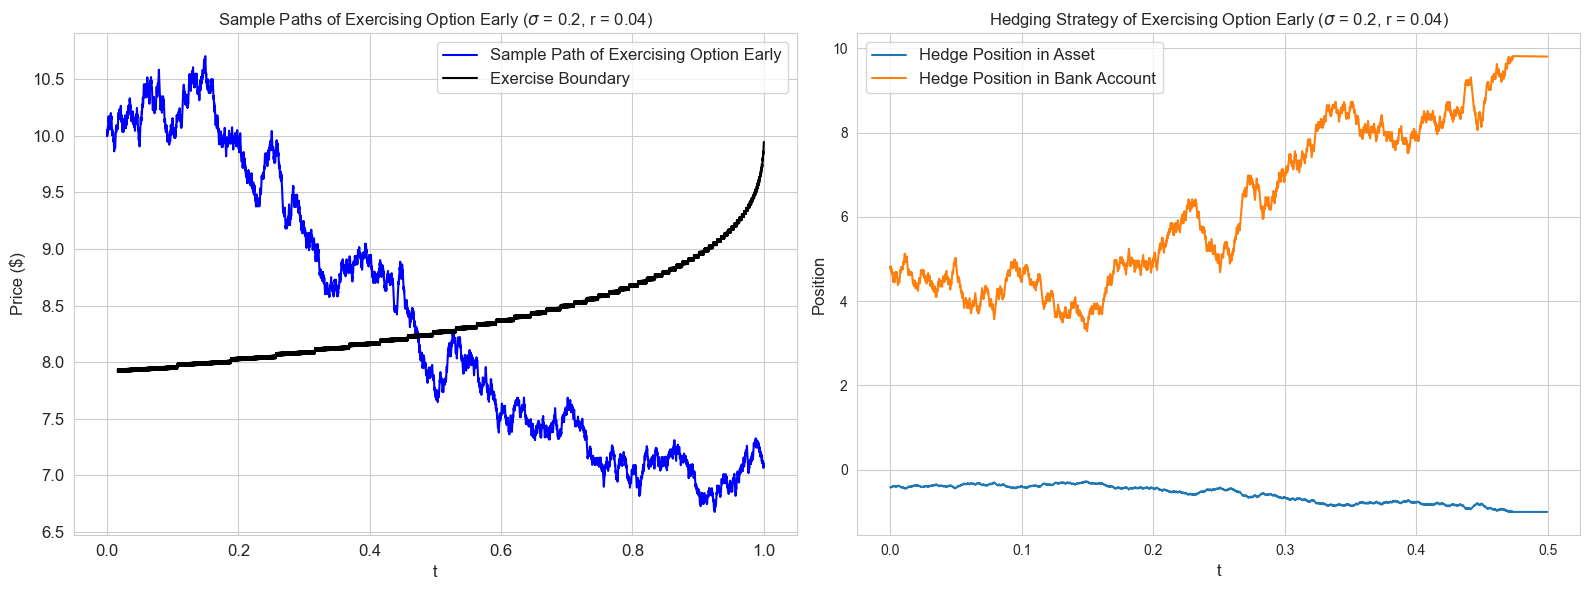

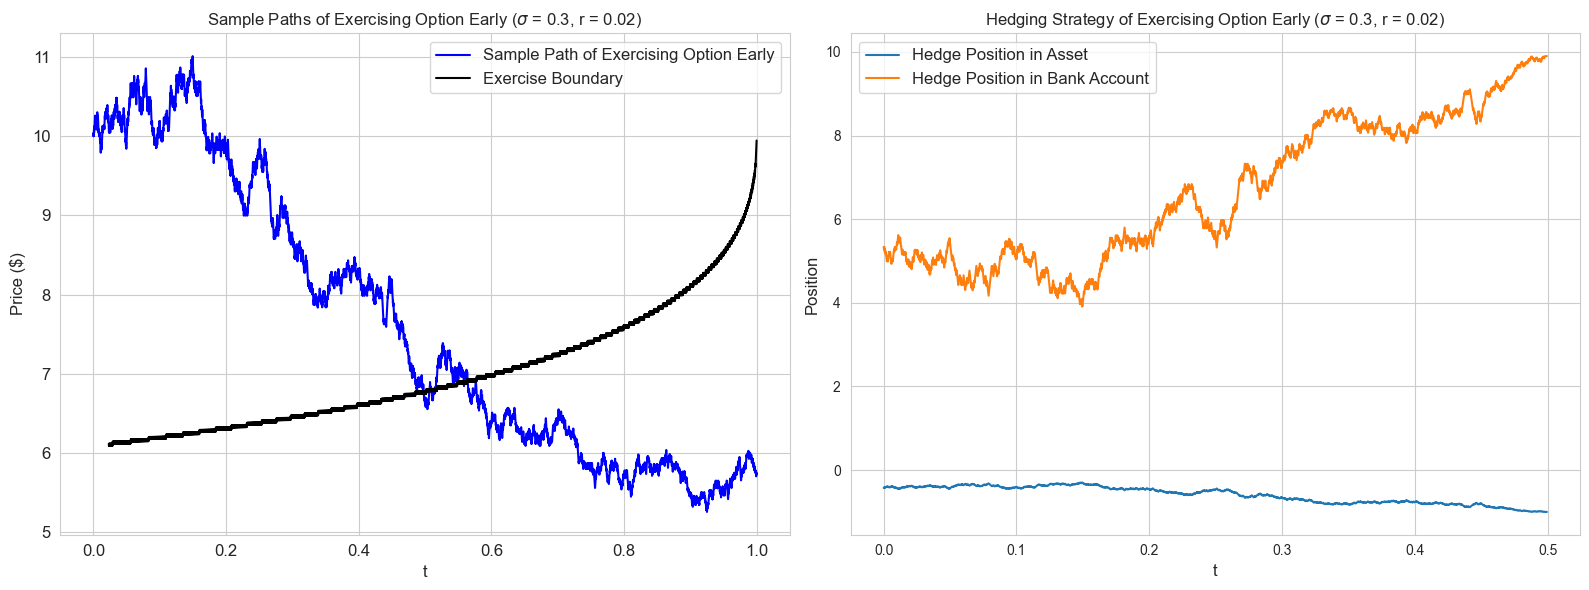

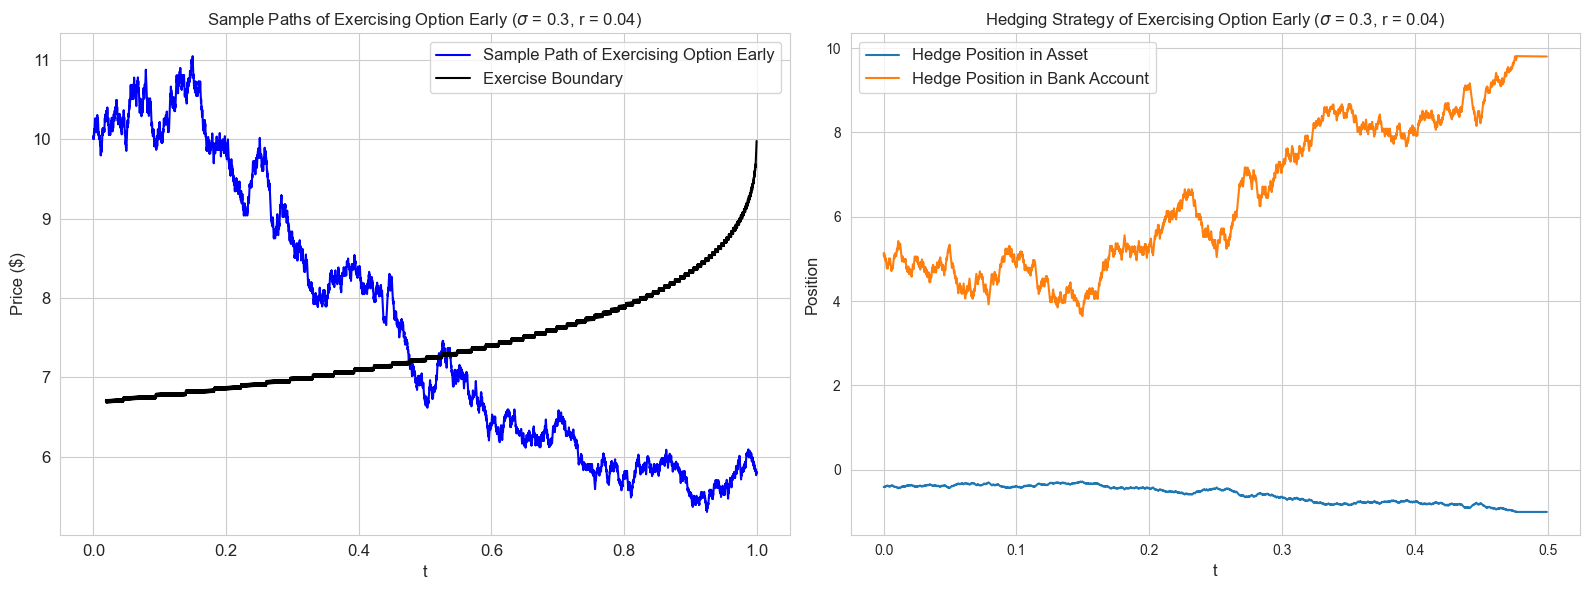

In [61]:
path = {(0.1, 0.02): [0, 60], (0.2, 0.02): [0, 60], (0.3, 0.02): [0, 60],
        (0.1, 0.04): [0, 60], (0.2, 0.04): [0, 60], (0.3, 0.04): [0, 60]}
lst_sigma = [0.1, 0.2, 0.3]
lst_r = [0.02, 0.04]

for sigma in lst_sigma:
    for r in lst_r:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))  # Create a 1x2 grid

        np.random.seed(0)
        total_path = sample_path(S0, T, N, r, mu, sigma)
        t_array = np.arange(0, 5001)
        ax1.plot(t_array / N, total_path[path.get((sigma, r))[1], :].T, label='Sample Path of Exercising Option Early',
                 color='blue')
        ax1.plot(grouped_timestamp.get((sigma, r))[1] / N, exercise_boundary.get((sigma, r)), label='Exercise Boundary',
                 color='black')
        ax1.set_title(
            'Sample Paths of Exercising Option Early (' + r'$\sigma$ = ' + str(sigma) + ', r = ' + str(r) + ')')
        ax1.tick_params(axis='x', labelsize=12)
        ax1.tick_params(axis='y', labelsize=12)
        ax1.set_xlabel('t', fontsize=12)
        ax1.set_ylabel('Price ($)', fontsize=12)
        ax1.legend(fontsize=12)

        alpha, beta = generate_hedge_strategy(asset_tree.get((sigma, r)), Q_option_tree.get((sigma, r)),
                                              total_path[path.get((sigma, r))[1]], N, r)
        t_array = np.arange(0, 5000)
        location = np.where(np.array(alpha_early) == -1)[0][0]
        ax2.plot(t_array[:location] / N, alpha[:location], label='Hedge Position in Asset')
        ax2.plot(t_array[:location] / N, beta[:location], label='Hedge Position in Bank Account')
        ax2.legend(fontsize=12)
        ax1.tick_params(axis='x', labelsize=12)
        ax1.tick_params(axis='y', labelsize=12)
        ax2.set_xlabel('t', fontsize=12)
        ax2.set_ylabel('Position', fontsize=12)
        ax2.set_title(
            'Hedging Strategy of Exercising Option Early (' + r'$\sigma$ = ' + str(sigma) + ', r = ' + str(r) + ')')

        plt.tight_layout()
        plt.show()

# 2.b.1 P&L Distribution: 
Three situations:
1. if we did not hit the exercise boundary and execute the option, there is nothing to gain, pure losses at the exact value of the option at t=0. 
2. (rare) if we hit the exercise at the very end (i.e. t=5000), its still expiring worthless
3. if we did execute, our P&L is the K-asset discounted back to t=0 then minus the option price
probability of exercise needs to account for the probability of stock price never reached the execution boundary

Note that if the executed profit discount to t=0 is less than the option price, you lose money even if you execute

In [62]:
def execution_details(sample_path, grouped_timestamp, execution_boundary, Q_option_tree, K, r, N):
    # call execution boundary calculation before this function
    exercise_dic = {}
    padding_space = grouped_timestamp[1][0]

    for idx, path in enumerate(sample_path):
        filled_execution_boundary = np.zeros(
            N + 1)  # when r=0, execution boundary have missing values,we fill those with 0
        filled_execution_boundary[grouped_timestamp[1]] = execution_boundary
        execution_time = np.where(np.abs(path[padding_space:] - filled_execution_boundary[padding_space:]) < 0.0001)[0]
        if len(execution_time) == 0:
            # no execution
            continue
        else:
            execution_time = execution_time[0]
            if execution_time + padding_space == 5000:
                # exercise at the very end, expiring worthless
                continue
            # Execute before expiry. We calculate the P&L and store it in a dictionary with key=idx, value=[execution_time+padding_space, P&L]
            profit = (K - execution_boundary[execution_time]) * np.exp(-r * (execution_time + padding_space) / N) - \
                     Q_option_tree[0, 0]
            exercise_dic[idx] = [execution_time + padding_space, profit]
    return pd.DataFrame(exercise_dic).T.reset_index().rename(
        columns={'index': 'path', 0: 'execution_time', 1: 'profit'})

In [63]:
# Setting for 20% Vol, 2% r
T = 1
S0 = 10
mu = 0.05
sigma = 0.2
r = 0.02
N = 5000
# N = 100
K = 10

np.random.seed(1)
sample_path_20vol = sample_path(S0, T, N, r, mu, sigma)
asset_tree, Q_option_tree = asset_n_option_tree_B_numeraire(T, S0, sigma, r, N, K)
grouped_timestamp, execution_boundary = execution_boundary_calculation(K, asset_tree, Q_option_tree)
exercise_df = execution_details(sample_path_20vol, grouped_timestamp, execution_boundary, Q_option_tree, K, r, N)

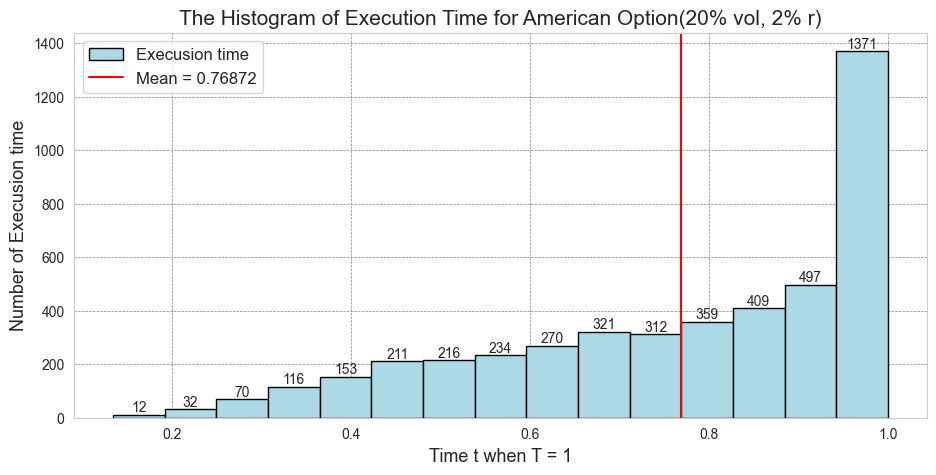

In [64]:
try:
    plt.figure(figsize=(11, 5))

    hist, bins, _ = plt.hist(exercise_df['execution_time'] / 5000, bins=15, label='Execusion time',
                             color='lightblue', edgecolor='black')
    # Add values on top of each bar
    for i in range(len(hist)):
        plt.text((bins[i] + bins[i + 1]) / 2, hist[i], str(int(hist[i])), ha='center', va='bottom')

    plt.axvline(exercise_df['execution_time'].mean() / 5000, color='red',
                label=f"Mean = {exercise_df['execution_time'].mean() / 5000:.5f}")
    plt.grid(linewidth=0.5, linestyle='--', color='gray', zorder=1)
    plt.xlabel('Time t when T = 1', fontsize=13)
    plt.ylabel('Number of Execusion time', fontsize=13)
    plt.title("The Histogram of Execution Time for American Option(20% vol, 2% r)", fontsize=15)
    plt.legend(fontsize=12)
    plt.show()
except KeyError as e:
    if e.args[0] == 'execution_time':
        print('No execution')
    else:
        print('other error')
        raise e

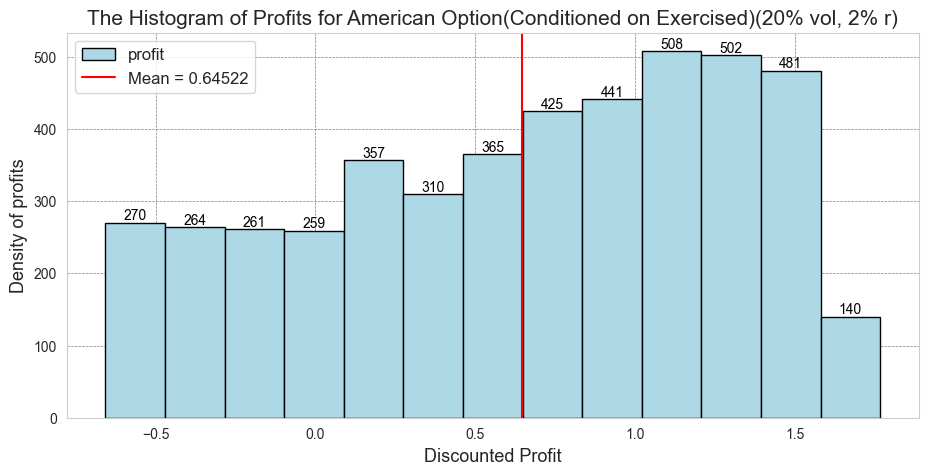

In [65]:
try:
    plt.figure(figsize=(11, 5))
    hist, bins, _ = plt.hist(exercise_df['profit'], bins=13, label='profit',
                             color='lightblue', edgecolor='black')

    # Add values on top of each bar
    for i in range(len(hist)):
        plt.text((bins[i] + bins[i + 1]) / 2, hist[i], str(int(hist[i])), ha='center', va='bottom', color='black')
    plt.axvline(exercise_df['profit'].mean(), color='red', label=f"Mean = {exercise_df['profit'].mean():.5f}")
    plt.grid(linewidth=0.5, linestyle='--', color='gray', zorder=1)
    plt.xlabel('Discounted Profit', fontsize=13)
    plt.ylabel('Density of profits', fontsize=13)
    plt.title("The Histogram of Profits for American Option(Conditioned on Exercised)(20% vol, 2% r)", fontsize=15)
    plt.legend(fontsize=12)
    plt.show()
except KeyError as e:
    if e.args[0] == 'profit':
        print('No execution')
    else:
        print('other error')
        raise e

Note for plot: plot the histogram of execution time and profit with title, axis name, legend name, value for each bar. put the value of the mean of profit on the plot

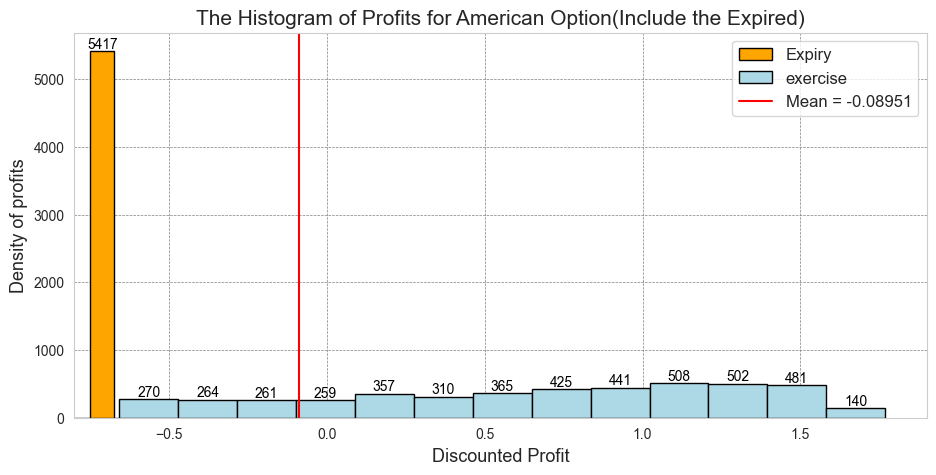

In [66]:
try:
    plt.figure(figsize=(11, 5))

    hist1, bins1, _ = plt.hist([-Q_option_tree[0, 0]] * (10_000 - len(exercise_df)), bins=13,
                               label='Expiry', color='orange', edgecolor='black')

    bar_index = 6
    plt.text(bins1[bar_index] + (bins1[bar_index + 1] - bins1[bar_index]) / 2, hist1[bar_index],
             str(int(hist1[bar_index])),
             ha='center', va='bottom', color='black')
    plt.xlim(-1, -0.5)

    hist, bins, _ = plt.hist(exercise_df['profit'].values, bins=13, label='exercise',
                             color='lightblue', edgecolor='black')
    for i in range(len(hist)):
        plt.text((bins[i] + bins[i + 1]) / 2, hist[i], str(int(hist[i])),
                 ha='center', va='bottom', color='black')

    # plt.hist([-Q_option_tree[0, 0]] * (10_000 - len(exercise_df)), label='expiry')
    all_path_pnl = np.hstack([exercise_df['profit'].values, [-Q_option_tree[0, 0]] * (10_000 - len(exercise_df))])
    plt.axvline(all_path_pnl.mean(), color='red',
                label=f"Mean = {all_path_pnl.mean():.5f}")
    plt.xlim(-0.8, 1.9)
    plt.grid(linewidth=0.5, linestyle='--', color='gray', zorder=1)
    plt.xlabel('Discounted Profit', fontsize=13)
    plt.ylabel('Density of profits', fontsize=13)
    plt.title("The Histogram of Profits for American Option(Include the Expired)", fontsize=15)
    plt.legend(fontsize=12)
    plt.show()
except KeyError as e:
    if e.args[0] == 'profit':
        print('No execution')
    else:
        print('other error')
        raise e

# 2b.2 Setting for different 10, 20, 30% Vol, and 0%, 2%, 4% r

In [67]:
def time_plot(sigma, r):
    try:
        plt.figure(figsize = (11,5))

        hist, bins, _ = plt.hist(exercise_df['execution_time']/5000, bins=15, label = 'Execusion time',
                                color = 'lightblue', edgecolor = 'black')
        # Add values on top of each bar
        for i in range(len(hist)):
            plt.text((bins[i] + bins[i+1]) / 2, hist[i], str(int(hist[i])), ha='center', va='bottom')

        plt.axvline(exercise_df['execution_time'].mean()/5000, color='red', label=f"Mean = {exercise_df['execution_time'].mean()/5000:.5f}")
        plt.grid(linewidth=0.5, linestyle='--', color='gray', zorder=1)
        plt.xlabel('Time t when T = 1', fontsize = 13)
        plt.ylabel('Number of Execusion time', fontsize = 13)
        plt.title(f"The Histogram of Execution Time for American Option(vol = {sigma*100}%, r = {r * 100}%)", fontsize = 15)
        plt.legend(fontsize = 12)
        plt.show()
    except KeyError as e:
        if e.args[0] == 'execution_time':
            print('No execution')
        else:
            print('other error')
            raise e
    return

def PnL_plot_condition(sigma, r):
    try:
        plt.figure(figsize = (11,5))
        hist, bins, _ = plt.hist(exercise_df['profit'], bins=13, label = 'Profit',
                                color = 'lightblue', edgecolor = 'black')

        # Add values on top of each bar
        for i in range(len(hist)):
            plt.text((bins[i] + bins[i+1]) / 2, hist[i], str(int(hist[i])), ha='center', va='bottom', color = 'black')
        plt.axvline(exercise_df['profit'].mean(), color='red', label=f"Mean = {exercise_df['profit'].mean():.5f}")
        plt.grid(linewidth=0.5, linestyle='--', color='gray', zorder=1)
        plt.xlabel('Discounted Profit', fontsize = 13)
        plt.ylabel('Density of profits', fontsize = 13)
        plt.title(f"The Histogram of Profits for American Option(Conditioned on Exercised)(vol = {sigma * 100}%, r = {r * 100}%)", fontsize = 15)
        plt.legend(fontsize = 12)
        plt.show()
    except KeyError as e:
        if e.args[0] == 'profit':
            print('No execution')
        else:
            print('other error')
            raise e

No execution
No execution


<Figure size 1100x500 with 0 Axes>

<Figure size 1100x500 with 0 Axes>

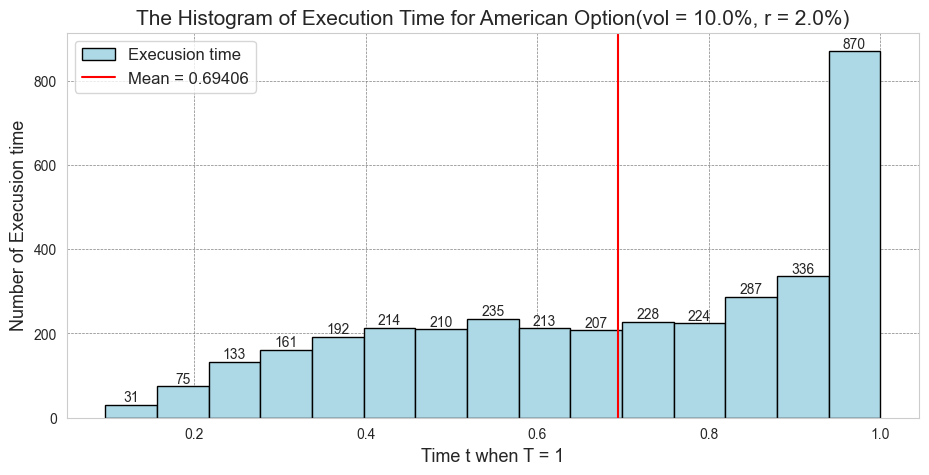

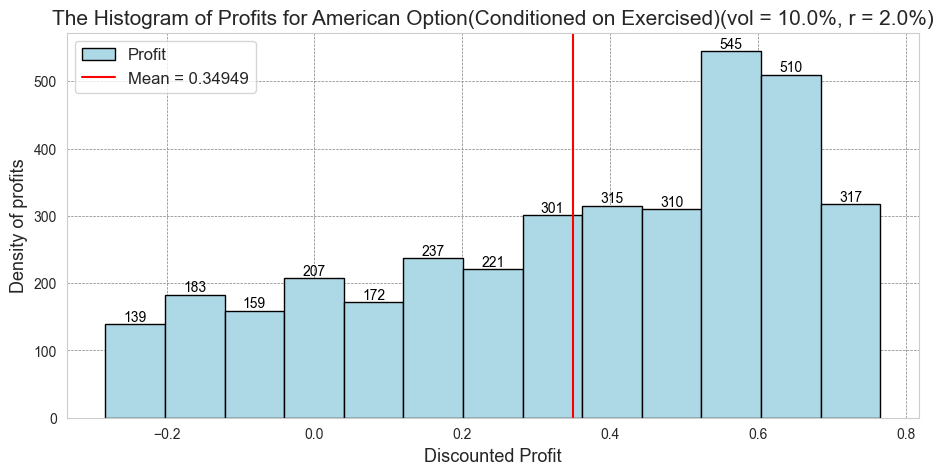

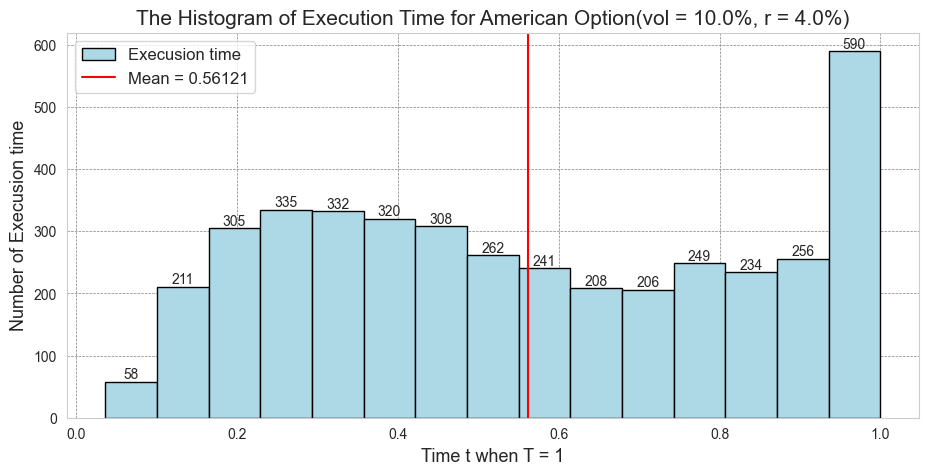

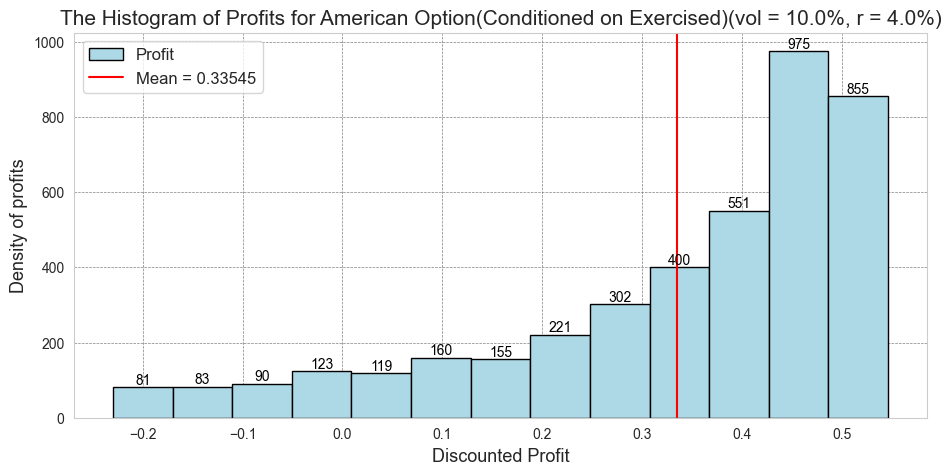

No execution
No execution


<Figure size 1100x500 with 0 Axes>

<Figure size 1100x500 with 0 Axes>

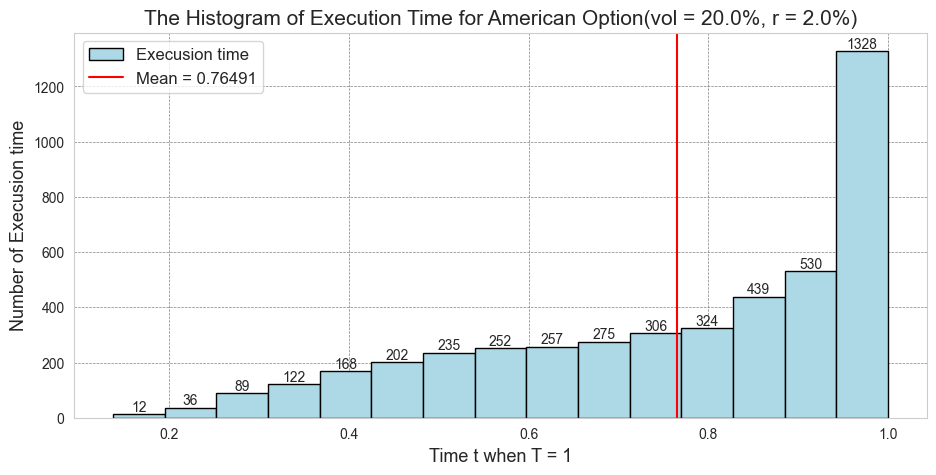

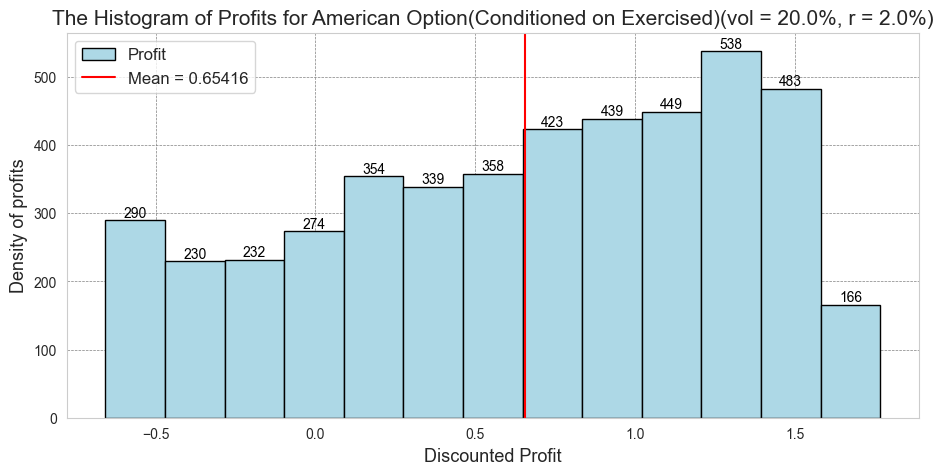

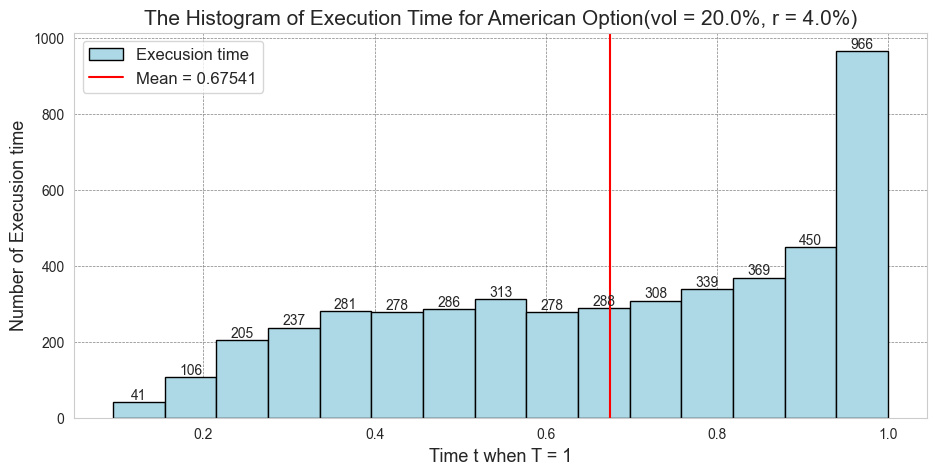

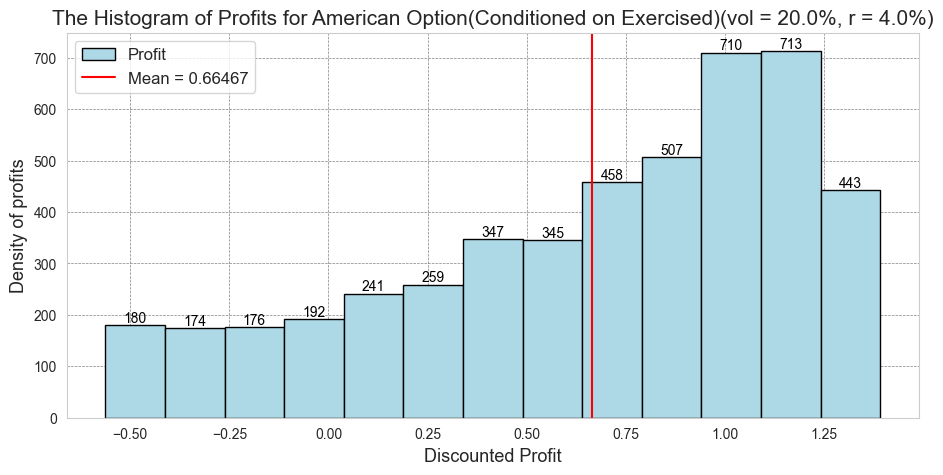

No execution
No execution


<Figure size 1100x500 with 0 Axes>

<Figure size 1100x500 with 0 Axes>

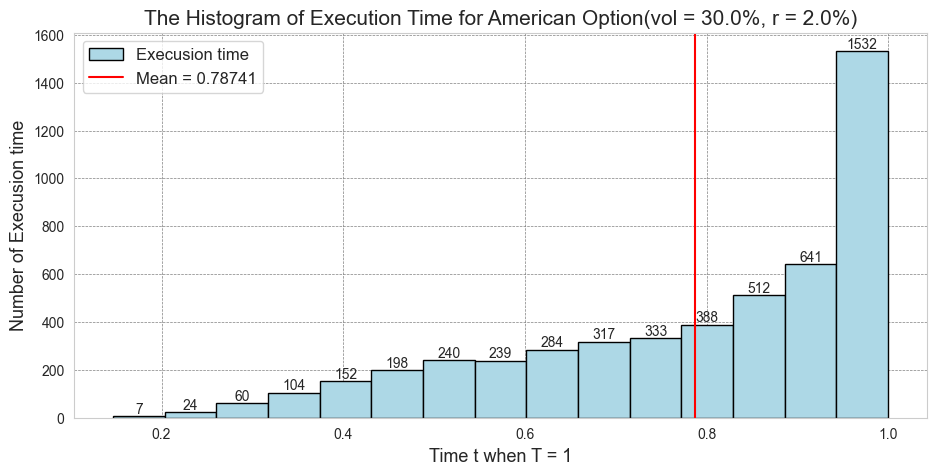

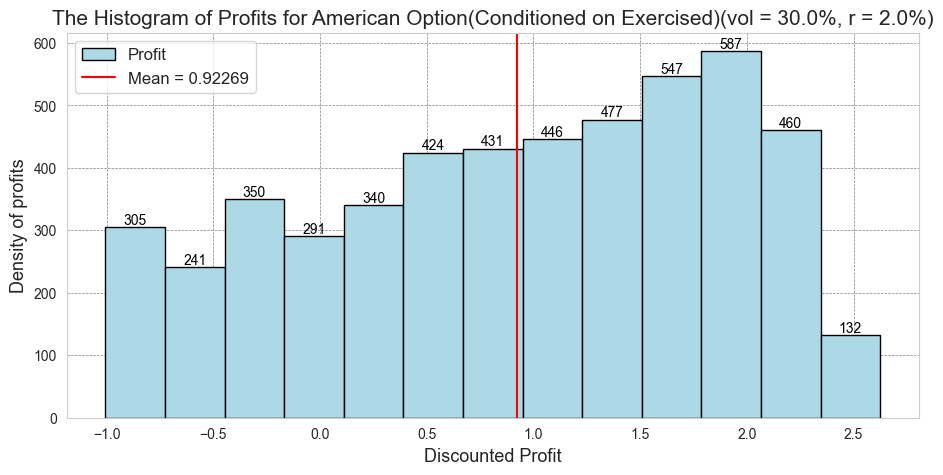

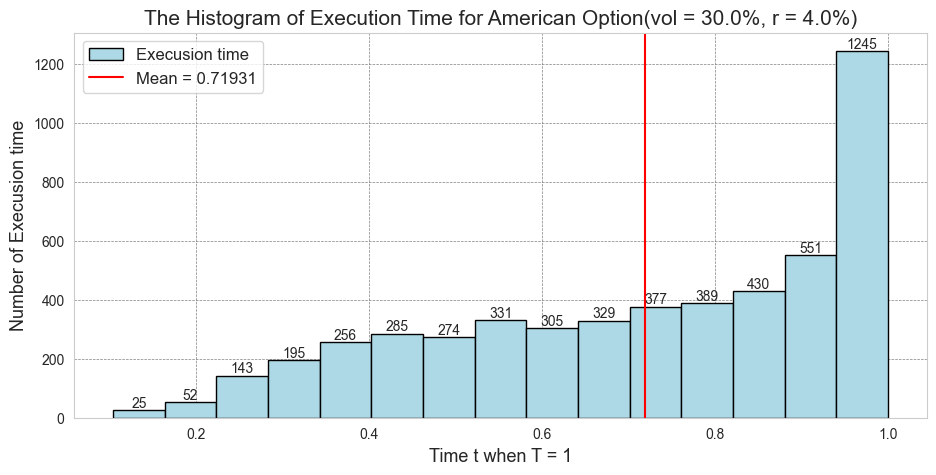

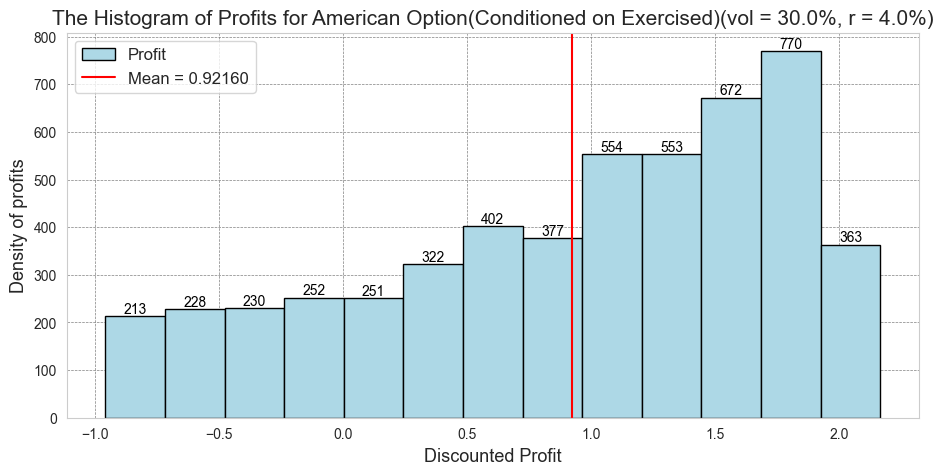

In [68]:
sigma_l = [0.1, 0.2, 0.3]
r_l = [0, 0.02, 0.04]
xlim_l = []
for sigma in sigma_l:
  for r in r_l:
    # Setting for 20% Vol, 2% r
    T = 1
    S0 = 10
    mu = 0.05
    sigma = sigma  # Modified
    r = r     # Modified
    N = 5000
    # N = 100
    K = 10

    #@title Update option functions
    np.random.seed(2)
    sample_path_40vol = sample_path(S0, T, N, r, mu, sigma)
    asset_tree, Q_option_tree = asset_n_option_tree_B_numeraire(T, S0, sigma, r, N, K)
    grouped_timestamp, execution_boundary = execution_boundary_calculation(K, asset_tree, Q_option_tree)
    exercise_df = execution_details(sample_path_40vol, grouped_timestamp, execution_boundary, Q_option_tree, K, r, N)
    time_plot(sigma, r)
    PnL_plot_condition(sigma, r)
    # PnL_plot(sigma, r)

## Distributions for all PnL

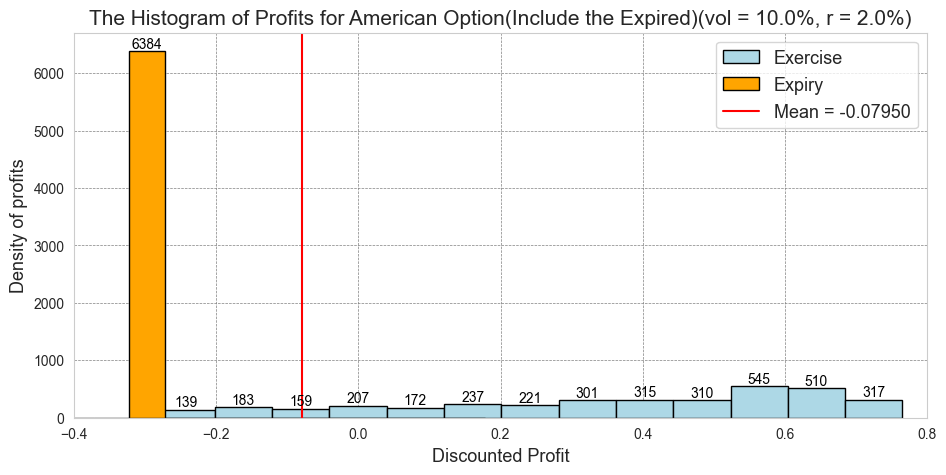

In [69]:
T = 1
S0 = 10
mu = 0.05
sigma = 0.1  # Modified
r = 0.02     # Modified
N = 5000
# N = 100
K = 10

#@title Update option functions for PnL dist all
np.random.seed(2)
sample_path_40vol = sample_path(S0, T, N, r, mu, sigma)
asset_tree, Q_option_tree = asset_n_option_tree_B_numeraire(T, S0, sigma, r, N, K)
grouped_timestamp, execution_boundary = execution_boundary_calculation(K, asset_tree, Q_option_tree)
exercise_df = execution_details(sample_path_40vol, grouped_timestamp, execution_boundary, Q_option_tree, K, r, N)
# time_plot(sigma, r)
# PnL_plot_condition(sigma, r)
# # PnL_plot(sigma, r)
try:
    plt.figure(figsize = (11,5))

    hist, bins, _ = plt.hist(exercise_df['profit'].values, bins=13, label = 'Exercise',
                            color = 'lightblue', edgecolor = 'black')
    for i in range(len(hist)):
        plt.text((bins[i] + bins[i+1]) / 2, hist[i], str(int(hist[i])),
                ha='center', va='bottom', color = 'black')

    hist1, bins1, _ = plt.hist([-Q_option_tree[0, 0]] * (10_000 - len(exercise_df)), bins=20,
                            label = 'Expiry', color = 'orange', edgecolor = 'black')

    bar_index = 10
    plt.text(bins1[bar_index] + (bins1[bar_index + 1] - bins1[bar_index]) / 2, hist1[bar_index], str(int(hist1[bar_index])),
            ha='center', va='bottom', color = 'black')

    # plt.hist([-Q_option_tree[0, 0]] * (10_000 - len(exercise_df)), label='expiry')
    all_path_pnl = np.hstack([exercise_df['profit'].values, [-Q_option_tree[0, 0]] * (10_000 - len(exercise_df))])
    plt.axvline(all_path_pnl.mean(), color='red',
                label=f"Mean = {all_path_pnl.mean():.5f}")
    plt.xlim(-0.4, 0.8)
    plt.grid(linewidth=0.5, linestyle='--', color='gray', zorder=1)
    plt.xlabel('Discounted Profit', fontsize = 13)
    plt.ylabel('Density of profits', fontsize = 13)
    plt.title(f"The Histogram of Profits for American Option(Include the Expired)(vol = {sigma * 100}%, r = {r * 100}%)", fontsize = 15)
    plt.legend(fontsize = 13)
    plt.show()
except KeyError as e:
    if e.args[0] == 'profit':
        print('No execution')
    else:
        print('other error')
        raise e

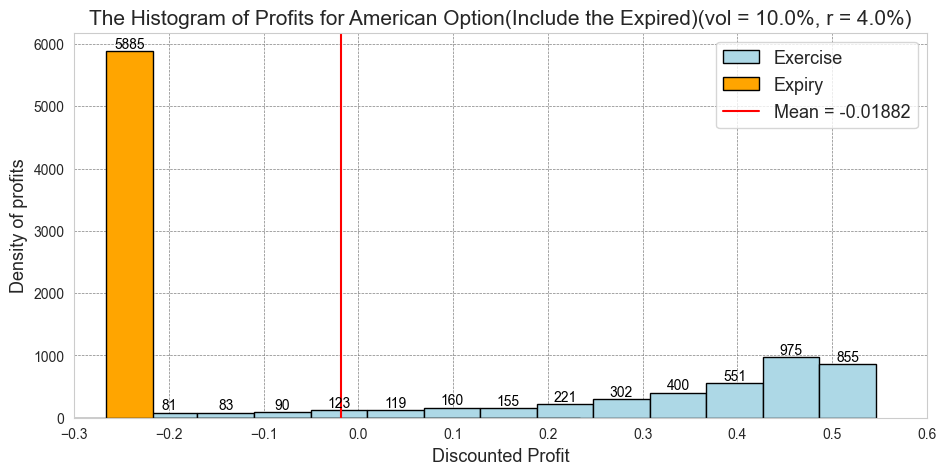

In [70]:
T = 1
S0 = 10
mu = 0.05
sigma = 0.1  # Modified
r = 0.04     # Modified
N = 5000
# N = 100
K = 10

#@title Update option functions for PnL dist all
np.random.seed(2)
sample_path_40vol = sample_path(S0, T, N, r, mu, sigma)
asset_tree, Q_option_tree = asset_n_option_tree_B_numeraire(T, S0, sigma, r, N, K)
grouped_timestamp, execution_boundary = execution_boundary_calculation(K, asset_tree, Q_option_tree)
exercise_df = execution_details(sample_path_40vol, grouped_timestamp, execution_boundary, Q_option_tree, K, r, N)
# time_plot(sigma, r)
# PnL_plot_condition(sigma, r)
# # PnL_plot(sigma, r)
try:
    plt.figure(figsize = (11,5))

    hist, bins, _ = plt.hist(exercise_df['profit'].values, bins=13, label = 'Exercise',
                            color = 'lightblue', edgecolor = 'black')
    for i in range(len(hist)):
        plt.text((bins[i] + bins[i+1]) / 2, hist[i], str(int(hist[i])),
                ha='center', va='bottom', color = 'black')

    hist1, bins1, _ = plt.hist([-Q_option_tree[0, 0]] * (10_000 - len(exercise_df)), bins=20,
                            label = 'Expiry', color = 'orange', edgecolor = 'black')

    bar_index = 10
    plt.text(bins1[bar_index] + (bins1[bar_index + 1] - bins1[bar_index]) / 2, hist1[bar_index], str(int(hist1[bar_index])),
            ha='center', va='bottom', color = 'black')

    # plt.hist([-Q_option_tree[0, 0]] * (10_000 - len(exercise_df)), label='expiry')
    all_path_pnl = np.hstack([exercise_df['profit'].values, [-Q_option_tree[0, 0]] * (10_000 - len(exercise_df))])
    plt.axvline(all_path_pnl.mean(), color='red',
                label=f"Mean = {all_path_pnl.mean():.5f}")
    plt.xlim(-0.3, 0.6)
    plt.grid(linewidth=0.5, linestyle='--', color='gray', zorder=1)
    plt.xlabel('Discounted Profit', fontsize = 13)
    plt.ylabel('Density of profits', fontsize = 13)
    plt.title(f"The Histogram of Profits for American Option(Include the Expired)(vol = {sigma * 100}%, r = {r * 100}%)", fontsize = 15)
    plt.legend(fontsize = 13)
    plt.show()
except KeyError as e:
    if e.args[0] == 'profit':
        print('No execution')
    else:
        print('other error')
        raise e

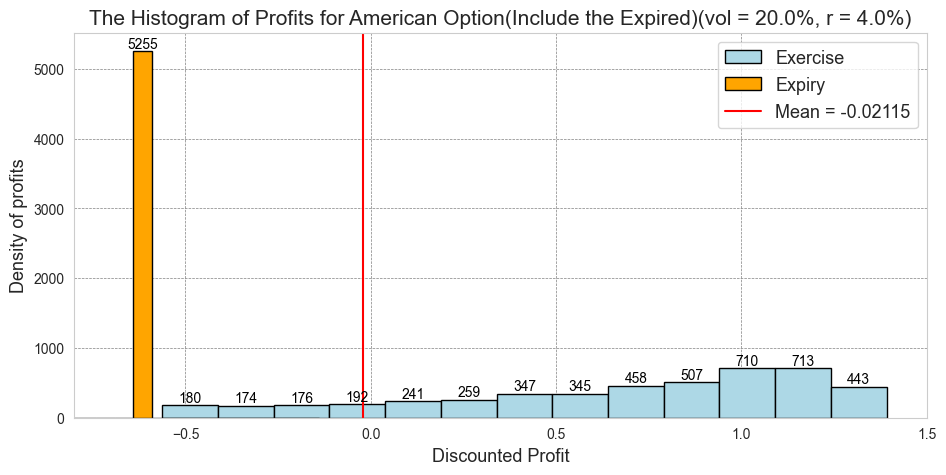

In [71]:
T = 1
S0 = 10
mu = 0.05
sigma = 0.2  # Modified
r = 0.04     # Modified
N = 5000
# N = 100
K = 10

#@title Update option functions for PnL dist all
np.random.seed(2)
sample_path_40vol = sample_path(S0, T, N, r, mu, sigma)
asset_tree, Q_option_tree = asset_n_option_tree_B_numeraire(T, S0, sigma, r, N, K)
grouped_timestamp, execution_boundary = execution_boundary_calculation(K, asset_tree, Q_option_tree)
exercise_df = execution_details(sample_path_40vol, grouped_timestamp, execution_boundary, Q_option_tree, K, r, N)
# time_plot(sigma, r)
# PnL_plot_condition(sigma, r)
# # PnL_plot(sigma, r)
try:
    plt.figure(figsize = (11,5))

    hist, bins, _ = plt.hist(exercise_df['profit'].values, bins=13, label = 'Exercise',
                            color = 'lightblue', edgecolor = 'black')
    for i in range(len(hist)):
        plt.text((bins[i] + bins[i+1]) / 2, hist[i], str(int(hist[i])),
                ha='center', va='bottom', color = 'black')

    hist1, bins1, _ = plt.hist([-Q_option_tree[0, 0]] * (10_000 - len(exercise_df)), bins=20,
                            label = 'Expiry', color = 'orange', edgecolor = 'black')

    bar_index = 10
    plt.text(bins1[bar_index] + (bins1[bar_index + 1] - bins1[bar_index]) / 2, hist1[bar_index], str(int(hist1[bar_index])),
            ha='center', va='bottom', color = 'black')

    # plt.hist([-Q_option_tree[0, 0]] * (10_000 - len(exercise_df)), label='expiry')
    all_path_pnl = np.hstack([exercise_df['profit'].values, [-Q_option_tree[0, 0]] * (10_000 - len(exercise_df))])
    plt.axvline(all_path_pnl.mean(), color='red',
                label=f"Mean = {all_path_pnl.mean():.5f}")
    plt.xlim(-0.8, 1.5)
    plt.grid(linewidth=0.5, linestyle='--', color='gray', zorder=1)
    plt.xlabel('Discounted Profit', fontsize = 13)
    plt.ylabel('Density of profits', fontsize = 13)
    plt.title(f"The Histogram of Profits for American Option(Include the Expired)(vol = {sigma * 100}%, r = {r * 100}%)", fontsize = 15)
    plt.legend(fontsize = 13)
    plt.show()
except KeyError as e:
    if e.args[0] == 'profit':
        print('No execution')
    else:
        print('other error')
        raise e

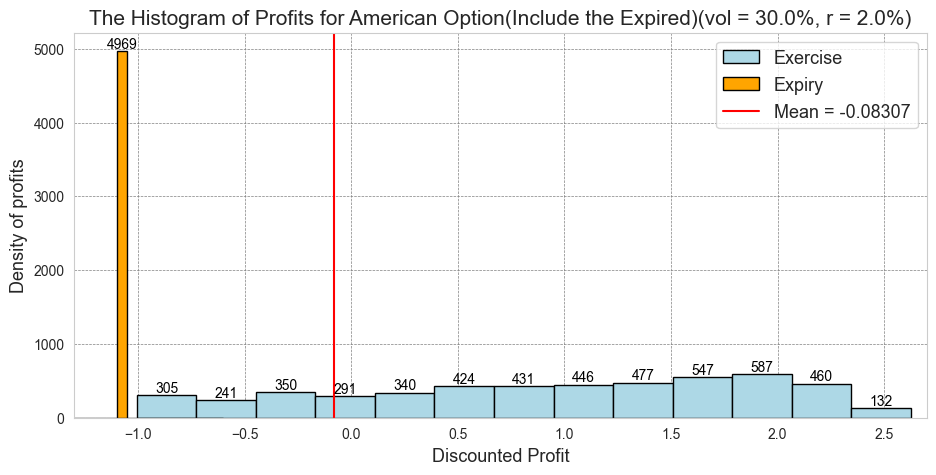

In [72]:
T = 1
S0 = 10
mu = 0.05
sigma = 0.3  # Modified
r = 0.02     # Modified
N = 5000
# N = 100
K = 10

#@title Update option functions for PnL dist all
np.random.seed(2)
sample_path_40vol = sample_path(S0, T, N, r, mu, sigma)
asset_tree, Q_option_tree = asset_n_option_tree_B_numeraire(T, S0, sigma, r, N, K)
grouped_timestamp, execution_boundary = execution_boundary_calculation(K, asset_tree, Q_option_tree)
exercise_df = execution_details(sample_path_40vol, grouped_timestamp, execution_boundary, Q_option_tree, K, r, N)
# time_plot(sigma, r)
# PnL_plot_condition(sigma, r)
# # PnL_plot(sigma, r)
try:
    plt.figure(figsize = (11,5))

    hist, bins, _ = plt.hist(exercise_df['profit'].values, bins=13, label = 'Exercise',
                            color = 'lightblue', edgecolor = 'black')
    for i in range(len(hist)):
        plt.text((bins[i] + bins[i+1]) / 2, hist[i], str(int(hist[i])),
                ha='center', va='bottom', color = 'black')

    hist1, bins1, _ = plt.hist([-Q_option_tree[0, 0]] * (10_000 - len(exercise_df)), bins=20,
                            label = 'Expiry', color = 'orange', edgecolor = 'black')

    bar_index = 10
    plt.text(bins1[bar_index] + (bins1[bar_index + 1] - bins1[bar_index]) / 2, hist1[bar_index], str(int(hist1[bar_index])),
            ha='center', va='bottom', color = 'black')

    # plt.hist([-Q_option_tree[0, 0]] * (10_000 - len(exercise_df)), label='expiry')
    all_path_pnl = np.hstack([exercise_df['profit'].values, [-Q_option_tree[0, 0]] * (10_000 - len(exercise_df))])
    plt.axvline(all_path_pnl.mean(), color='red',
                label=f"Mean = {all_path_pnl.mean():.5f}")
    plt.xlim(-1.3, 2.7)
    plt.grid(linewidth=0.5, linestyle='--', color='gray', zorder=1)
    plt.xlabel('Discounted Profit', fontsize = 13)
    plt.ylabel('Density of profits', fontsize = 13)
    plt.title(f"The Histogram of Profits for American Option(Include the Expired)(vol = {sigma * 100}%, r = {r * 100}%)", fontsize = 15)
    plt.legend(fontsize = 13)
    plt.show()
except KeyError as e:
    if e.args[0] == 'profit':
        print('No execution')
    else:
        print('other error')
        raise e

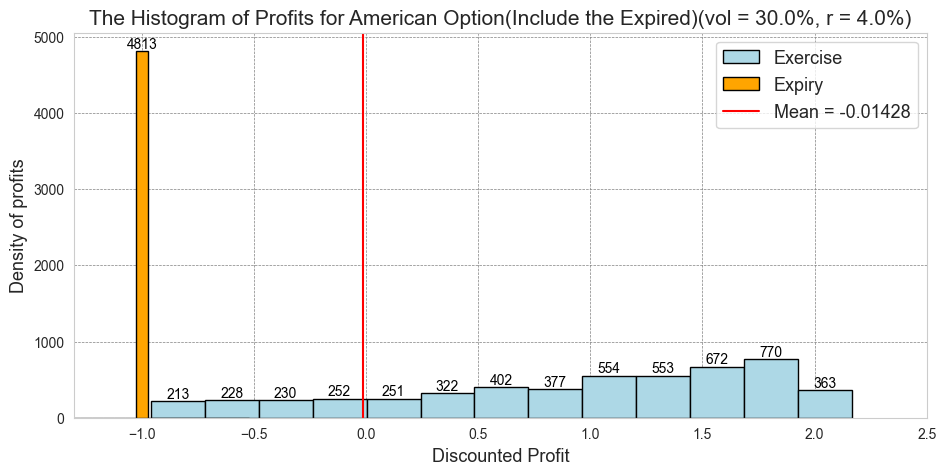

In [73]:
T = 1
S0 = 10
mu = 0.05
sigma = 0.3  # Modified
r = 0.04     # Modified
N = 5000
# N = 100
K = 10

#@title Update option functions for PnL dist all
np.random.seed(2)
sample_path_40vol = sample_path(S0, T, N, r, mu, sigma)
asset_tree, Q_option_tree = asset_n_option_tree_B_numeraire(T, S0, sigma, r, N, K)
grouped_timestamp, execution_boundary = execution_boundary_calculation(K, asset_tree, Q_option_tree)
exercise_df = execution_details(sample_path_40vol, grouped_timestamp, execution_boundary, Q_option_tree, K, r, N)
# time_plot(sigma, r)
# PnL_plot_condition(sigma, r)
# # PnL_plot(sigma, r)
try:
    plt.figure(figsize = (11,5))

    hist, bins, _ = plt.hist(exercise_df['profit'].values, bins=13, label = 'Exercise',
                            color = 'lightblue', edgecolor = 'black')
    for i in range(len(hist)):
        plt.text((bins[i] + bins[i+1]) / 2, hist[i], str(int(hist[i])),
                ha='center', va='bottom', color = 'black')

    hist1, bins1, _ = plt.hist([-Q_option_tree[0, 0]] * (10_000 - len(exercise_df)), bins=20,
                            label = 'Expiry', color = 'orange', edgecolor = 'black')

    bar_index = 10
    plt.text(bins1[bar_index] + (bins1[bar_index + 1] - bins1[bar_index]) / 2, hist1[bar_index], str(int(hist1[bar_index])),
            ha='center', va='bottom', color = 'black')

    # plt.hist([-Q_option_tree[0, 0]] * (10_000 - len(exercise_df)), label='expiry')
    all_path_pnl = np.hstack([exercise_df['profit'].values, [-Q_option_tree[0, 0]] * (10_000 - len(exercise_df))])
    plt.axvline(all_path_pnl.mean(), color='red',
                label=f"Mean = {all_path_pnl.mean():.5f}")
    plt.xlim(-1.3, 2.5)
    plt.grid(linewidth=0.5, linestyle='--', color='gray', zorder=1)
    plt.xlabel('Discounted Profit', fontsize = 13)
    plt.ylabel('Density of profits', fontsize = 13)
    plt.title(f"The Histogram of Profits for American Option(Include the Expired)(vol = {sigma * 100}%, r = {r * 100}%)", fontsize = 15)
    plt.legend(fontsize = 13)
    plt.show()
except KeyError as e:
    if e.args[0] == 'profit':
        print('No execution')
    else:
        print('other error')
        raise e

# 2.b.3. If purchased the option with vol 20%, you execute with 20% volatility execution boundary, but the realized volatility is 30%, what is the P&L distribution?
this means the option tree is the same, exercise boundary is the same, but the path is different.
option value positively correlate with volatility, so if we buy the option with 20% vol, we are paying a lower price than the option with 30% vol.

In [75]:
def market_mis_pricing_execution_expected_profit(option_implied_vol, realized_vol, S0, T, N, r, mu, K):
    # this may take a while
    assert option_implied_vol != realized_vol
    sample_path_realized_vol = sample_path(S0, T, N, r, mu, realized_vol)
    sample_path_option_implied_vol = sample_path(S0, T, N, r, mu, option_implied_vol)

    correct_asset_tree, correct_Q_option_tree = asset_n_option_tree_B_numeraire(T, S0, option_implied_vol, r, N, K)
    mis_pricing_asset_tree, mis_pricing_Q_option_tree = asset_n_option_tree_B_numeraire(T, S0, realized_vol, r, N, K)

    correct_time_stamp, correct_price_exercise_boundary = execution_boundary_calculation(K, correct_asset_tree,
                                                                                         correct_Q_option_tree)
    mis_pricing_time_stamp, mis_pricing_price_exercise_boundary = execution_boundary_calculation(K,
                                                                                                 mis_pricing_asset_tree,
                                                                                                 mis_pricing_Q_option_tree)

    fair_vol_execution = execution_details(sample_path_option_implied_vol, correct_time_stamp,
                                           correct_price_exercise_boundary, correct_Q_option_tree, K, r, N)
    passive_vol_execution = execution_details(sample_path_realized_vol, correct_time_stamp,
                                              correct_price_exercise_boundary, correct_Q_option_tree, K, r, N)
    active_vol_execution = execution_details(sample_path_realized_vol, mis_pricing_time_stamp,
                                             mis_pricing_price_exercise_boundary, correct_Q_option_tree, K, r, N)

    return fair_vol_execution, passive_vol_execution, active_vol_execution

In [76]:
def expected_pnl_include_no_execution(profit):
    # this is the expected pnl if we include the no execution case
    return profit.mean() * (len(profit) / 10_000) + (-Q_option_tree[0, 0]) * (
            1 - len(profit) / 10_000)  # use Q_option_tree[0,0] as the option price at vol 20


In [77]:
#@title Update functions
# Setting for 20% Vol, 30% realized vol
T = 1
S0 = 10
mu = 0.05
sigma = 0.2   # Option implied volatility
r = 0.02
N = 5000
# N = 100
K = 10
sigma_realized = 0.3  # realized volatility

# update functions
fair_vol_execution, passive_vol_execution, active_vol_execution = market_mis_pricing_execution_expected_profit(sigma, sigma_realized, S0, T, N, r, mu, K)

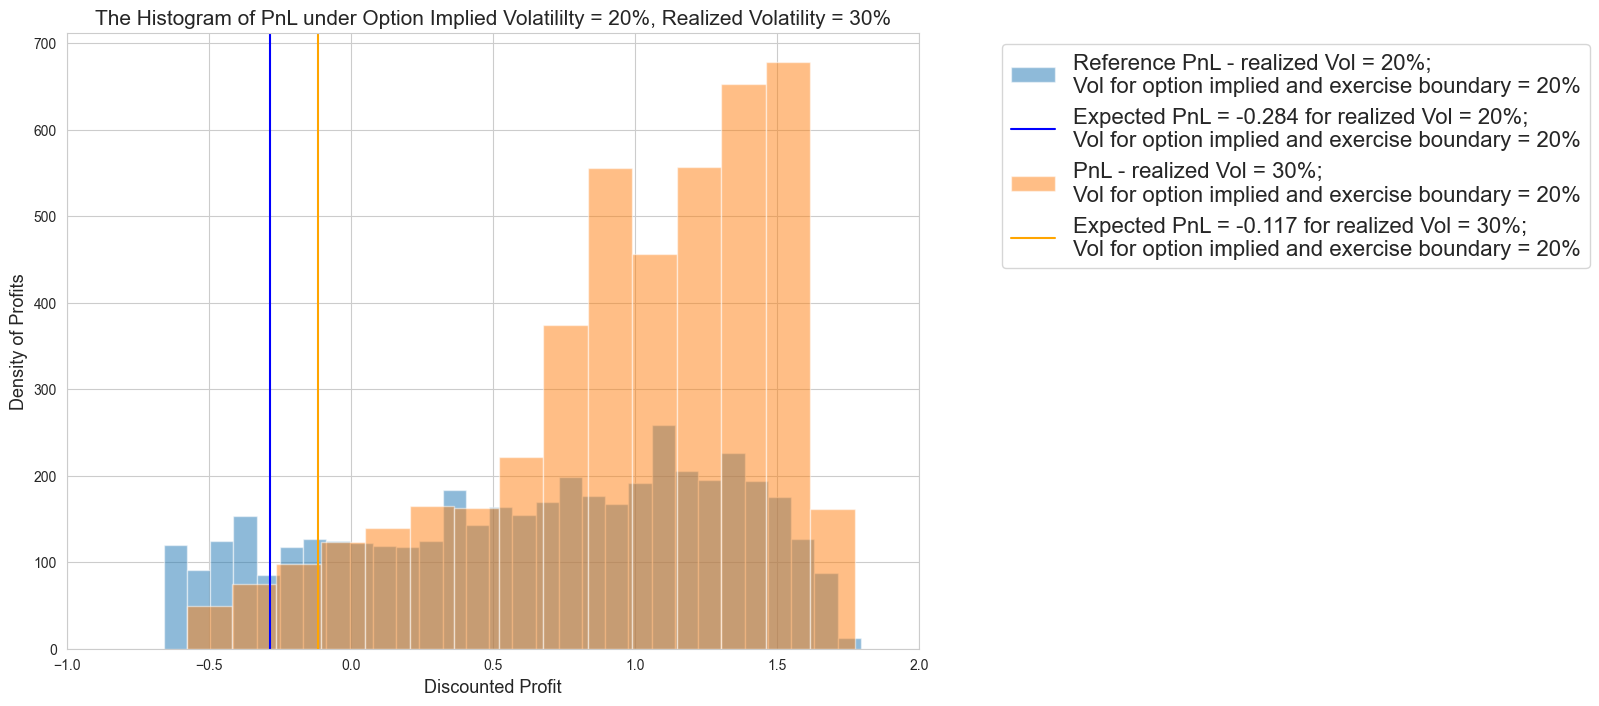

In [78]:
plt.figure(figsize = (11, 8))

fair_vol_execution['profit'].hist(label='Reference PnL - realized Vol = 20%; \nVol for option implied and exercise boundary = 20%',
                                  bins = 30,alpha =0.5)
plt.axvline(expected_pnl_include_no_execution(fair_vol_execution['profit']), color='blue',
            label=f"Expected PnL = {expected_pnl_include_no_execution(fair_vol_execution['profit']):.3f} for realized Vol = 20%; \nVol for option implied and exercise boundary = 20%")

passive_vol_execution['profit'].hist(label='PnL - realized Vol = 30%; \nVol for option implied and exercise boundary = 20%',
                                    bins = 15, alpha = 0.5)
plt.axvline(expected_pnl_include_no_execution(passive_vol_execution['profit']), color='orange',
            label=f"Expected PnL = {expected_pnl_include_no_execution(passive_vol_execution['profit']):.3f} for realized Vol = 30%; \nVol for option implied and exercise boundary = 20%")

plt.xlim(-1, 2.0)
plt.legend(loc = 'upper right', bbox_to_anchor=(1.8, 1), fontsize = 16)
plt.title('The Histogram of PnL under Option Implied Volatililty = 20%, Realized Volatility = 30%', fontsize = 15)
plt.xlabel('Discounted Profit', fontsize = 13)
plt.ylabel('Density of Profits', fontsize = 13)
plt.show()

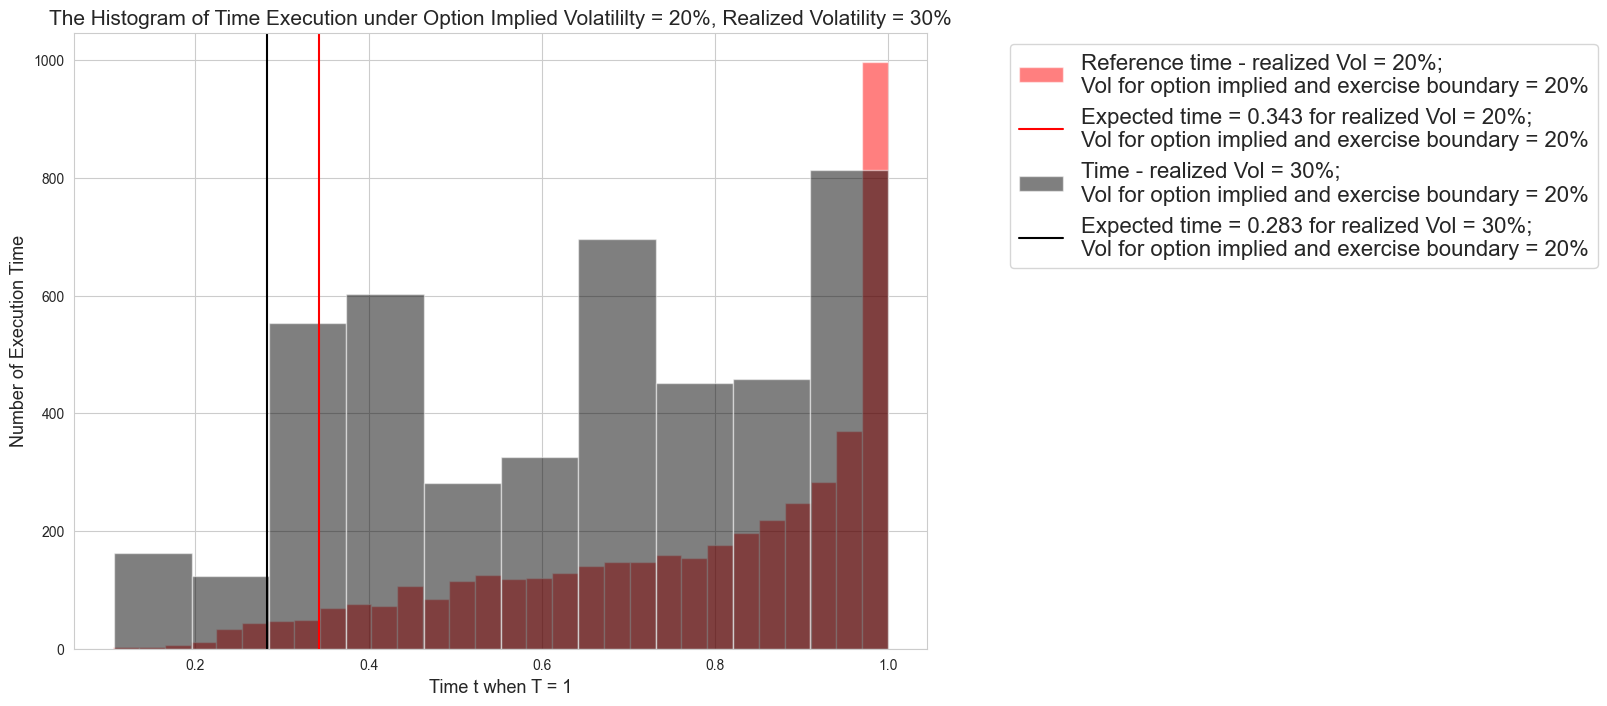

In [79]:
plt.figure(figsize = (11, 8))

(fair_vol_execution['execution_time']/5000).hist(label='Reference time - realized Vol = 20%; \nVol for option implied and exercise boundary = 20%',
                                  color = 'red', bins = 30,alpha =0.5)
plt.axvline(expected_pnl_include_no_execution(fair_vol_execution['execution_time']).mean()/5000, color='red',
            label=f"Expected time = {expected_pnl_include_no_execution(fair_vol_execution['execution_time'])/5000:.3f} for realized Vol = 20%; \nVol for option implied and exercise boundary = 20%")

(passive_vol_execution['execution_time']/5000).hist(label='Time - realized Vol = 30%; \nVol for option implied and exercise boundary = 20%',
                                    color = 'black', bins = 10, alpha = 0.5)
plt.axvline(expected_pnl_include_no_execution(passive_vol_execution['execution_time'])/5000, color='black',
            label=f"Expected time = {expected_pnl_include_no_execution(passive_vol_execution['execution_time'])/5000:.3f} for realized Vol = 30%; \nVol for option implied and exercise boundary = 20%")

# plt.xlim(-1, 2.0)
plt.legend(loc = 'upper right', bbox_to_anchor=(1.8, 1), fontsize = 16)
plt.title('The Histogram of Time Execution under Option Implied Volatililty = 20%, Realized Volatility = 30%', fontsize = 15)
plt.xlabel('Time t when T = 1', fontsize = 13)
plt.ylabel('Number of Execution Time', fontsize = 13)
plt.show()

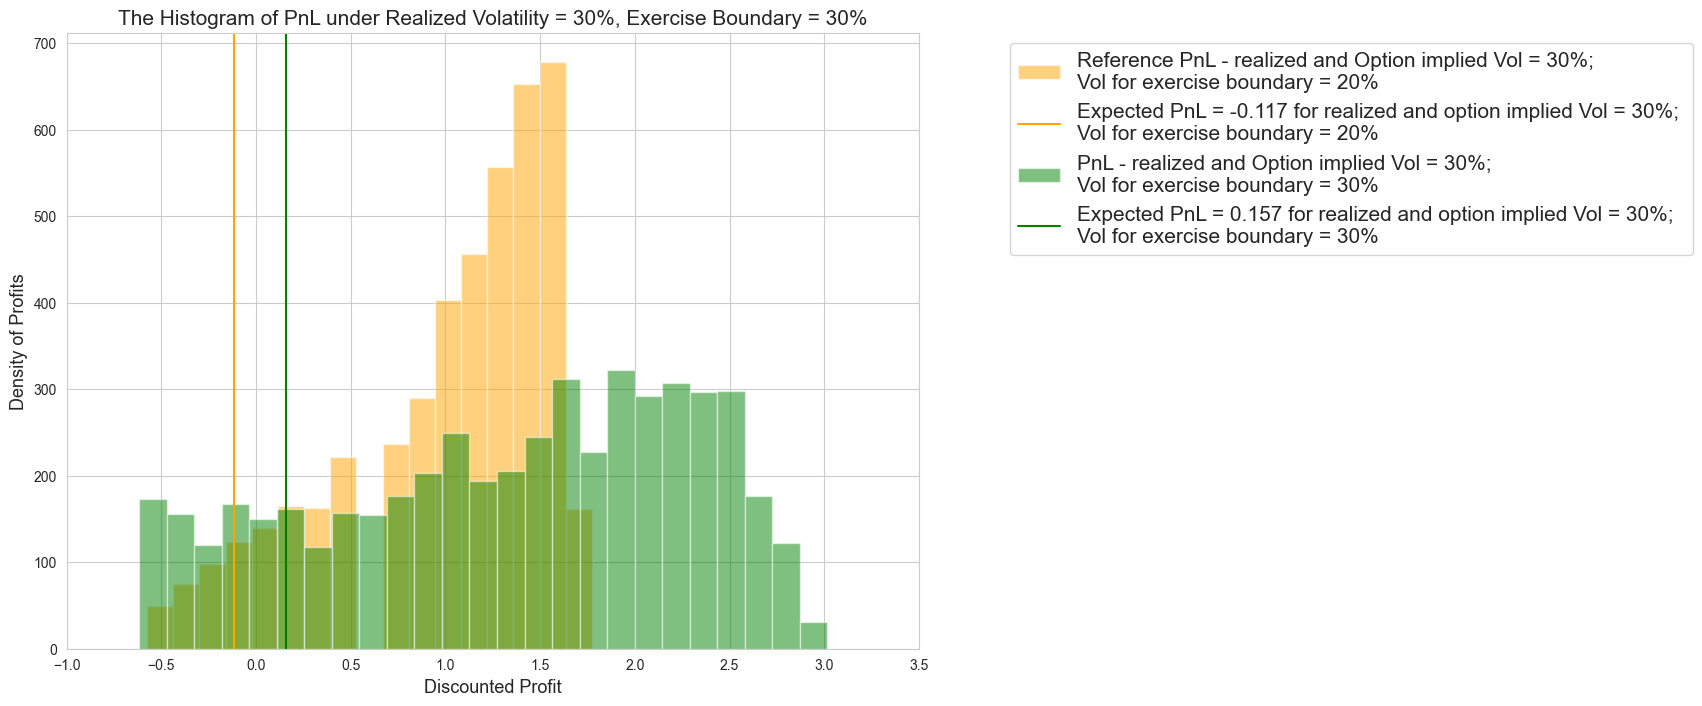

In [80]:
plt.figure(figsize = (11, 8))

passive_vol_execution['profit'].hist(label='Reference PnL - realized and Option implied Vol = 30%; \nVol for exercise boundary = 20%',
                                    color = 'orange', bins = 17, alpha = 0.5)

plt.axvline(expected_pnl_include_no_execution(passive_vol_execution['profit']), color='orange',
            label=f"Expected PnL = {expected_pnl_include_no_execution(passive_vol_execution['profit']):.3f} for realized and option implied Vol = 30%; \nVol for exercise boundary = 20%")

active_vol_execution['profit'].hist(label='PnL - realized and Option implied Vol = 30%; \nVol for exercise boundary = 30%',
                                    color = 'green', bins = 25,alpha = 0.5)
plt.axvline(expected_pnl_include_no_execution(active_vol_execution['profit']), color='green',
            label=f"Expected PnL = {expected_pnl_include_no_execution(active_vol_execution['profit']):.3f} for realized and option implied Vol = 30%; \nVol for exercise boundary = 30%")

plt.xlim(-1,3.5)
plt.legend(loc = 'upper right', bbox_to_anchor=(1.92, 1), fontsize = 15)
plt.title('The Histogram of PnL under Realized Volatility = 30%, Exercise Boundary = 30%', fontsize = 15)
plt.xlabel('Discounted Profit', fontsize = 13)
plt.ylabel('Density of Profits', fontsize = 13)
plt.show()

In [81]:
#@title Update functions
sigma_realized = 0.25  # realized volatility
sigma = 0.2   # Option implied volatility
fair_vol_execution, passive_vol_execution, active_vol_execution = market_mis_pricing_execution_expected_profit(sigma, sigma_realized, S0, T, N, r, mu, K)

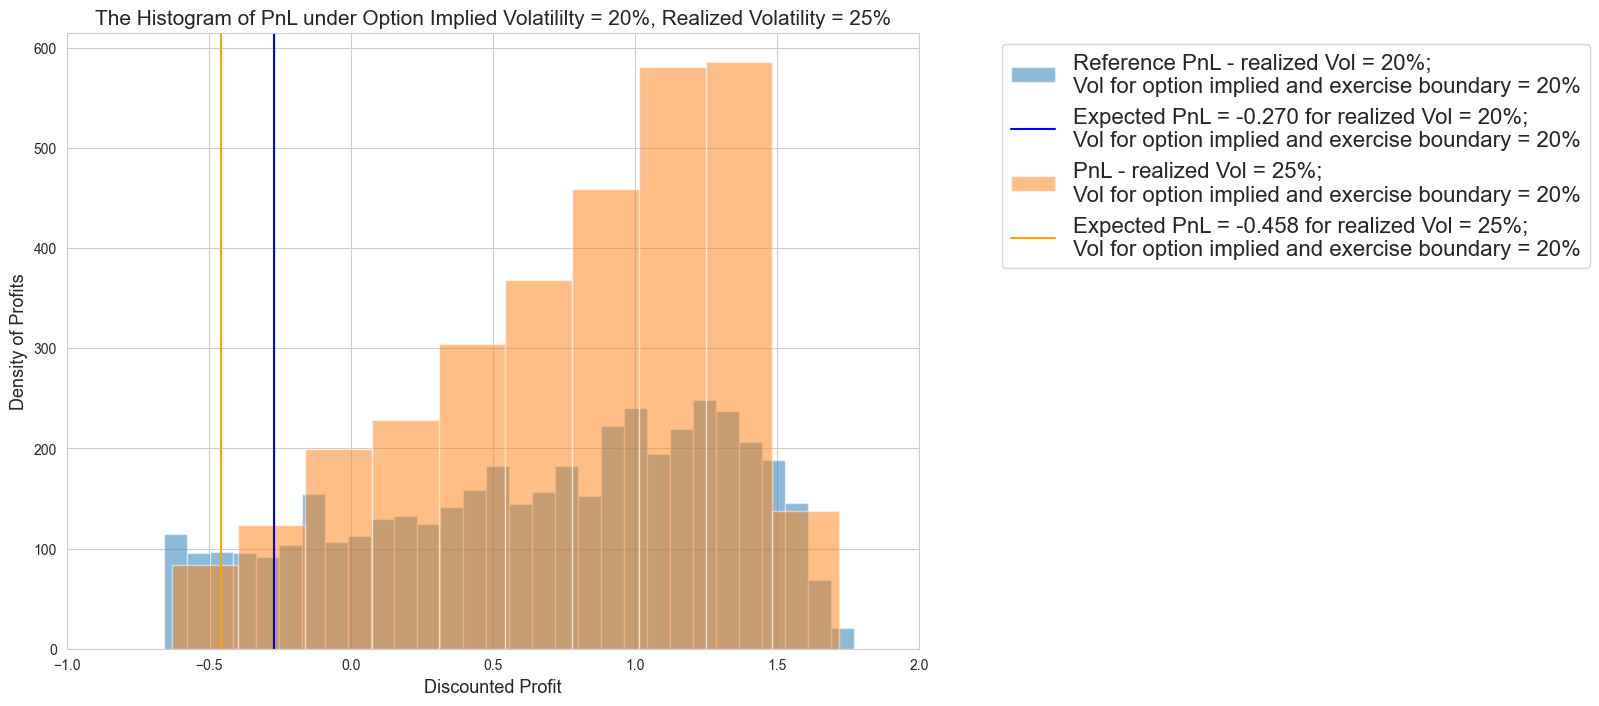

In [82]:
plt.figure(figsize = (11, 8))

fair_vol_execution['profit'].hist(label='Reference PnL - realized Vol = 20%; \nVol for option implied and exercise boundary = 20%',
                                  bins = 30,alpha = 0.5)
plt.axvline(expected_pnl_include_no_execution(fair_vol_execution['profit']), color='blue',
            label=f"Expected PnL = {expected_pnl_include_no_execution(fair_vol_execution['profit']):.3f} for realized Vol = 20%; \nVol for option implied and exercise boundary = 20%")

passive_vol_execution['profit'].hist(label='PnL - realized Vol = 25%; \nVol for option implied and exercise boundary = 20%',
                                     bins = 10, alpha = 0.5)
plt.axvline(expected_pnl_include_no_execution(passive_vol_execution['profit']), color='orange',
            label=f"Expected PnL = {expected_pnl_include_no_execution(passive_vol_execution['profit']):.3f} for realized Vol = 25%; \nVol for option implied and exercise boundary = 20%")

plt.xlim(-1, 2.0)
plt.legend(loc = 'upper right', bbox_to_anchor=(1.8, 1), fontsize = 16)
plt.title('The Histogram of PnL under Option Implied Volatililty = 20%, Realized Volatility = 25%', fontsize = 15)
plt.xlabel('Discounted Profit', fontsize = 13)
plt.ylabel('Density of Profits', fontsize = 13)
plt.show()

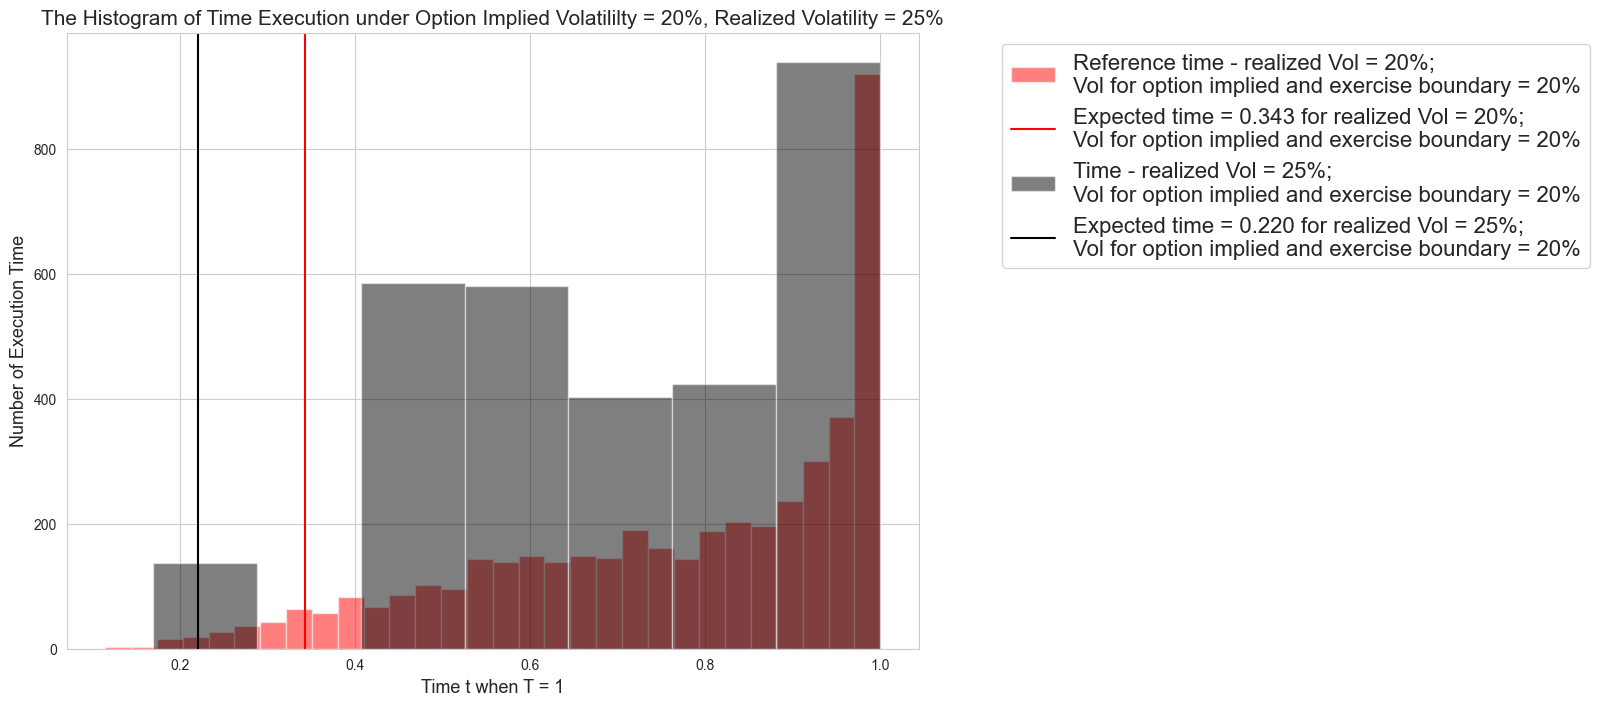

In [83]:
plt.figure(figsize = (11, 8))

(fair_vol_execution['execution_time']/5000).hist(label='Reference time - realized Vol = 20%; \nVol for option implied and exercise boundary = 20%',
                                  color = 'red', bins = 30,alpha =0.5)
plt.axvline(expected_pnl_include_no_execution(fair_vol_execution['execution_time'])/5000, color='red',
            label=f"Expected time = {expected_pnl_include_no_execution(fair_vol_execution['execution_time'])/5000:.3f} for realized Vol = 20%; \nVol for option implied and exercise boundary = 20%")

(passive_vol_execution['execution_time']/5000).hist(label='Time - realized Vol = 25%; \nVol for option implied and exercise boundary = 20%',
                                    color = 'black', bins = 7, alpha = 0.5)
plt.axvline(expected_pnl_include_no_execution(passive_vol_execution['execution_time'])/5000, color='black',
            label=f"Expected time = {expected_pnl_include_no_execution(passive_vol_execution['execution_time'])/5000:.3f} for realized Vol = 25%; \nVol for option implied and exercise boundary = 20%")

# plt.xlim(-1, 2.0)
plt.legend(loc = 'upper right', bbox_to_anchor=(1.8, 1), fontsize = 16)
plt.title('The Histogram of Time Execution under Option Implied Volatililty = 20%, Realized Volatility = 25%', fontsize = 15)
plt.xlabel('Time t when T = 1', fontsize = 13)
plt.ylabel('Number of Execution Time', fontsize = 13)
plt.show()

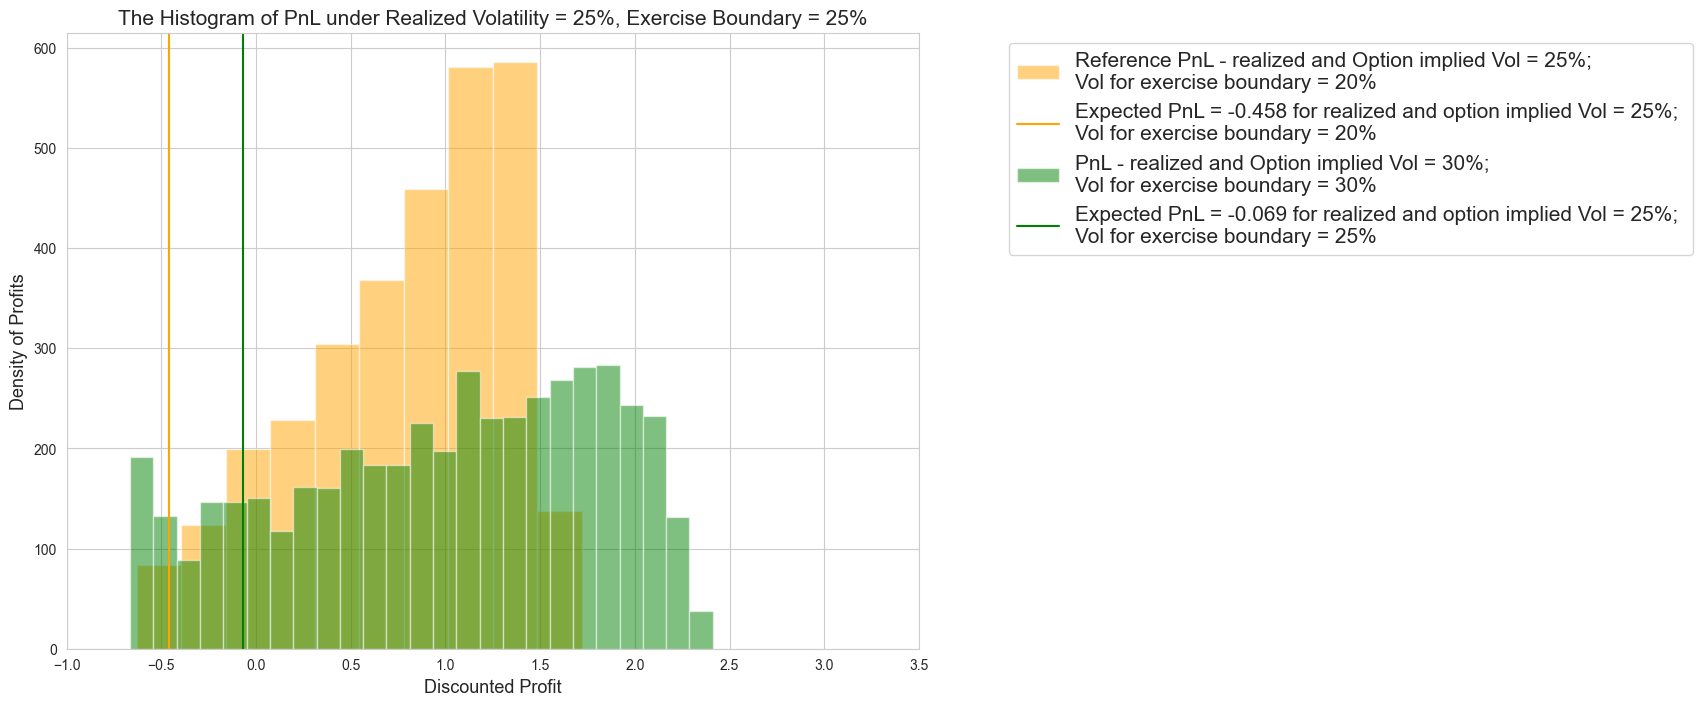

In [84]:
plt.figure(figsize = (11, 8))

passive_vol_execution['profit'].hist(label='Reference PnL - realized and Option implied Vol = 25%; \nVol for exercise boundary = 20%',
                                    color = 'orange', bins = 10, alpha = 0.5)

plt.axvline(expected_pnl_include_no_execution(passive_vol_execution['profit']), color='orange',
            label=f"Expected PnL = {expected_pnl_include_no_execution(passive_vol_execution['profit']):.3f} for realized and option implied Vol = 25%; \nVol for exercise boundary = 20%")

active_vol_execution['profit'].hist(label='PnL - realized and Option implied Vol = 30%; \nVol for exercise boundary = 30%',
                                    color = 'green', bins = 25,alpha = 0.5)
plt.axvline(expected_pnl_include_no_execution(active_vol_execution['profit']), color='green',
            label=f"Expected PnL = {expected_pnl_include_no_execution(active_vol_execution['profit']):.3f} for realized and option implied Vol = 25%; \nVol for exercise boundary = 25%")

plt.xlim(-1,3.5)
plt.legend(loc = 'upper right', bbox_to_anchor=(1.92, 1), fontsize = 15)
plt.title('The Histogram of PnL under Realized Volatility = 25%, Exercise Boundary = 25%', fontsize = 15)
plt.xlabel('Discounted Profit', fontsize = 13)
plt.ylabel('Density of Profits', fontsize = 13)
plt.show()

In [85]:
#@title Update functions
sigma_realized = 0.15  # realized volatility
sigma = 0.2   # Option implied volatility
fair_vol_execution, passive_vol_execution, active_vol_execution = market_mis_pricing_execution_expected_profit(sigma, sigma_realized, S0, T, N, r, mu, K)

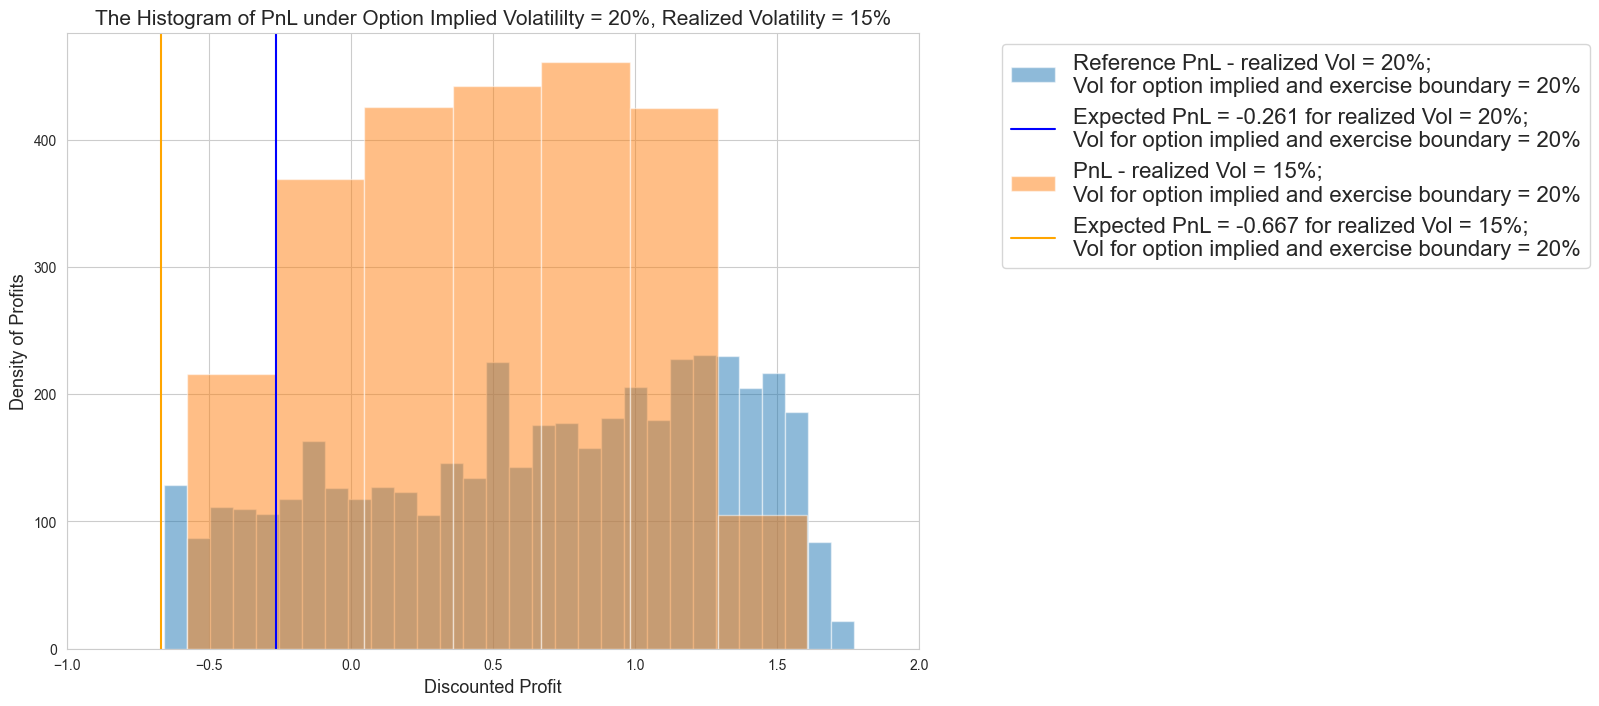

In [86]:
plt.figure(figsize = (11, 8))

fair_vol_execution['profit'].hist(label='Reference PnL - realized Vol = 20%; \nVol for option implied and exercise boundary = 20%',
                                  bins = 30, alpha = 0.5)
plt.axvline(expected_pnl_include_no_execution(fair_vol_execution['profit']),
            color='blue', label=f"Expected PnL = {expected_pnl_include_no_execution(fair_vol_execution['profit']):.3f} for realized Vol = 20%; \nVol for option implied and exercise boundary = 20%")

passive_vol_execution['profit'].hist(label='PnL - realized Vol = 15%; \nVol for option implied and exercise boundary = 20%',
                                     bins = 7, alpha = 0.5)
plt.axvline(expected_pnl_include_no_execution(passive_vol_execution['profit']),
            color='orange', label=f"Expected PnL = {expected_pnl_include_no_execution(passive_vol_execution['profit']):.3f} for realized Vol = 15%; \nVol for option implied and exercise boundary = 20%"
)

plt.xlim(-1, 2)
plt.legend(loc = 'upper right', bbox_to_anchor=(1.8, 1), fontsize = 16)
plt.title('The Histogram of PnL under Option Implied Volatililty = 20%, Realized Volatility = 15%', fontsize = 15)
plt.xlabel('Discounted Profit', fontsize = 13)
plt.ylabel('Density of Profits', fontsize = 13)
plt.show()

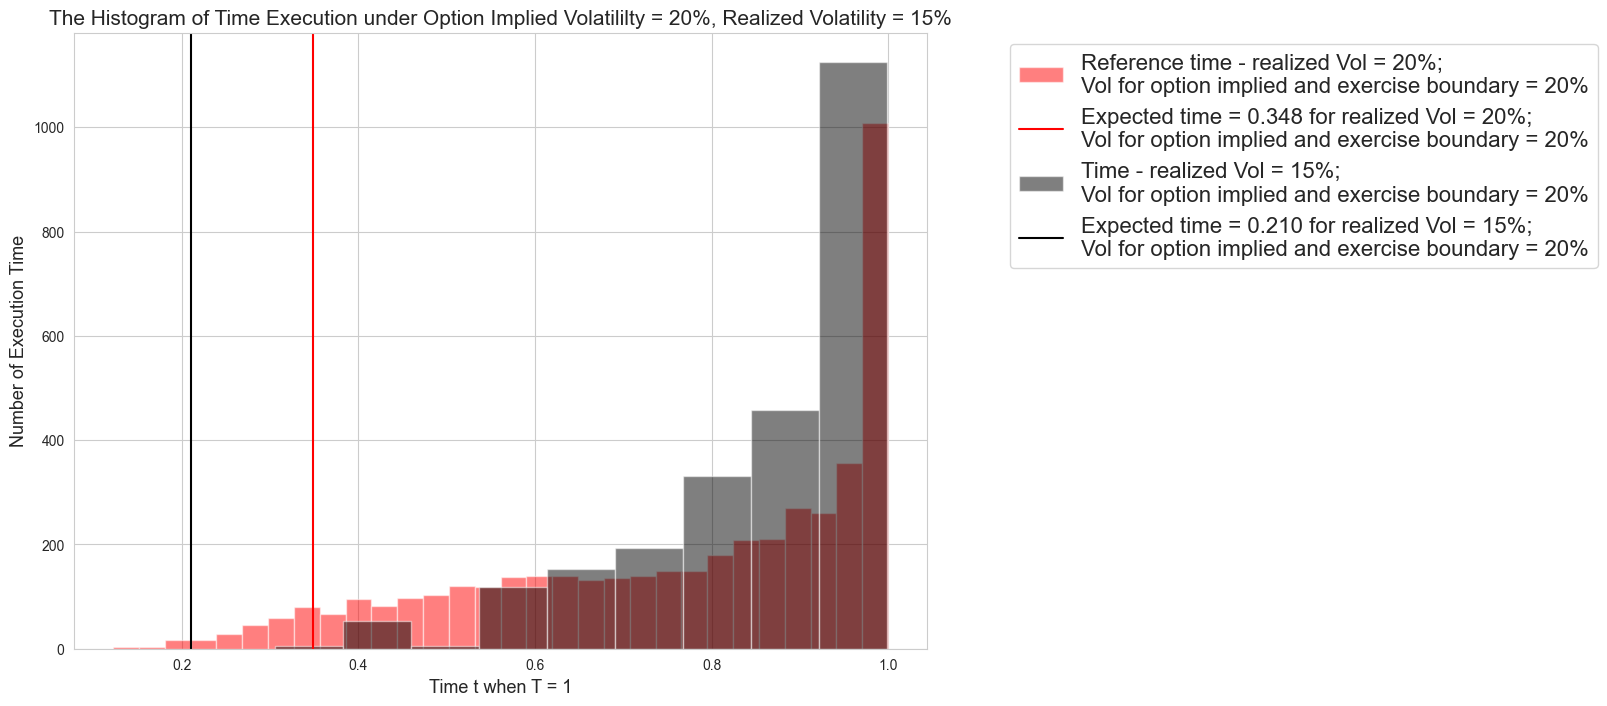

In [87]:
plt.figure(figsize = (11, 8))

(fair_vol_execution['execution_time']/5000).hist(label='Reference time - realized Vol = 20%; \nVol for option implied and exercise boundary = 20%',
                                  color = 'red',bins = 30,alpha =0.5)
plt.axvline(expected_pnl_include_no_execution(fair_vol_execution['execution_time'])/5000, color='red',
            label=f"Expected time = {expected_pnl_include_no_execution(fair_vol_execution['execution_time'])/5000:.3f} for realized Vol = 20%; \nVol for option implied and exercise boundary = 20%")

(passive_vol_execution['execution_time']/5000).hist(label='Time - realized Vol = 15%; \nVol for option implied and exercise boundary = 20%',
                                   color = 'black', bins = 9, alpha = 0.5)
plt.axvline(expected_pnl_include_no_execution(passive_vol_execution['execution_time'])/5000, color='black',
            label=f"Expected time = {expected_pnl_include_no_execution(passive_vol_execution['execution_time'])/5000:.3f} for realized Vol = 15%; \nVol for option implied and exercise boundary = 20%")

# plt.xlim(-1, 2.0)
plt.legend(loc = 'upper right', bbox_to_anchor=(1.8, 1), fontsize = 16)
plt.title('The Histogram of Time Execution under Option Implied Volatililty = 20%, Realized Volatility = 15%', fontsize = 15)
plt.xlabel('Time t when T = 1', fontsize = 13)
plt.ylabel('Number of Execution Time', fontsize = 13)
plt.show()

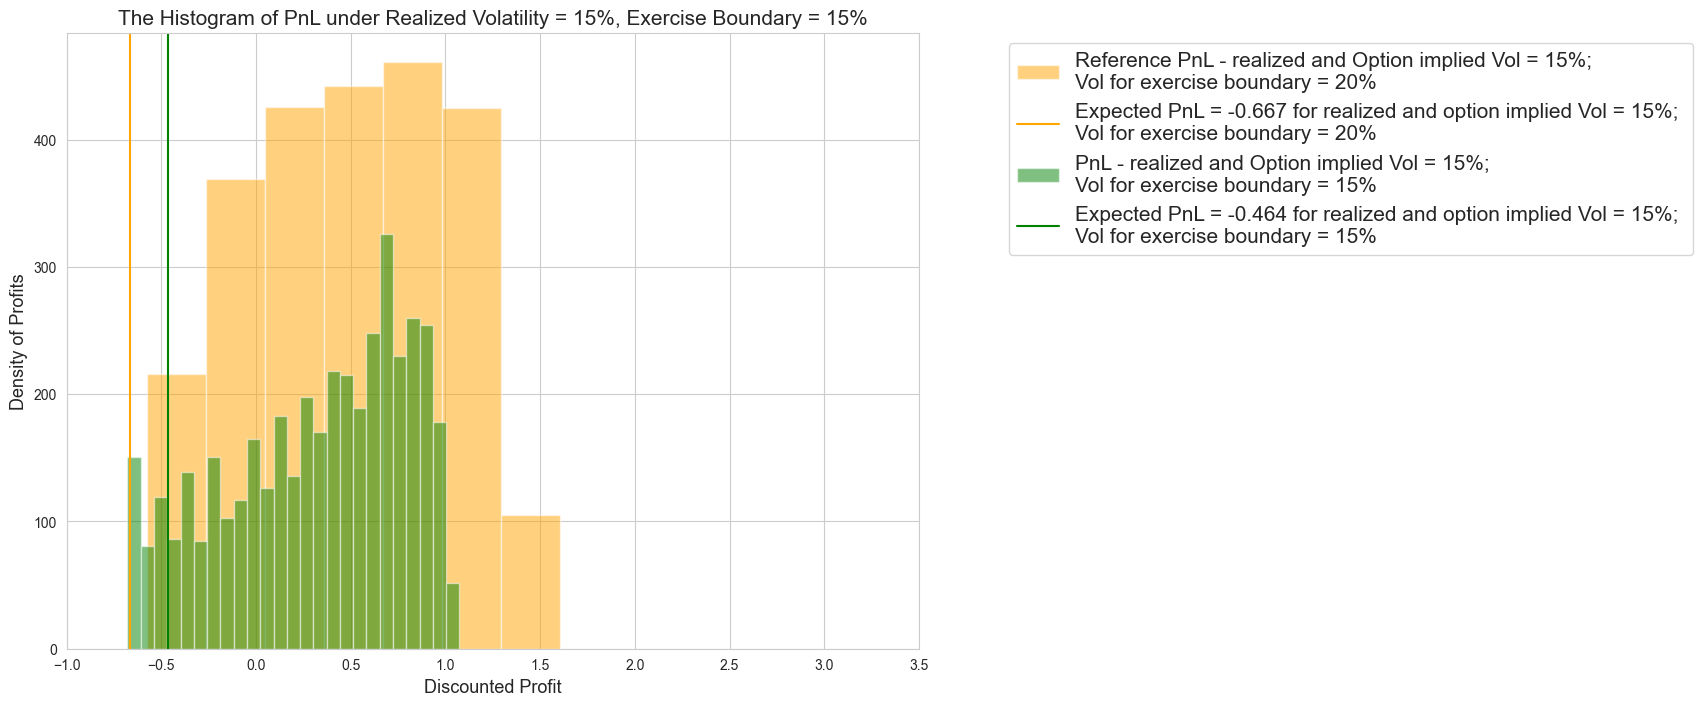

In [88]:
plt.figure(figsize = (11, 8))

passive_vol_execution['profit'].hist(label='Reference PnL - realized and Option implied Vol = 15%; \nVol for exercise boundary = 20%',
                                    color = 'orange', bins = 7, alpha = 0.5)

plt.axvline(expected_pnl_include_no_execution(passive_vol_execution['profit']), color='orange',
            label=f"Expected PnL = {expected_pnl_include_no_execution(passive_vol_execution['profit']):.3f} for realized and option implied Vol = 15%; \nVol for exercise boundary = 20%")

active_vol_execution['profit'].hist(label='PnL - realized and Option implied Vol = 15%; \nVol for exercise boundary = 15%',
                                    color = 'green', bins = 25,alpha = 0.5)
plt.axvline(expected_pnl_include_no_execution(active_vol_execution['profit']), color='green',
            label=f"Expected PnL = {expected_pnl_include_no_execution(active_vol_execution['profit']):.3f} for realized and option implied Vol = 15%; \nVol for exercise boundary = 15%")

plt.xlim(-1,3.5)
plt.legend(loc = 'upper right', bbox_to_anchor=(1.92, 1), fontsize = 15)
plt.title('The Histogram of PnL under Realized Volatility = 15%, Exercise Boundary = 15%', fontsize = 15)
plt.xlabel('Discounted Profit', fontsize = 13)
plt.ylabel('Density of Profits', fontsize = 13)
plt.show()

In [89]:
#@title Update functions
sigma_realized = 0.1  # realized volatility
sigma = 0.2   # Option implied volatility
fair_vol_execution, passive_vol_execution, active_vol_execution = market_mis_pricing_execution_expected_profit(sigma, sigma_realized, S0, T, N, r, mu, K)

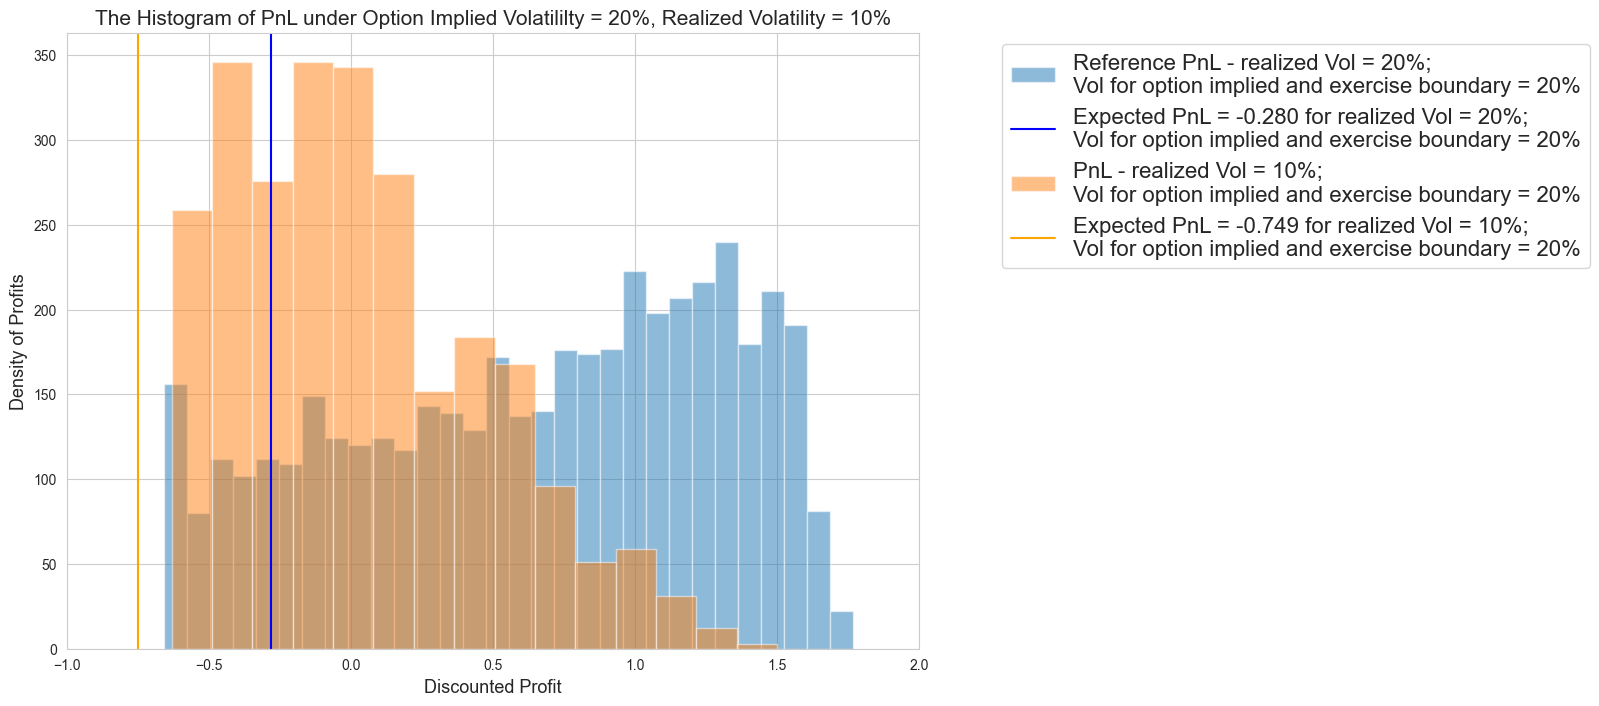

In [90]:
plt.figure(figsize = (11, 8))

fair_vol_execution['profit'].hist(label='Reference PnL - realized Vol = 20%; \nVol for option implied and exercise boundary = 20%',
                                  bins = 30, alpha = 0.5)
plt.axvline(expected_pnl_include_no_execution(fair_vol_execution['profit']),
            color='blue', label=f"Expected PnL = {expected_pnl_include_no_execution(fair_vol_execution['profit']):.3f} for realized Vol = 20%; \nVol for option implied and exercise boundary = 20%")

passive_vol_execution['profit'].hist(label='PnL - realized Vol = 10%; \nVol for option implied and exercise boundary = 20%',
                                     bins = 15, alpha = 0.5)
plt.axvline(expected_pnl_include_no_execution(passive_vol_execution['profit']),
            color='orange', label=f"Expected PnL = {expected_pnl_include_no_execution(passive_vol_execution['profit']):.3f} for realized Vol = 10%; \nVol for option implied and exercise boundary = 20%"
)

plt.xlim(-1, 2)
plt.legend(loc = 'upper right', bbox_to_anchor=(1.8, 1), fontsize = 16)
plt.title('The Histogram of PnL under Option Implied Volatililty = 20%, Realized Volatility = 10%', fontsize = 15)
plt.xlabel('Discounted Profit', fontsize = 13)
plt.ylabel('Density of Profits', fontsize = 13)
plt.show()

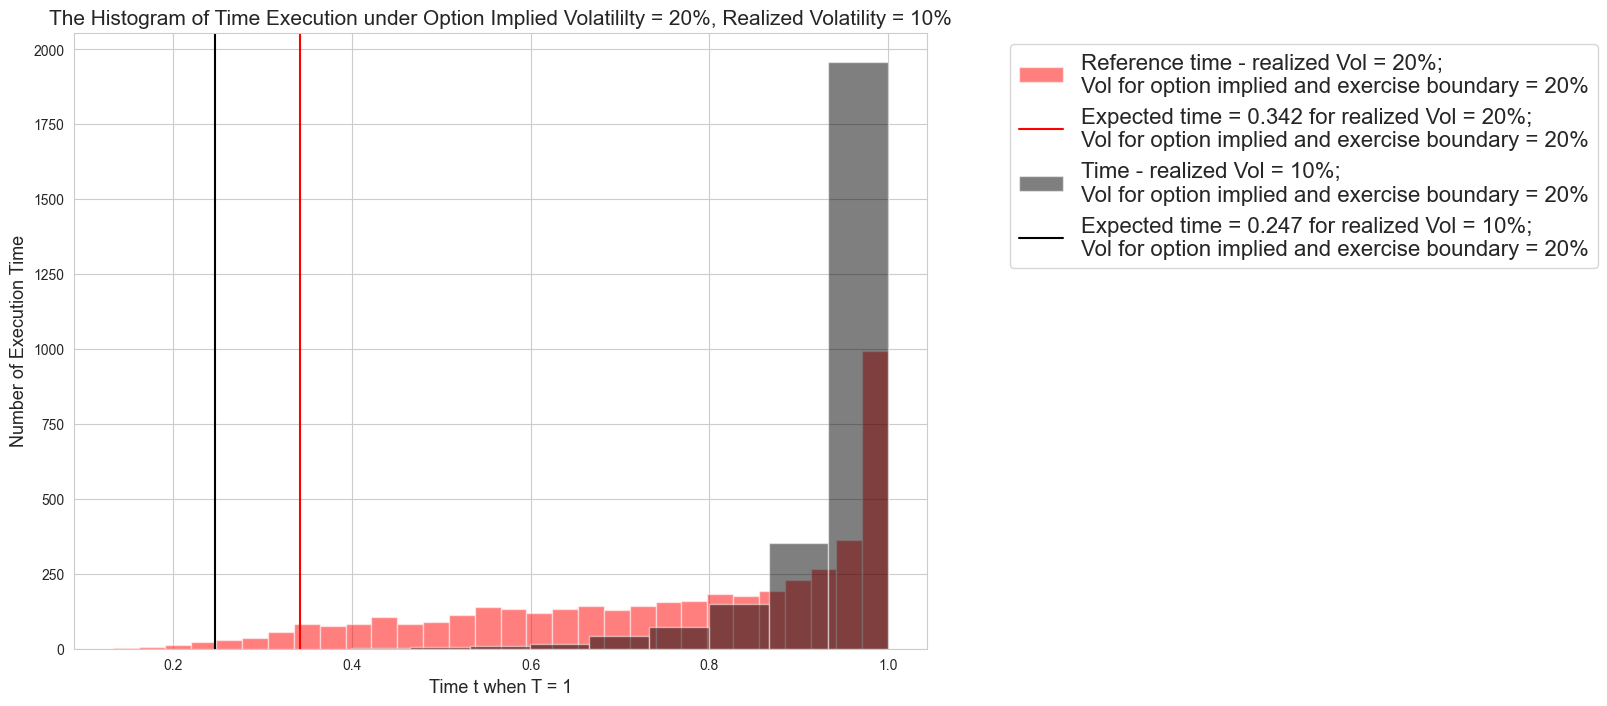

In [91]:
plt.figure(figsize = (11, 8))

(fair_vol_execution['execution_time']/5000).hist(label='Reference time - realized Vol = 20%; \nVol for option implied and exercise boundary = 20%',
                                  color = 'red',bins = 30,alpha =0.5)
plt.axvline(expected_pnl_include_no_execution(fair_vol_execution['execution_time'])/5000, color='red',
            label=f"Expected time = {expected_pnl_include_no_execution(fair_vol_execution['execution_time'])/5000:.3f} for realized Vol = 20%; \nVol for option implied and exercise boundary = 20%")

(passive_vol_execution['execution_time']/5000).hist(label='Time - realized Vol = 10%; \nVol for option implied and exercise boundary = 20%',
                                    color = 'black',bins = 9, alpha = 0.5)
plt.axvline(expected_pnl_include_no_execution(passive_vol_execution['execution_time'])/5000, color='black',
            label=f"Expected time = {expected_pnl_include_no_execution(passive_vol_execution['execution_time'])/5000:.3f} for realized Vol = 10%; \nVol for option implied and exercise boundary = 20%")

# plt.xlim(-1, 2.0)
plt.legend(loc = 'upper right', bbox_to_anchor=(1.8, 1), fontsize = 16)
plt.title('The Histogram of Time Execution under Option Implied Volatililty = 20%, Realized Volatility = 10%', fontsize = 15)
plt.xlabel('Time t when T = 1', fontsize = 13)
plt.ylabel('Number of Execution Time', fontsize = 13)
plt.show()

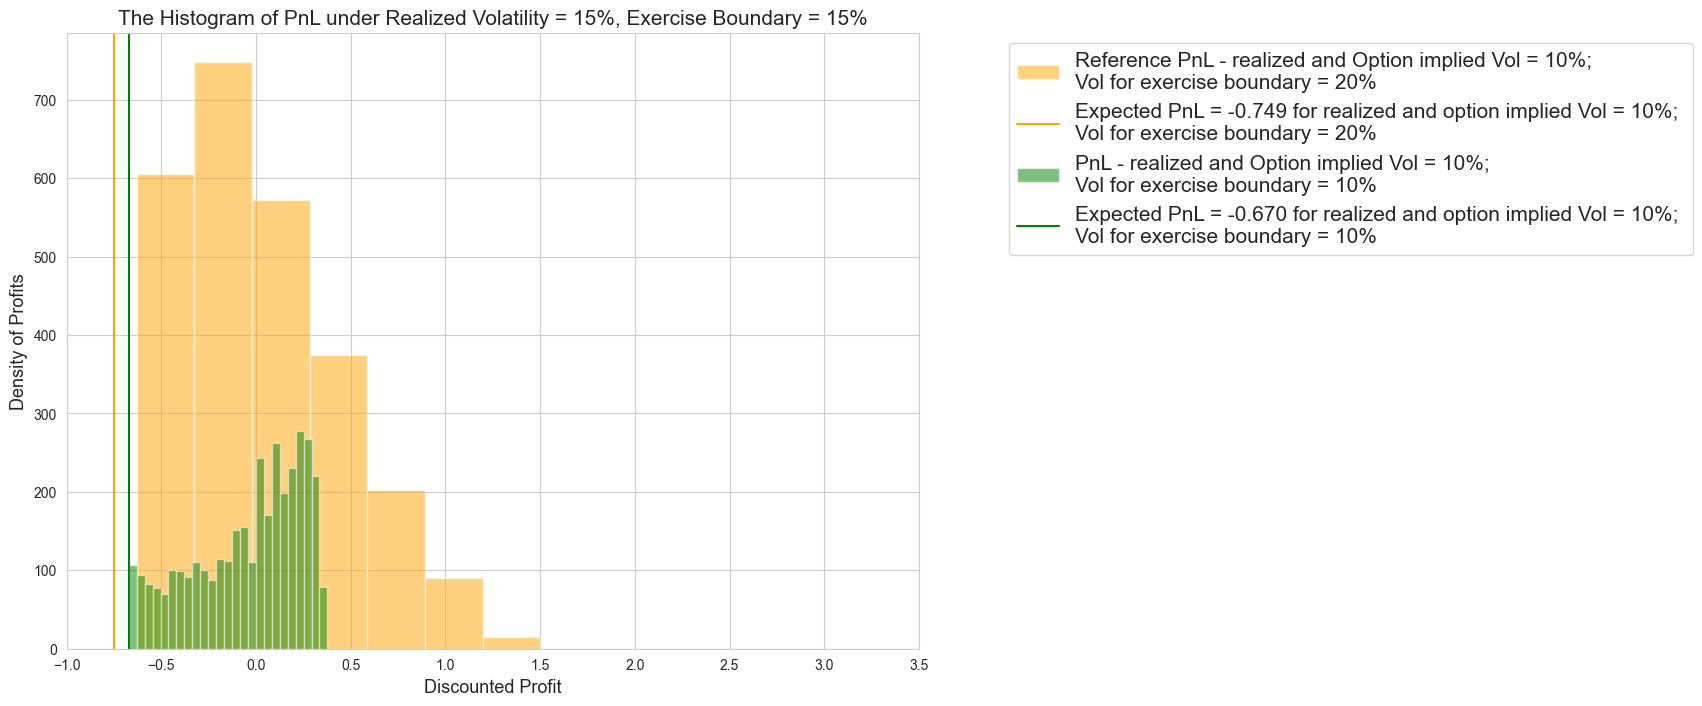

In [94]:
plt.figure(figsize = (11, 8))

passive_vol_execution['profit'].hist(label='Reference PnL - realized and Option implied Vol = 10%; \nVol for exercise boundary = 20%',
                                    color = 'orange', bins = 7, alpha = 0.5)

plt.axvline(expected_pnl_include_no_execution(passive_vol_execution['profit']), color='orange',
            label=f"Expected PnL = {expected_pnl_include_no_execution(passive_vol_execution['profit']):.3f} for realized and option implied Vol = 10%; \nVol for exercise boundary = 20%")

active_vol_execution['profit'].hist(label='PnL - realized and Option implied Vol = 10%; \nVol for exercise boundary = 10%',
                                    color = 'green', bins = 25,alpha = 0.5)
plt.axvline(expected_pnl_include_no_execution(active_vol_execution['profit']), color='green',
            label=f"Expected PnL = {expected_pnl_include_no_execution(active_vol_execution['profit']):.3f} for realized and option implied Vol = 10%; \nVol for exercise boundary = 10%")

plt.xlim(-1,3.5)
plt.legend(loc = 'upper right', bbox_to_anchor=(1.92, 1), fontsize = 15)
plt.title('The Histogram of PnL under Realized Volatility = 15%, Exercise Boundary = 15%', fontsize = 15)
plt.xlabel('Discounted Profit', fontsize = 13)
plt.ylabel('Density of Profits', fontsize = 13)
plt.show()